# B7 Top-195 2021-02-27






# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# data-train # # current best dataset.1424-79.
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'
CSVNAME = "K1345.b7.195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6195.jpg  52  127  75  370
1121  image_6196.jpg  62  138  29  383
1122  image_6197.jpg  54  135  78  380
1123  image_6198.jpg  60  125  29  384
1124  image_6199.jpg  51  147  70  353
...              ...  ..  ...  ..  ...
1340  image_6419.jpg  60  135  70  381
1341  image_6421.jpg  53  157  76  376
1342  image_6422.jpg  49  154  33  375
1343  image_6423.jpg  64  149  76  381
1344  image_6424.jpg  55  147  36  385

[225 rows x 5 columns]

In [8]:
len(df)

1345

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_0731.png  50  105  35  385
1  image_0460.png  56  156  39  384
2  image_0190.jpg  64  144  34  383
3  image_6176.jpg  61  133  30  380
4  image_0025.png  44  118  76  375
5  image_6214.jpg  61  103  79  382
6  image_6360.jpg  58  139  37  383
7  image_0135.png  57  116  76  384
8  image_6049.png  60  151  85  385
9  image_0958.png  46  137  78  383

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1345

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0731.png' 50 105 35 385
take sample: b'image_0460.png' 56 156 39 384
take sample: b'image_0190.jpg' 64 144 34 383
take sample: b'image_6176.jpg' 61 133 30 380
take sample: b'image_0025.png' 44 118 76 375


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0025.png


In [16]:
len(list_ds)

1345

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0731.png' 50 105
b'image_0460.png' 56 156
b'image_0190.jpg' 64 144
b'image_6176.jpg' 61 133


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0731.png' 50 105 35 385
b'image_0731.png' 50 105 35 385
b'image_0731.png' 50 105 35 385
b'image_0731.png' 50 105 35 385
===== Create iterator once and pull out to above cell. =====
b'image_0731.png' 50 105 35 385
b'image_0460.png' 56 156 39 384
b'image_0190.jpg' 64 144 34 383
b'image_6176.jpg' 61 133 30 380


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 50 25
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=50>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1076
269


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.5),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
            A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.5),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

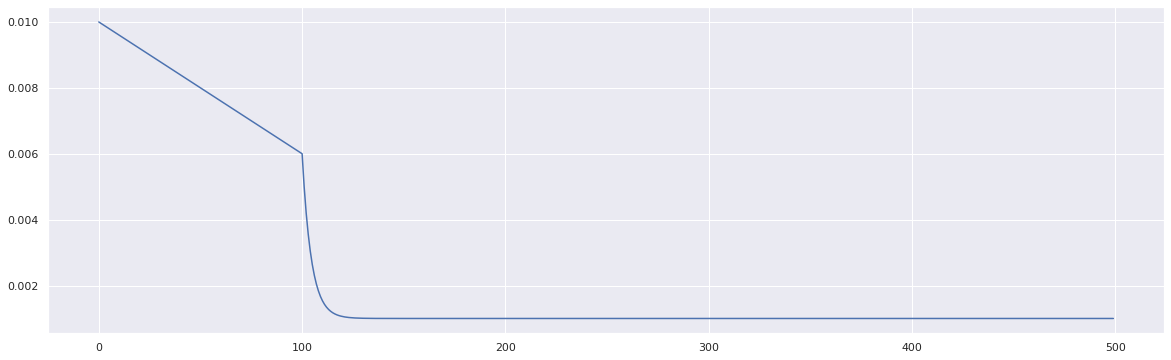

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

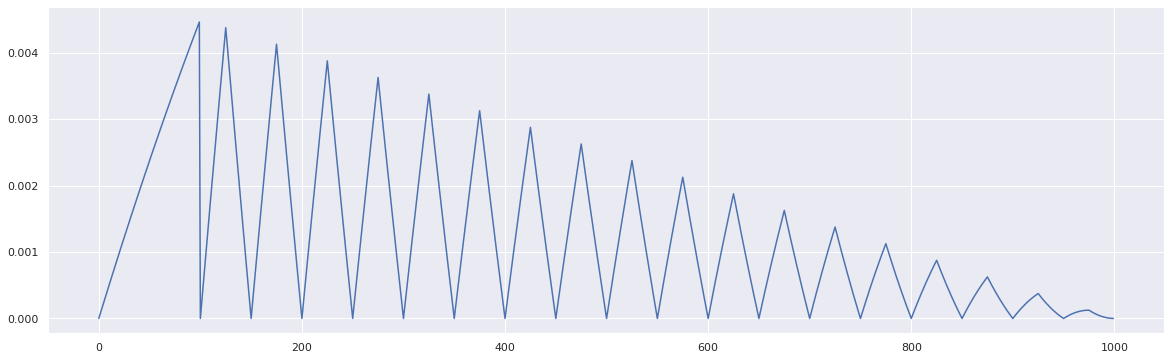

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 583 ms, sys: 55.1 ms, total: 638 ms
Wall time: 533 ms


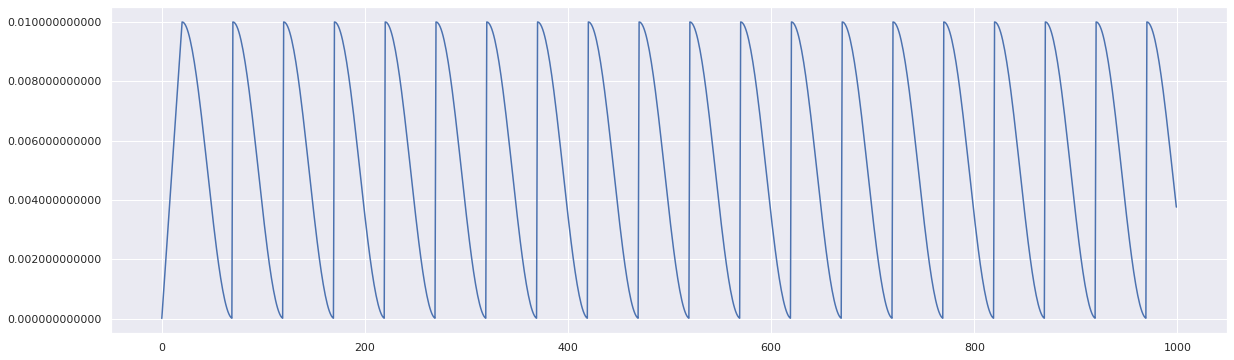

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB7'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
"""Supervised pre-training 減少每次fold都要重新train的時間
只先改toe"""

# Transfer learning from pre-trained weights
def load_pretrained_efn_model():
    pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
    model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

    # Freeze the pretrained weights
    model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
    fine_tune_at = 4 #10 #241 #20
    print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
    for layer in model.layers[-fine_tune_at:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            print('layer trainable +1', layer.name)
            layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 5



history_toe = []
history_toe_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("\n \n K = ", k, "\n")
    # Toe split
    train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
    # Toe ds_pre
    train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
    valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
#     # heel split
#     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
#     # Heel ds_pre
#     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
#     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    th = 'toe'
    # th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_toe_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_toe_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRtoe()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
#         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
#         count_model_trainOrNot_layers(model_toe)
        
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_tl)#, validation_split=0.1)
    history_toe.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_toe)
    count_model_trainOrNot_layers(model_toe)
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_fn)#, validation_split=0.1)
    history_toe_finetune.append(hist)



 
 K =  0 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210228-132845/toe_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens


[20210228-1331-55] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
17/17 [==============================] - ETA: 0s - loss: 16.7426
Epoch 00018: val_loss did not improve from 11.54958
17/17 [==============================] - 2s 100ms/step - loss: 16.7426 - val_loss: 13.1989

[20210228-1332-00] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
17/17 [==============================] - ETA: 0s - loss: 16.2605
Epoch 00019: val_loss did not improve from 11.54958
17/17 [==============================] - 2s 100ms/step - loss: 16.2605 - val_loss: 12.5235

[20210228-1332-04] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
17/17 [==============================] - ETA: 0s - loss: 16.1016
Epoch 00020: val_loss did not improve from 11.54958
17/17 [==============================] - 2s 100ms/step - loss: 16.1016 - val_loss: 12.2628

[20210228-1332-09] Learning rate for epoch 21 is 0.009200000204145908
Epoch 21/500
17/17 [==============================] -


[20210228-1337-55] Learning rate for epoch 9 is 0.00039725631359033287
Epoch 9/1000
17/17 [==============================] - ETA: 0s - loss: 13.8868
Epoch 00009: val_loss improved from 10.21994 to 9.90722, saving model to ./20210228-132845/toe_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 389ms/step - loss: 13.8868 - val_loss: 9.9072

[20210228-1338-05] Learning rate for epoch 10 is 0.0004464008961804211
Epoch 10/1000
17/17 [==============================] - ETA: 0s - loss: 13.9779
Epoch 00010: val_loss improved from 9.90722 to 9.22157, saving model to ./20210228-132845/toe_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 387ms/step - loss: 13.9779 - val_loss: 9.2216

[20210228-1338-14] Learning rate for epoch 11 is 0.0004954455071128905
Epoch 11/1000
17/17 [==============================] - ETA: 0s - loss: 12.8381
Epoch 00011: val_loss did not improve from 9.22157
17/17 [==============================]

17/17 [==============================] - ETA: 0s - loss: 10.0051
Epoch 00036: val_loss did not improve from 7.95872
17/17 [==============================] - 4s 259ms/step - loss: 10.0051 - val_loss: 8.2735

[20210228-1341-32] Learning rate for epoch 37 is 0.0017355084419250488
Epoch 37/1000
17/17 [==============================] - ETA: 0s - loss: 10.1456
Epoch 00037: val_loss improved from 7.95872 to 7.50058, saving model to ./20210228-132845/toe_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 389ms/step - loss: 10.1456 - val_loss: 7.5006

[20210228-1341-42] Learning rate for epoch 38 is 0.0017818533815443516
Epoch 38/1000
17/17 [==============================] - ETA: 0s - loss: 9.8879
Epoch 00038: val_loss did not improve from 7.50058
17/17 [==============================] - 4s 263ms/step - loss: 9.8879 - val_loss: 36.0572

[20210228-1341-49] Learning rate for epoch 39 is 0.0018280982039868832
Epoch 39/1000
17/17 [==============================


[20210228-1344-58] Learning rate for epoch 64 is 0.002951723290607333
Epoch 64/1000
17/17 [==============================] - ETA: 0s - loss: 9.0617
Epoch 00064: val_loss did not improve from 7.25204
17/17 [==============================] - 4s 260ms/step - loss: 9.0617 - val_loss: 8.7645

[20210228-1345-06] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
17/17 [==============================] - ETA: 0s - loss: 9.0168
Epoch 00065: val_loss improved from 7.25204 to 7.15830, saving model to ./20210228-132845/toe_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 395ms/step - loss: 9.0168 - val_loss: 7.1583

[20210228-1345-16] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
17/17 [==============================] - ETA: 0s - loss: 8.7581
Epoch 00066: val_loss did not improve from 7.15830
17/17 [==============================] - 4s 260ms/step - loss: 8.7581 - val_loss: 45.3008

[20210228-1345-23] Learning rate for epoc


[20210228-1348-32] Learning rate for epoch 91 is 0.004095045384019613
Epoch 91/1000
17/17 [==============================] - ETA: 0s - loss: 8.2717
Epoch 00091: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 265ms/step - loss: 8.2717 - val_loss: 7.4125

[20210228-1348-40] Learning rate for epoch 92 is 0.004135990981012583
Epoch 92/1000
17/17 [==============================] - ETA: 0s - loss: 8.1291
Epoch 00092: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 259ms/step - loss: 8.1291 - val_loss: 12.6872

[20210228-1348-47] Learning rate for epoch 93 is 0.004176836460828781
Epoch 93/1000
17/17 [==============================] - ETA: 0s - loss: 8.1952
Epoch 00093: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 258ms/step - loss: 8.1952 - val_loss: 13.3017

[20210228-1348-54] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
17/17 [==============================] - ETA: 

17/17 [==============================] - ETA: 0s - loss: 7.8307
Epoch 00119: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 259ms/step - loss: 7.8307 - val_loss: 7.1120

[20210228-1352-10] Learning rate for epoch 120 is 0.003347905818372965
Epoch 120/1000
17/17 [==============================] - ETA: 0s - loss: 8.0434
Epoch 00120: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 259ms/step - loss: 8.0434 - val_loss: 6.2176

[20210228-1352-17] Learning rate for epoch 121 is 0.0035200880374759436
Epoch 121/1000
17/17 [==============================] - ETA: 0s - loss: 7.7970
Epoch 00121: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 260ms/step - loss: 7.7970 - val_loss: 6.2304

[20210228-1352-25] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
17/17 [==============================] - ETA: 0s - loss: 7.7727
Epoch 00122: val_loss did not improve from 6.05800
17/17 [====

17/17 [==============================] - ETA: 0s - loss: 6.7957
Epoch 00147: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 258ms/step - loss: 6.7957 - val_loss: 6.4926

[20210228-1355-40] Learning rate for epoch 148 is 0.0005121753201819956
Epoch 148/1000
17/17 [==============================] - ETA: 0s - loss: 6.7251
Epoch 00148: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 264ms/step - loss: 6.7251 - val_loss: 6.4499

[20210228-1355-48] Learning rate for epoch 149 is 0.00034119191695936024
Epoch 149/1000
17/17 [==============================] - ETA: 0s - loss: 6.9894
Epoch 00149: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 259ms/step - loss: 6.9894 - val_loss: 6.5556

[20210228-1355-55] Learning rate for epoch 150 is 0.00017060847312677652
Epoch 150/1000
17/17 [==============================] - ETA: 0s - loss: 6.7083
Epoch 00150: val_loss did not improve from 6.05800
17/17 [

17/17 [==============================] - ETA: 0s - loss: 7.3578
Epoch 00175: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 260ms/step - loss: 7.3578 - val_loss: 27.6574

[20210228-1359-10] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
17/17 [==============================] - ETA: 0s - loss: 7.3062
Epoch 00176: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 259ms/step - loss: 7.3062 - val_loss: 377.0892

[20210228-1359-17] Learning rate for epoch 177 is 0.003955216612666845
Epoch 177/1000
17/17 [==============================] - ETA: 0s - loss: 7.1244
Epoch 00177: val_loss did not improve from 6.05800
17/17 [==============================] - 4s 263ms/step - loss: 7.1244 - val_loss: 280.8830

[20210228-1359-24] Learning rate for epoch 178 is 0.003785833017900586
Epoch 178/1000
17/17 [==============================] - ETA: 0s - loss: 7.2105
Epoch 00178: val_loss did not improve from 6.05800
17/17 [

17/17 [==============================] - ETA: 0s - loss: 6.2388
Epoch 00202: val_loss did not improve from 5.76740
17/17 [==============================] - 4s 259ms/step - loss: 6.2388 - val_loss: 5.7997

[20210228-1402-39] Learning rate for epoch 203 is 0.00031956707243807614
Epoch 203/1000
17/17 [==============================] - ETA: 0s - loss: 6.2563
Epoch 00203: val_loss did not improve from 5.76740
17/17 [==============================] - 4s 259ms/step - loss: 6.2563 - val_loss: 5.8973

[20210228-1402-47] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
17/17 [==============================] - ETA: 0s - loss: 6.2394
Epoch 00204: val_loss did not improve from 5.76740
17/17 [==============================] - 4s 258ms/step - loss: 6.2394 - val_loss: 5.8674

[20210228-1402-54] Learning rate for epoch 205 is 0.0006371343042701483
Epoch 205/1000
17/17 [==============================] - ETA: 0s - loss: 6.1370
Epoch 00205: val_loss did not improve from 5.76740
17/17 [


[20210228-1406-06] Learning rate for epoch 230 is 0.003238261677324772
Epoch 230/1000
17/17 [==============================] - ETA: 0s - loss: 6.8902
Epoch 00230: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 263ms/step - loss: 6.8902 - val_loss: 5.6708

[20210228-1406-14] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
17/17 [==============================] - ETA: 0s - loss: 6.6930
Epoch 00231: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 260ms/step - loss: 6.6930 - val_loss: 5.8124

[20210228-1406-21] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
17/17 [==============================] - ETA: 0s - loss: 6.5815
Epoch 00232: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 259ms/step - loss: 6.5815 - val_loss: 5.7349

[20210228-1406-29] Learning rate for epoch 233 is 0.002764907432720065
Epoch 233/1000
17/17 [==============================] - 

17/17 [==============================] - ETA: 0s - loss: 5.9120
Epoch 00258: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 259ms/step - loss: 5.9120 - val_loss: 6.1886

[20210228-1409-44] Learning rate for epoch 259 is 0.0011874522315338254
Epoch 259/1000
17/17 [==============================] - ETA: 0s - loss: 5.8564
Epoch 00259: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 258ms/step - loss: 5.8564 - val_loss: 6.1225

[20210228-1409-51] Learning rate for epoch 260 is 0.0013340371660888195
Epoch 260/1000
17/17 [==============================] - ETA: 0s - loss: 5.8868
Epoch 00260: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 259ms/step - loss: 5.8868 - val_loss: 6.3115

[20210228-1409-58] Learning rate for epoch 261 is 0.0014802219811826944
Epoch 261/1000
17/17 [==============================] - ETA: 0s - loss: 5.8254
Epoch 00261: val_loss did not improve from 5.35441
17/17 [==

17/17 [==============================] - ETA: 0s - loss: 6.2866
Epoch 00286: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 262ms/step - loss: 6.2866 - val_loss: 6.1509

[20210228-1413-14] Learning rate for epoch 287 is 0.0019993570167571306
Epoch 287/1000
17/17 [==============================] - ETA: 0s - loss: 6.2425
Epoch 00287: val_loss did not improve from 5.35441
17/17 [==============================] - 5s 266ms/step - loss: 6.2425 - val_loss: 9.0593

[20210228-1413-22] Learning rate for epoch 288 is 0.001853971160016954
Epoch 288/1000
17/17 [==============================] - ETA: 0s - loss: 6.4368
Epoch 00288: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 259ms/step - loss: 6.4368 - val_loss: 6.7335

[20210228-1413-29] Learning rate for epoch 289 is 0.001708985073491931
Epoch 289/1000
17/17 [==============================] - ETA: 0s - loss: 6.2553
Epoch 00289: val_loss did not improve from 5.35441
17/17 [====

17/17 [==============================] - ETA: 0s - loss: 5.6339
Epoch 00314: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 258ms/step - loss: 5.6339 - val_loss: 6.2048

[20210228-1416-44] Learning rate for epoch 315 is 0.0019209509482607245
Epoch 315/1000
17/17 [==============================] - ETA: 0s - loss: 5.6682
Epoch 00315: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 260ms/step - loss: 5.6682 - val_loss: 6.0066

[20210228-1416-52] Learning rate for epoch 316 is 0.002055136952549219
Epoch 316/1000
17/17 [==============================] - ETA: 0s - loss: 6.0048
Epoch 00316: val_loss did not improve from 5.35441
17/17 [==============================] - 4s 259ms/step - loss: 6.0048 - val_loss: 5.4375

[20210228-1416-59] Learning rate for epoch 317 is 0.002188923070207238
Epoch 317/1000
17/17 [==============================] - ETA: 0s - loss: 5.7151
Epoch 00317: val_loss did not improve from 5.35441
17/17 [====

17/17 [==============================] - ETA: 0s - loss: 17.3521
Epoch 00009: val_loss improved from 11.86672 to 11.69924, saving model to ./20210228-132845/toe_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 169ms/step - loss: 17.3521 - val_loss: 11.6992

[20210228-1420-34] Learning rate for epoch 10 is 0.009639999829232693
Epoch 10/500
17/17 [==============================] - ETA: 0s - loss: 17.1736
Epoch 00010: val_loss improved from 11.69924 to 11.63716, saving model to ./20210228-132845/toe_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 169ms/step - loss: 17.1736 - val_loss: 11.6372

[20210228-1420-40] Learning rate for epoch 11 is 0.009600000455975533
Epoch 11/500
17/17 [==============================] - ETA: 0s - loss: 16.5890
Epoch 00011: val_loss improved from 11.63716 to 11.56908, saving model to ./20210228-132845/toe_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [=========================

17/17 [==============================] - 3s 171ms/step - loss: 15.0788 - val_loss: 11.1346

[20210228-1422-39] Learning rate for epoch 35 is 0.00863999966531992
Epoch 35/500
17/17 [==============================] - ETA: 0s - loss: 15.0433
Epoch 00035: val_loss did not improve from 11.13458
17/17 [==============================] - 2s 101ms/step - loss: 15.0433 - val_loss: 11.3588

[20210228-1422-44] Learning rate for epoch 36 is 0.00860000029206276
Epoch 36/500
17/17 [==============================] - ETA: 0s - loss: 15.4396
Epoch 00036: val_loss did not improve from 11.13458
17/17 [==============================] - 2s 100ms/step - loss: 15.4396 - val_loss: 11.2310

[20210228-1422-49] Learning rate for epoch 37 is 0.008559999987483025
Epoch 37/500
17/17 [==============================] - ETA: 0s - loss: 15.5137
Epoch 00037: val_loss did not improve from 11.13458
17/17 [==============================] - 2s 100ms/step - loss: 15.5137 - val_loss: 11.9934

[20210228-1422-53] Learning rate f

17/17 [==============================] - ETA: 0s - loss: 14.4755
Epoch 00062: val_loss did not improve from 11.01436
17/17 [==============================] - 2s 100ms/step - loss: 14.4755 - val_loss: 11.1976

*********************************** Start fine tune ***********************************
tt: 660, nt:157, total layers:817
*********************************** Start fine tune ***********************************

[20210228-1424-50] Learning rate for epoch 1 is 4.999999987376214e-07
Epoch 1/1000
17/17 [==============================] - ETA: 0s - loss: 15.5524
Epoch 00001: val_loss did not improve from 11.01436
17/17 [==============================] - 55s 3s/step - loss: 15.5524 - val_loss: 11.3677

[20210228-1426-42] Learning rate for epoch 2 is 5.044450517743826e-05
Epoch 2/1000
17/17 [==============================] - ETA: 0s - loss: 15.6418
Epoch 00002: val_loss did not improve from 11.01436
17/17 [==============================] - 5s 265ms/step - loss: 15.6418 - val_loss: 11.4135


[20210228-1430-41] Learning rate for epoch 26 is 0.001219115569256246
Epoch 26/1000
17/17 [==============================] - ETA: 0s - loss: 10.1806
Epoch 00026: val_loss improved from 8.28471 to 8.21851, saving model to ./20210228-132845/toe_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 387ms/step - loss: 10.1806 - val_loss: 8.2185

[20210228-1430-51] Learning rate for epoch 27 is 0.0012665604008361697
Epoch 27/1000
17/17 [==============================] - ETA: 0s - loss: 9.9843 
Epoch 00027: val_loss improved from 8.21851 to 7.87522, saving model to ./20210228-132845/toe_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 385ms/step - loss: 9.9843 - val_loss: 7.8752

[20210228-1431-00] Learning rate for epoch 28 is 0.0013139051152393222
Epoch 28/1000
17/17 [==============================] - ETA: 0s - loss: 10.2378
Epoch 00028: val_loss did not improve from 7.87522
17/17 [==============================] -


[20210228-1434-12] Learning rate for epoch 53 is 0.002465027617290616
Epoch 53/1000
17/17 [==============================] - ETA: 0s - loss: 8.4013
Epoch 00053: val_loss did not improve from 7.13347
17/17 [==============================] - 4s 260ms/step - loss: 8.4013 - val_loss: 52.2869

[20210228-1434-20] Learning rate for epoch 54 is 0.0025097725447267294
Epoch 54/1000
17/17 [==============================] - ETA: 0s - loss: 8.1506
Epoch 00054: val_loss did not improve from 7.13347
17/17 [==============================] - 4s 259ms/step - loss: 8.1506 - val_loss: 100.0823

[20210228-1434-27] Learning rate for epoch 55 is 0.0025544175878167152
Epoch 55/1000
17/17 [==============================] - ETA: 0s - loss: 8.2923
Epoch 00055: val_loss did not improve from 7.13347
17/17 [==============================] - 4s 259ms/step - loss: 8.2923 - val_loss: 16.6716

[20210228-1434-35] Learning rate for epoch 56 is 0.00259896251372993
Epoch 56/1000
17/17 [==============================] - ET

17/17 [==============================] - ETA: 0s - loss: 7.8014
Epoch 00080: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 259ms/step - loss: 7.8014 - val_loss: 6.4225

[20210228-1437-50] Learning rate for epoch 81 is 0.0036800920497626066
Epoch 81/1000
17/17 [==============================] - ETA: 0s - loss: 7.8199
Epoch 00081: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 260ms/step - loss: 7.8199 - val_loss: 6.2461

[20210228-1437-57] Learning rate for epoch 82 is 0.003722037188708782
Epoch 82/1000
17/17 [==============================] - ETA: 0s - loss: 7.9136
Epoch 00082: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 259ms/step - loss: 7.9136 - val_loss: 6.1216

[20210228-1438-05] Learning rate for epoch 83 is 0.003763882676139474
Epoch 83/1000
17/17 [==============================] - ETA: 0s - loss: 7.9528
Epoch 00083: val_loss did not improve from 5.96671
17/17 [==========


[20210228-1441-20] Learning rate for epoch 109 is 0.001427503302693367
Epoch 109/1000
17/17 [==============================] - ETA: 0s - loss: 7.3829
Epoch 00109: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 259ms/step - loss: 7.3829 - val_loss: 6.2546

[20210228-1441-27] Learning rate for epoch 110 is 0.0016040850896388292
Epoch 110/1000
17/17 [==============================] - ETA: 0s - loss: 7.0258
Epoch 00110: val_loss did not improve from 5.96671
17/17 [==============================] - 5s 265ms/step - loss: 7.0258 - val_loss: 6.3621

[20210228-1441-35] Learning rate for epoch 111 is 0.001780266989953816
Epoch 111/1000
17/17 [==============================] - ETA: 0s - loss: 7.3941
Epoch 00111: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 259ms/step - loss: 7.3941 - val_loss: 6.8192

[20210228-1441-42] Learning rate for epoch 112 is 0.0019560488872230053
Epoch 112/1000
17/17 [==============================]

17/17 [==============================] - ETA: 0s - loss: 6.9843
Epoch 00137: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 259ms/step - loss: 6.9843 - val_loss: 6.0692

[20210228-1444-59] Learning rate for epoch 138 is 0.0022440070752054453
Epoch 138/1000
17/17 [==============================] - ETA: 0s - loss: 6.8917
Epoch 00138: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 260ms/step - loss: 6.8917 - val_loss: 6.0984

[20210228-1445-07] Learning rate for epoch 139 is 0.002069024136289954
Epoch 139/1000
17/17 [==============================] - ETA: 0s - loss: 6.7447
Epoch 00139: val_loss did not improve from 5.96671
17/17 [==============================] - 4s 262ms/step - loss: 6.7447 - val_loss: 6.5159

[20210228-1445-14] Learning rate for epoch 140 is 0.0018944410840049386
Epoch 140/1000
17/17 [==============================] - ETA: 0s - loss: 7.0813
Epoch 00140: val_loss improved from 5.96671 to 5.80830, savin

17/17 [==============================] - 7s 388ms/step - loss: 6.3799 - val_loss: 5.5893

[20210228-1448-29] Learning rate for epoch 165 is 0.002340983832255006
Epoch 165/1000
17/17 [==============================] - ETA: 0s - loss: 6.4902
Epoch 00165: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 259ms/step - loss: 6.4902 - val_loss: 5.9567

[20210228-1448-36] Learning rate for epoch 166 is 0.002505166921764612
Epoch 166/1000
17/17 [==============================] - ETA: 0s - loss: 6.3084
Epoch 00166: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 259ms/step - loss: 6.3084 - val_loss: 6.2814

[20210228-1448-44] Learning rate for epoch 167 is 0.002668950008228421
Epoch 167/1000
17/17 [==============================] - ETA: 0s - loss: 6.3271
Epoch 00167: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 259ms/step - loss: 6.3271 - val_loss: 6.0204

[20210228-1448-51] Learning rate for 


[20210228-1451-59] Learning rate for epoch 193 is 0.001293074688874185
Epoch 193/1000
17/17 [==============================] - ETA: 0s - loss: 6.3420
Epoch 00193: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 265ms/step - loss: 6.3420 - val_loss: 6.1583

[20210228-1452-07] Learning rate for epoch 194 is 0.0011300905607640743
Epoch 194/1000
17/17 [==============================] - ETA: 0s - loss: 6.3026
Epoch 00194: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 262ms/step - loss: 6.3026 - val_loss: 6.1649

[20210228-1452-14] Learning rate for epoch 195 is 0.0009675062610767782
Epoch 195/1000
17/17 [==============================] - ETA: 0s - loss: 6.3378
Epoch 00195: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 259ms/step - loss: 6.3378 - val_loss: 6.0713

[20210228-1452-21] Learning rate for epoch 196 is 0.0008053220226429403
Epoch 196/1000
17/17 [==============================

17/17 [==============================] - ETA: 0s - loss: 6.2658
Epoch 00221: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 259ms/step - loss: 6.2658 - val_loss: 6.0271

[20210228-1455-37] Learning rate for epoch 222 is 0.0032718623988330364
Epoch 222/1000
17/17 [==============================] - ETA: 0s - loss: 6.4397
Epoch 00222: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 259ms/step - loss: 6.4397 - val_loss: 6.6787

[20210228-1455-44] Learning rate for epoch 223 is 0.0034232467878609896
Epoch 223/1000
17/17 [==============================] - ETA: 0s - loss: 6.5175
Epoch 00223: val_loss did not improve from 5.58929
17/17 [==============================] - 5s 265ms/step - loss: 6.5175 - val_loss: 6.0965

[20210228-1455-52] Learning rate for epoch 224 is 0.0035742311738431454
Epoch 224/1000
17/17 [==============================] - ETA: 0s - loss: 6.4074
Epoch 00224: val_loss did not improve from 5.58929
17/17 [==

17/17 [==============================] - ETA: 0s - loss: 5.8468
Epoch 00249: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 258ms/step - loss: 5.8468 - val_loss: 5.8994

[20210228-1459-07] Learning rate for epoch 250 is 0.00015056047413963825
Epoch 250/1000
17/17 [==============================] - ETA: 0s - loss: 5.9465
Epoch 00250: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 258ms/step - loss: 5.9465 - val_loss: 5.8582

[20210228-1459-15] Learning rate for epoch 251 is 3.7500001326407073e-07
Epoch 251/1000
17/17 [==============================] - ETA: 0s - loss: 5.7838
Epoch 00251: val_loss did not improve from 5.58929
17/17 [==============================] - 4s 260ms/step - loss: 5.7838 - val_loss: 5.8592

[20210228-1459-22] Learning rate for epoch 252 is 0.00015015952521935105
Epoch 252/1000
17/17 [==============================] - ETA: 0s - loss: 5.7906
Epoch 00252: val_loss did not improve from 5.58929
17/17 

17/17 [==============================] - ETA: 0s - loss: 17.6967
Epoch 00009: val_loss did not improve from 11.69766
17/17 [==============================] - 2s 101ms/step - loss: 17.6967 - val_loss: 11.7966

[20210228-1502-52] Learning rate for epoch 10 is 0.009639999829232693
Epoch 10/500
17/17 [==============================] - ETA: 0s - loss: 16.9930
Epoch 00010: val_loss improved from 11.69766 to 11.45450, saving model to ./20210228-132845/toe_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 174ms/step - loss: 16.9930 - val_loss: 11.4545

[20210228-1502-58] Learning rate for epoch 11 is 0.009600000455975533
Epoch 11/500
17/17 [==============================] - ETA: 0s - loss: 17.3031
Epoch 00011: val_loss did not improve from 11.45450
17/17 [==============================] - 2s 101ms/step - loss: 17.3031 - val_loss: 11.5303

[20210228-1503-02] Learning rate for epoch 12 is 0.009560000151395798
Epoch 12/500
17/17 [============================


[20210228-1505-01] Learning rate for epoch 36 is 0.00860000029206276
Epoch 36/500
17/17 [==============================] - ETA: 0s - loss: 15.5860
Epoch 00036: val_loss did not improve from 10.78976
17/17 [==============================] - 2s 104ms/step - loss: 15.5860 - val_loss: 10.8963

[20210228-1505-06] Learning rate for epoch 37 is 0.008559999987483025
Epoch 37/500
17/17 [==============================] - ETA: 0s - loss: 15.0612
Epoch 00037: val_loss improved from 10.78976 to 10.75403, saving model to ./20210228-132845/toe_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 179ms/step - loss: 15.0612 - val_loss: 10.7540

[20210228-1505-12] Learning rate for epoch 38 is 0.00851999968290329
Epoch 38/500
17/17 [==============================] - ETA: 0s - loss: 15.3294
Epoch 00038: val_loss did not improve from 10.75403
17/17 [==============================] - 2s 107ms/step - loss: 15.3294 - val_loss: 11.0364

[20210228-1505-17] Learning rate for

17/17 [==============================] - ETA: 0s - loss: 13.6202
Epoch 00006: val_loss improved from 10.75403 to 10.61027, saving model to ./20210228-132845/toe_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 404ms/step - loss: 13.6202 - val_loss: 10.6103

[20210228-1509-58] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
17/17 [==============================] - ETA: 0s - loss: 13.4838
Epoch 00007: val_loss improved from 10.61027 to 10.27023, saving model to ./20210228-132845/toe_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 389ms/step - loss: 13.4838 - val_loss: 10.2702

[20210228-1510-08] Learning rate for epoch 8 is 0.00034801175934262574
Epoch 8/1000
17/17 [==============================] - ETA: 0s - loss: 13.0275
Epoch 00008: val_loss improved from 10.27023 to 10.04421, saving model to ./20210228-132845/toe_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [========================

17/17 [==============================] - ETA: 0s - loss: 9.6768
Epoch 00031: val_loss did not improve from 6.94975
17/17 [==============================] - 4s 259ms/step - loss: 9.6768 - val_loss: 13.2045

[20210228-1513-26] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
17/17 [==============================] - ETA: 0s - loss: 9.3785
Epoch 00032: val_loss did not improve from 6.94975
17/17 [==============================] - 4s 262ms/step - loss: 9.3785 - val_loss: 8.2503

[20210228-1513-34] Learning rate for epoch 33 is 0.0015491291414946318
Epoch 33/1000
17/17 [==============================] - ETA: 0s - loss: 9.4974
Epoch 00033: val_loss did not improve from 6.94975
17/17 [==============================] - 5s 266ms/step - loss: 9.4974 - val_loss: 7.5958

[20210228-1513-41] Learning rate for epoch 34 is 0.00159587396774441
Epoch 34/1000
17/17 [==============================] - ETA: 0s - loss: 9.3276
Epoch 00034: val_loss did not improve from 6.94975
17/17 [=========

17/17 [==============================] - ETA: 0s - loss: 8.3954
Epoch 00059: val_loss did not improve from 6.58863
17/17 [==============================] - 4s 259ms/step - loss: 8.3954 - val_loss: 29.0784

[20210228-1516-59] Learning rate for epoch 60 is 0.0027761429082602262
Epoch 60/1000
17/17 [==============================] - ETA: 0s - loss: 8.2591
Epoch 00060: val_loss did not improve from 6.58863
17/17 [==============================] - 4s 259ms/step - loss: 8.2591 - val_loss: 25.4593

[20210228-1517-06] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
17/17 [==============================] - ETA: 0s - loss: 8.5787
Epoch 00061: val_loss did not improve from 6.58863
17/17 [==============================] - 4s 260ms/step - loss: 8.5787 - val_loss: 10.0311

[20210228-1517-14] Learning rate for epoch 62 is 0.0028641331009566784
Epoch 62/1000
17/17 [==============================] - ETA: 0s - loss: 7.8907
Epoch 00062: val_loss did not improve from 6.58863
17/17 [======


[20210228-1520-29] Learning rate for epoch 88 is 0.00397160928696394
Epoch 88/1000
17/17 [==============================] - ETA: 0s - loss: 7.6912
Epoch 00088: val_loss did not improve from 6.58863
17/17 [==============================] - 4s 260ms/step - loss: 7.6912 - val_loss: 7.7687

[20210228-1520-37] Learning rate for epoch 89 is 0.004012854769825935
Epoch 89/1000
17/17 [==============================] - ETA: 0s - loss: 7.5004
Epoch 00089: val_loss did not improve from 6.58863
17/17 [==============================] - 4s 259ms/step - loss: 7.5004 - val_loss: 8.2271

[20210228-1520-44] Learning rate for epoch 90 is 0.00405400013551116
Epoch 90/1000
17/17 [==============================] - ETA: 0s - loss: 7.7129
Epoch 00090: val_loss did not improve from 6.58863
17/17 [==============================] - 4s 260ms/step - loss: 7.7129 - val_loss: 7.9695

[20210228-1520-52] Learning rate for epoch 91 is 0.004095045384019613
Epoch 91/1000
17/17 [==============================] - ETA: 0s -


[20210228-1524-01] Learning rate for epoch 116 is 0.0026551769115030766
Epoch 116/1000
17/17 [==============================] - ETA: 0s - loss: 7.2316
Epoch 00116: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 260ms/step - loss: 7.2316 - val_loss: 7.0521

[20210228-1524-08] Learning rate for epoch 117 is 0.0028289591427892447
Epoch 117/1000
17/17 [==============================] - ETA: 0s - loss: 7.2221
Epoch 00117: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 259ms/step - loss: 7.2221 - val_loss: 7.3507

[20210228-1524-16] Learning rate for epoch 118 is 0.0030023413710296154
Epoch 118/1000
17/17 [==============================] - ETA: 0s - loss: 7.2756
Epoch 00118: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 259ms/step - loss: 7.2756 - val_loss: 7.4821

[20210228-1524-23] Learning rate for epoch 119 is 0.003175323596224189
Epoch 119/1000
17/17 [==============================

17/17 [==============================] - ETA: 0s - loss: 6.5314
Epoch 00144: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 259ms/step - loss: 6.5314 - val_loss: 7.0280

[20210228-1527-39] Learning rate for epoch 145 is 0.0010275252861902118
Epoch 145/1000
17/17 [==============================] - ETA: 0s - loss: 6.2234
Epoch 00145: val_loss did not improve from 6.38702
17/17 [==============================] - 5s 265ms/step - loss: 6.2234 - val_loss: 7.0184

[20210228-1527-46] Learning rate for epoch 146 is 0.0008553420193493366
Epoch 146/1000
17/17 [==============================] - ETA: 0s - loss: 6.2308
Epoch 00146: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 260ms/step - loss: 6.2308 - val_loss: 6.9314

[20210228-1527-54] Learning rate for epoch 147 is 0.0006835586973465979
Epoch 147/1000
17/17 [==============================] - ETA: 0s - loss: 6.7352
Epoch 00147: val_loss did not improve from 6.38702
17/17 [==

17/17 [==============================] - ETA: 0s - loss: 7.2908
Epoch 00172: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 259ms/step - loss: 7.2908 - val_loss: 11.6370

[20210228-1531-09] Learning rate for epoch 173 is 0.0036432496272027493
Epoch 173/1000
17/17 [==============================] - ETA: 0s - loss: 7.5662
Epoch 00173: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 259ms/step - loss: 7.5662 - val_loss: 86.5325

[20210228-1531-16] Learning rate for epoch 174 is 0.003804233158007264
Epoch 174/1000
17/17 [==============================] - ETA: 0s - loss: 7.1229
Epoch 00174: val_loss did not improve from 6.38702
17/17 [==============================] - 4s 260ms/step - loss: 7.1229 - val_loss: 34.9923

[20210228-1531-23] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
17/17 [==============================] - ETA: 0s - loss: 7.2954
Epoch 00175: val_loss did not improve from 6.38702
17/17 [=


[20210228-1535-04] Learning rate for epoch 6 is 0.009800000116229057
Epoch 6/500
17/17 [==============================] - ETA: 0s - loss: 18.0309
Epoch 00006: val_loss improved from 12.49759 to 11.86978, saving model to ./20210228-132845/toe_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 174ms/step - loss: 18.0309 - val_loss: 11.8698

[20210228-1535-10] Learning rate for epoch 7 is 0.009759999811649323
Epoch 7/500
17/17 [==============================] - ETA: 0s - loss: 18.1724
Epoch 00007: val_loss did not improve from 11.86978
17/17 [==============================] - 2s 106ms/step - loss: 18.1724 - val_loss: 12.0054

[20210228-1535-14] Learning rate for epoch 8 is 0.009720000438392162
Epoch 8/500
17/17 [==============================] - ETA: 0s - loss: 17.4199
Epoch 00008: val_loss did not improve from 11.86978
17/17 [==============================] - 2s 101ms/step - loss: 17.4199 - val_loss: 12.0189

[20210228-1535-19] Learning rate for epo

17/17 [==============================] - 3s 174ms/step - loss: 15.1396 - val_loss: 11.0611

[20210228-1537-14] Learning rate for epoch 32 is 0.00875999964773655
Epoch 32/500
17/17 [==============================] - ETA: 0s - loss: 15.6832
Epoch 00032: val_loss did not improve from 11.06114
17/17 [==============================] - 2s 106ms/step - loss: 15.6832 - val_loss: 11.1708

[20210228-1537-19] Learning rate for epoch 33 is 0.00872000027447939
Epoch 33/500
17/17 [==============================] - ETA: 0s - loss: 15.3292
Epoch 00033: val_loss did not improve from 11.06114
17/17 [==============================] - 2s 102ms/step - loss: 15.3292 - val_loss: 11.1386

[20210228-1537-24] Learning rate for epoch 34 is 0.008679999969899654
Epoch 34/500
17/17 [==============================] - ETA: 0s - loss: 14.9598
Epoch 00034: val_loss did not improve from 11.06114
17/17 [==============================] - 2s 107ms/step - loss: 14.9598 - val_loss: 11.5114

[20210228-1537-28] Learning rate f

17/17 [==============================] - 7s 390ms/step - loss: 13.4324 - val_loss: 9.5434

[20210228-1542-12] Learning rate for epoch 8 is 0.00034801175934262574
Epoch 8/1000
17/17 [==============================] - ETA: 0s - loss: 13.3822
Epoch 00008: val_loss improved from 9.54341 to 9.31552, saving model to ./20210228-132845/toe_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 391ms/step - loss: 13.3822 - val_loss: 9.3155

[20210228-1542-22] Learning rate for epoch 9 is 0.00039725631359033287
Epoch 9/1000
17/17 [==============================] - ETA: 0s - loss: 12.7350
Epoch 00009: val_loss did not improve from 9.31552
17/17 [==============================] - 4s 263ms/step - loss: 12.7350 - val_loss: 9.7194

[20210228-1542-30] Learning rate for epoch 10 is 0.0004464008961804211
Epoch 10/1000
17/17 [==============================] - ETA: 0s - loss: 12.8030
Epoch 00010: val_loss improved from 9.31552 to 8.84124, saving model to ./20210228-132845

17/17 [==============================] - ETA: 0s - loss: 9.8037
Epoch 00033: val_loss did not improve from 7.32038
17/17 [==============================] - 4s 260ms/step - loss: 9.8037 - val_loss: 8.8916

[20210228-1545-45] Learning rate for epoch 34 is 0.00159587396774441
Epoch 34/1000
17/17 [==============================] - ETA: 0s - loss: 9.4650
Epoch 00034: val_loss did not improve from 7.32038
17/17 [==============================] - 5s 266ms/step - loss: 9.4650 - val_loss: 8.1945

[20210228-1545-53] Learning rate for epoch 35 is 0.001642518793232739
Epoch 35/1000
17/17 [==============================] - ETA: 0s - loss: 9.4370
Epoch 00035: val_loss did not improve from 7.32038
17/17 [==============================] - 4s 260ms/step - loss: 9.4370 - val_loss: 8.1839

[20210228-1546-00] Learning rate for epoch 36 is 0.0016890636179596186
Epoch 36/1000
17/17 [==============================] - ETA: 0s - loss: 9.6232
Epoch 00036: val_loss did not improve from 7.32038
17/17 [===========


[20210228-1549-15] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
17/17 [==============================] - ETA: 0s - loss: 9.0532
Epoch 00061: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 9.0532 - val_loss: 273.9510

[20210228-1549-23] Learning rate for epoch 62 is 0.0028641331009566784
Epoch 62/1000
17/17 [==============================] - ETA: 0s - loss: 8.5953
Epoch 00062: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 8.5953 - val_loss: 41.5396

[20210228-1549-30] Learning rate for epoch 63 is 0.0029079781379550695
Epoch 63/1000
17/17 [==============================] - ETA: 0s - loss: 8.4377
Epoch 00063: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 261ms/step - loss: 8.4377 - val_loss: 423021.9688

[20210228-1549-38] Learning rate for epoch 64 is 0.002951723290607333
Epoch 64/1000
17/17 [==============================]

17/17 [==============================] - ETA: 0s - loss: 8.1912
Epoch 00089: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 8.1912 - val_loss: 8.1724

[20210228-1552-53] Learning rate for epoch 90 is 0.00405400013551116
Epoch 90/1000
17/17 [==============================] - ETA: 0s - loss: 7.9933
Epoch 00090: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 7.9933 - val_loss: 13.9994

[20210228-1553-00] Learning rate for epoch 91 is 0.004095045384019613
Epoch 91/1000
17/17 [==============================] - ETA: 0s - loss: 8.0245
Epoch 00091: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 8.0245 - val_loss: 7.8254

[20210228-1553-08] Learning rate for epoch 92 is 0.004135990981012583
Epoch 92/1000
17/17 [==============================] - ETA: 0s - loss: 7.9141
Epoch 00092: val_loss did not improve from 6.69130
17/17 [===========

17/17 [==============================] - ETA: 0s - loss: 7.5827
Epoch 00117: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 7.5827 - val_loss: 71.7273

[20210228-1556-23] Learning rate for epoch 118 is 0.0030023413710296154
Epoch 118/1000
17/17 [==============================] - ETA: 0s - loss: 7.2183
Epoch 00118: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 7.2183 - val_loss: 57.4420

[20210228-1556-31] Learning rate for epoch 119 is 0.003175323596224189
Epoch 119/1000
17/17 [==============================] - ETA: 0s - loss: 7.6442
Epoch 00119: val_loss did not improve from 6.69130
17/17 [==============================] - 4s 260ms/step - loss: 7.6442 - val_loss: 24.2678

[20210228-1556-38] Learning rate for epoch 120 is 0.003347905818372965
Epoch 120/1000
17/17 [==============================] - ETA: 0s - loss: 7.5477
Epoch 00120: val_loss did not improve from 6.69130
17/17 [=

17/17 [==============================] - ETA: 0s - loss: 7.1448
Epoch 00145: val_loss did not improve from 6.20978
17/17 [==============================] - 5s 266ms/step - loss: 7.1448 - val_loss: 6.7252

[20210228-1559-57] Learning rate for epoch 146 is 0.0008553420193493366
Epoch 146/1000
17/17 [==============================] - ETA: 0s - loss: 6.8837
Epoch 00146: val_loss did not improve from 6.20978
17/17 [==============================] - 4s 259ms/step - loss: 6.8837 - val_loss: 6.7518

[20210228-1600-04] Learning rate for epoch 147 is 0.0006835586973465979
Epoch 147/1000
17/17 [==============================] - ETA: 0s - loss: 7.0562
Epoch 00147: val_loss did not improve from 6.20978
17/17 [==============================] - 4s 260ms/step - loss: 7.0562 - val_loss: 6.6981

[20210228-1600-12] Learning rate for epoch 148 is 0.0005121753201819956
Epoch 148/1000
17/17 [==============================] - ETA: 0s - loss: 6.9313
Epoch 00148: val_loss did not improve from 6.20978
17/17 [==

17/17 [==============================] - ETA: 0s - loss: 7.0213
Epoch 00173: val_loss did not improve from 6.13296
17/17 [==============================] - 4s 260ms/step - loss: 7.0213 - val_loss: 6.4513

[20210228-1603-32] Learning rate for epoch 174 is 0.003804233158007264
Epoch 174/1000
17/17 [==============================] - ETA: 0s - loss: 7.1244
Epoch 00174: val_loss did not improve from 6.13296
17/17 [==============================] - 4s 260ms/step - loss: 7.1244 - val_loss: 6.5168

[20210228-1603-39] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
17/17 [==============================] - ETA: 0s - loss: 7.1069
Epoch 00175: val_loss did not improve from 6.13296
17/17 [==============================] - 4s 262ms/step - loss: 7.1069 - val_loss: 6.3659

[20210228-1603-47] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
17/17 [==============================] - ETA: 0s - loss: 7.5461
Epoch 00176: val_loss did not improve from 6.13296
17/17 [=====

17/17 [==============================] - ETA: 0s - loss: 6.1293
Epoch 00201: val_loss did not improve from 6.13296
17/17 [==============================] - 4s 260ms/step - loss: 6.1293 - val_loss: 6.4385

[20210228-1607-02] Learning rate for epoch 202 is 0.0001601835247129202
Epoch 202/1000
17/17 [==============================] - ETA: 0s - loss: 6.4630
Epoch 00202: val_loss did not improve from 6.13296
17/17 [==============================] - 4s 259ms/step - loss: 6.4630 - val_loss: 6.4352

[20210228-1607-09] Learning rate for epoch 203 is 0.00031956707243807614
Epoch 203/1000
17/17 [==============================] - ETA: 0s - loss: 6.4365
Epoch 00203: val_loss did not improve from 6.13296
17/17 [==============================] - 4s 260ms/step - loss: 6.4365 - val_loss: 6.5089

[20210228-1607-17] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
17/17 [==============================] - ETA: 0s - loss: 6.3326
Epoch 00204: val_loss did not improve from 6.13296
17/17 [

17/17 [==============================] - ETA: 0s - loss: 7.2194
Epoch 00229: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 7.2194 - val_loss: 6.5450

[20210228-1610-35] Learning rate for epoch 230 is 0.003238261677324772
Epoch 230/1000
17/17 [==============================] - ETA: 0s - loss: 6.6750
Epoch 00230: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 263ms/step - loss: 6.6750 - val_loss: 6.5885

[20210228-1610-43] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
17/17 [==============================] - ETA: 0s - loss: 7.1383
Epoch 00231: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 7.1383 - val_loss: 7.8530

[20210228-1610-50] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
17/17 [==============================] - ETA: 0s - loss: 6.8943
Epoch 00232: val_loss did not improve from 6.02306
17/17 [======

17/17 [==============================] - ETA: 0s - loss: 5.9532
Epoch 00257: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 263ms/step - loss: 5.9532 - val_loss: 6.4999

[20210228-1614-06] Learning rate for epoch 258 is 0.0010404675267636776
Epoch 258/1000
17/17 [==============================] - ETA: 0s - loss: 6.0320
Epoch 00258: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 261ms/step - loss: 6.0320 - val_loss: 6.6864

[20210228-1614-13] Learning rate for epoch 259 is 0.0011874522315338254
Epoch 259/1000
17/17 [==============================] - ETA: 0s - loss: 5.9286
Epoch 00259: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 5.9286 - val_loss: 6.5606

[20210228-1614-21] Learning rate for epoch 260 is 0.0013340371660888195
Epoch 260/1000
17/17 [==============================] - ETA: 0s - loss: 6.2123
Epoch 00260: val_loss did not improve from 6.02306
17/17 [==

17/17 [==============================] - ETA: 0s - loss: 5.9435
Epoch 00285: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 5.9435 - val_loss: 6.9315

[20210228-1617-36] Learning rate for epoch 286 is 0.0021451429929584265
Epoch 286/1000
17/17 [==============================] - ETA: 0s - loss: 6.1163
Epoch 00286: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 261ms/step - loss: 6.1163 - val_loss: 6.2773

[20210228-1617-44] Learning rate for epoch 287 is 0.0019993570167571306
Epoch 287/1000
17/17 [==============================] - ETA: 0s - loss: 6.3152
Epoch 00287: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 6.3152 - val_loss: 6.5836

[20210228-1617-51] Learning rate for epoch 288 is 0.001853971160016954
Epoch 288/1000
17/17 [==============================] - ETA: 0s - loss: 6.0286
Epoch 00288: val_loss did not improve from 6.02306
17/17 [===

17/17 [==============================] - ETA: 0s - loss: 5.6422
Epoch 00313: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 264ms/step - loss: 5.6422 - val_loss: 7.1737

[20210228-1621-07] Learning rate for epoch 314 is 0.0017863648245111108
Epoch 314/1000
17/17 [==============================] - ETA: 0s - loss: 5.5390
Epoch 00314: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 5.5390 - val_loss: 6.7812

[20210228-1621-14] Learning rate for epoch 315 is 0.0019209509482607245
Epoch 315/1000
17/17 [==============================] - ETA: 0s - loss: 5.8893
Epoch 00315: val_loss did not improve from 6.02306
17/17 [==============================] - 4s 260ms/step - loss: 5.8893 - val_loss: 6.4298

[20210228-1621-22] Learning rate for epoch 316 is 0.002055136952549219
Epoch 316/1000
17/17 [==============================] - ETA: 0s - loss: 6.0322
Epoch 00316: val_loss did not improve from 6.02306
17/17 [===

17/17 [==============================] - 3s 174ms/step - loss: 16.5760 - val_loss: 10.8850

[20210228-1624-22] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
17/17 [==============================] - ETA: 0s - loss: 15.9808
Epoch 00018: val_loss did not improve from 10.88496
17/17 [==============================] - 2s 101ms/step - loss: 15.9808 - val_loss: 11.0585

[20210228-1624-27] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
17/17 [==============================] - ETA: 0s - loss: 16.6375
Epoch 00019: val_loss improved from 10.88496 to 10.70788, saving model to ./20210228-132845/toe_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 171ms/step - loss: 16.6375 - val_loss: 10.7079

[20210228-1624-33] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
17/17 [==============================] - ETA: 0s - loss: 15.9507
Epoch 00020: val_loss did not improve from 10.70788
17/17 [============================

17/17 [==============================] - ETA: 0s - loss: 14.7252
Epoch 00045: val_loss did not improve from 10.54059
17/17 [==============================] - 2s 109ms/step - loss: 14.7252 - val_loss: 10.6405

[20210228-1626-36] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
17/17 [==============================] - ETA: 0s - loss: 15.0493
Epoch 00046: val_loss did not improve from 10.54059
17/17 [==============================] - 2s 102ms/step - loss: 15.0493 - val_loss: 10.6913

[20210228-1626-40] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
17/17 [==============================] - ETA: 0s - loss: 15.2856
Epoch 00047: val_loss did not improve from 10.54059
17/17 [==============================] - 2s 101ms/step - loss: 15.2856 - val_loss: 11.1621

[20210228-1626-45] Learning rate for epoch 48 is 0.00812000036239624
Epoch 48/500
17/17 [==============================] - ETA: 0s - loss: 14.9426
Epoch 00048: val_loss did not improve from 10.54059
17/17 [===


[20210228-1632-05] Learning rate for epoch 20 is 0.0009323473204858601
Epoch 20/1000
17/17 [==============================] - ETA: 0s - loss: 10.7339
Epoch 00020: val_loss did not improve from 7.74687
17/17 [==============================] - 4s 260ms/step - loss: 10.7339 - val_loss: 9.0845

[20210228-1632-12] Learning rate for epoch 21 is 0.000980391982011497
Epoch 21/1000
17/17 [==============================] - ETA: 0s - loss: 11.0025
Epoch 00021: val_loss did not improve from 7.74687
17/17 [==============================] - 4s 260ms/step - loss: 11.0025 - val_loss: 8.9567

[20210228-1632-20] Learning rate for epoch 22 is 0.0010283367009833455
Epoch 22/1000
17/17 [==============================] - ETA: 0s - loss: 11.0465
Epoch 00022: val_loss did not improve from 7.74687
17/17 [==============================] - 4s 260ms/step - loss: 11.0465 - val_loss: 9.6042

[20210228-1632-27] Learning rate for epoch 23 is 0.0010761814191937447
Epoch 23/1000
17/17 [==============================] 


[20210228-1635-37] Learning rate for epoch 47 is 0.0021944576874375343
Epoch 47/1000
17/17 [==============================] - ETA: 0s - loss: 9.1751
Epoch 00047: val_loss did not improve from 7.32320
17/17 [==============================] - 4s 259ms/step - loss: 9.1751 - val_loss: 8.3127

[20210228-1635-44] Learning rate for epoch 48 is 0.0022398026194423437
Epoch 48/1000
17/17 [==============================] - ETA: 0s - loss: 9.0796
Epoch 00048: val_loss improved from 7.32320 to 6.85183, saving model to ./20210228-132845/toe_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 400ms/step - loss: 9.0796 - val_loss: 6.8518

[20210228-1635-54] Learning rate for epoch 49 is 0.002285047434270382
Epoch 49/1000
17/17 [==============================] - ETA: 0s - loss: 8.8111
Epoch 00049: val_loss improved from 6.85183 to 6.61425, saving model to ./20210228-132845/toe_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 


[20210228-1639-12] Learning rate for epoch 75 is 0.0034263203851878643
Epoch 75/1000
17/17 [==============================] - ETA: 0s - loss: 8.2004
Epoch 00075: val_loss did not improve from 6.61425
17/17 [==============================] - 4s 260ms/step - loss: 8.2004 - val_loss: 12.0493

[20210228-1639-20] Learning rate for epoch 76 is 0.003468865528702736
Epoch 76/1000
17/17 [==============================] - ETA: 0s - loss: 8.4057
Epoch 00076: val_loss did not improve from 6.61425
17/17 [==============================] - 4s 260ms/step - loss: 8.4057 - val_loss: 10.5788

[20210228-1639-27] Learning rate for epoch 77 is 0.00351131078787148
Epoch 77/1000
17/17 [==============================] - ETA: 0s - loss: 8.3724
Epoch 00077: val_loss did not improve from 6.61425
17/17 [==============================] - 4s 259ms/step - loss: 8.3724 - val_loss: 7.5478

[20210228-1639-35] Learning rate for epoch 78 is 0.0035536561626940966
Epoch 78/1000
17/17 [==============================] - ETA:

17/17 [==============================] - ETA: 0s - loss: 8.0248
Epoch 00102: val_loss did not improve from 6.39605
17/17 [==============================] - 4s 260ms/step - loss: 8.0248 - val_loss: 6.9756

[20210228-1642-52] Learning rate for epoch 103 is 0.000359613070031628
Epoch 103/1000
17/17 [==============================] - ETA: 0s - loss: 7.7550
Epoch 00103: val_loss did not improve from 6.39605
17/17 [==============================] - 4s 261ms/step - loss: 7.7550 - val_loss: 6.8532

[20210228-1643-00] Learning rate for epoch 104 is 0.0005385946715250611
Epoch 104/1000
17/17 [==============================] - ETA: 0s - loss: 7.6976
Epoch 00104: val_loss did not improve from 6.39605
17/17 [==============================] - 5s 267ms/step - loss: 7.6976 - val_loss: 6.8831

[20210228-1643-08] Learning rate for epoch 105 is 0.0007171762990765274
Epoch 105/1000
17/17 [==============================] - ETA: 0s - loss: 7.3279
Epoch 00105: val_loss did not improve from 6.39605
17/17 [===

17/17 [==============================] - ETA: 0s - loss: 7.1608
Epoch 00130: val_loss did not improve from 6.29374
17/17 [==============================] - 5s 266ms/step - loss: 7.1608 - val_loss: 6.3430

[20210228-1646-26] Learning rate for epoch 131 is 0.003480087034404278
Epoch 131/1000
17/17 [==============================] - ETA: 0s - loss: 7.3509
Epoch 00131: val_loss improved from 6.29374 to 6.01767, saving model to ./20210228-132845/toe_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 390ms/step - loss: 7.3509 - val_loss: 6.0177

[20210228-1646-36] Learning rate for epoch 132 is 0.003302304306998849
Epoch 132/1000
17/17 [==============================] - ETA: 0s - loss: 6.8914
Epoch 00132: val_loss did not improve from 6.01767
17/17 [==============================] - 4s 262ms/step - loss: 6.8914 - val_loss: 6.4605

[20210228-1646-43] Learning rate for epoch 133 is 0.0031249215826392174
Epoch 133/1000
17/17 [==============================]


[20210228-1649-53] Learning rate for epoch 158 is 0.0011805035173892975
Epoch 158/1000
17/17 [==============================] - ETA: 0s - loss: 6.1081
Epoch 00158: val_loss did not improve from 5.99352
17/17 [==============================] - 4s 260ms/step - loss: 6.1081 - val_loss: 6.0231

[20210228-1650-01] Learning rate for epoch 159 is 0.0013474862789735198
Epoch 159/1000
17/17 [==============================] - ETA: 0s - loss: 6.4907
Epoch 00159: val_loss did not improve from 5.99352
17/17 [==============================] - 4s 260ms/step - loss: 6.4907 - val_loss: 6.2288

[20210228-1650-08] Learning rate for epoch 160 is 0.0015140691539272666
Epoch 160/1000
17/17 [==============================] - ETA: 0s - loss: 6.0812
Epoch 00160: val_loss did not improve from 5.99352
17/17 [==============================] - 4s 260ms/step - loss: 6.0812 - val_loss: 6.3523

[20210228-1650-16] Learning rate for epoch 161 is 0.001680252025835216
Epoch 161/1000
17/17 [==============================


[20210228-1653-26] Learning rate for epoch 186 is 0.002445162972435355
Epoch 186/1000
17/17 [==============================] - ETA: 0s - loss: 6.4020
Epoch 00186: val_loss did not improve from 5.96320
17/17 [==============================] - 4s 260ms/step - loss: 6.4020 - val_loss: 6.6517

[20210228-1653-34] Learning rate for epoch 187 is 0.0022793791722506285
Epoch 187/1000
17/17 [==============================] - ETA: 0s - loss: 6.3772
Epoch 00187: val_loss did not improve from 5.96320
17/17 [==============================] - 4s 260ms/step - loss: 6.3772 - val_loss: 5.9850

[20210228-1653-41] Learning rate for epoch 188 is 0.0021139951422810555
Epoch 188/1000
17/17 [==============================] - ETA: 0s - loss: 6.3713
Epoch 00188: val_loss did not improve from 5.96320
17/17 [==============================] - 4s 260ms/step - loss: 6.3713 - val_loss: 5.9981

[20210228-1653-49] Learning rate for epoch 189 is 0.0019490111153572798
Epoch 189/1000
17/17 [==============================

17/17 [==============================] - ETA: 0s - loss: 6.3093
Epoch 00214: val_loss did not improve from 5.96320
17/17 [==============================] - 4s 260ms/step - loss: 6.3093 - val_loss: 6.1227

[20210228-1657-04] Learning rate for epoch 215 is 0.0022009729873389006
Epoch 215/1000
17/17 [==============================] - ETA: 0s - loss: 5.8827
Epoch 00215: val_loss improved from 5.96320 to 5.88476, saving model to ./20210228-132845/toe_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 393ms/step - loss: 5.8827 - val_loss: 5.8848

[20210228-1657-14] Learning rate for epoch 216 is 0.002355156932026148
Epoch 216/1000
17/17 [==============================] - ETA: 0s - loss: 5.9256
Epoch 00216: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 260ms/step - loss: 5.9256 - val_loss: 6.5360

[20210228-1657-21] Learning rate for epoch 217 is 0.0025089411064982414
Epoch 217/1000
17/17 [==============================

17/17 [==============================] - ETA: 0s - loss: 5.7358
Epoch 00242: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 259ms/step - loss: 5.7358 - val_loss: 6.5857

[20210228-1700-37] Learning rate for epoch 243 is 0.0012130576651543379
Epoch 243/1000
17/17 [==============================] - ETA: 0s - loss: 5.5815
Epoch 00243: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 260ms/step - loss: 5.5815 - val_loss: 6.4093

[20210228-1700-44] Learning rate for epoch 244 is 0.0010600725654512644
Epoch 244/1000
17/17 [==============================] - ETA: 0s - loss: 5.6477
Epoch 00244: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 259ms/step - loss: 5.6477 - val_loss: 6.3043

[20210228-1700-52] Learning rate for epoch 245 is 0.0009074872941710055
Epoch 245/1000
17/17 [==============================] - ETA: 0s - loss: 5.7361
Epoch 00245: val_loss did not improve from 5.88476
17/17 [==

17/17 [==============================] - ETA: 0s - loss: 6.0945
Epoch 00270: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 263ms/step - loss: 6.0945 - val_loss: 6.9147

[20210228-1704-07] Learning rate for epoch 271 is 0.002920072991400957
Epoch 271/1000
17/17 [==============================] - ETA: 0s - loss: 5.7514
Epoch 00271: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 260ms/step - loss: 5.7514 - val_loss: 6.4438

[20210228-1704-14] Learning rate for epoch 272 is 0.0030618582386523485
Epoch 272/1000
17/17 [==============================] - ETA: 0s - loss: 5.9710
Epoch 00272: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 259ms/step - loss: 5.9710 - val_loss: 6.3368

[20210228-1704-22] Learning rate for epoch 273 is 0.0032032437156885862
Epoch 273/1000
17/17 [==============================] - ETA: 0s - loss: 5.7642
Epoch 00273: val_loss did not improve from 5.88476
17/17 [===

17/17 [==============================] - ETA: 0s - loss: 5.2743
Epoch 00298: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 261ms/step - loss: 5.2743 - val_loss: 6.0285

[20210228-1707-38] Learning rate for epoch 299 is 0.00028112292056903243
Epoch 299/1000
17/17 [==============================] - ETA: 0s - loss: 4.9367
Epoch 00299: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 261ms/step - loss: 4.9367 - val_loss: 6.1288

[20210228-1707-45] Learning rate for epoch 300 is 0.0001405364746460691
Epoch 300/1000
17/17 [==============================] - ETA: 0s - loss: 5.1507
Epoch 00300: val_loss did not improve from 5.88476
17/17 [==============================] - 4s 259ms/step - loss: 5.1507 - val_loss: 6.1172

[20210228-1707-52] Learning rate for epoch 301 is 3.4999999343199306e-07
Epoch 301/1000
17/17 [==============================] - ETA: 0s - loss: 4.9056
Epoch 00301: val_loss did not improve from 5.88476
17/17 [

In [95]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

t_vl

K:0
K:1
K:2
K:3
K:4


[5.354409694671631,
 5.589293479919434,
 6.38701868057251,
 6.023056507110596,
 5.884763717651367]

In [96]:
np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

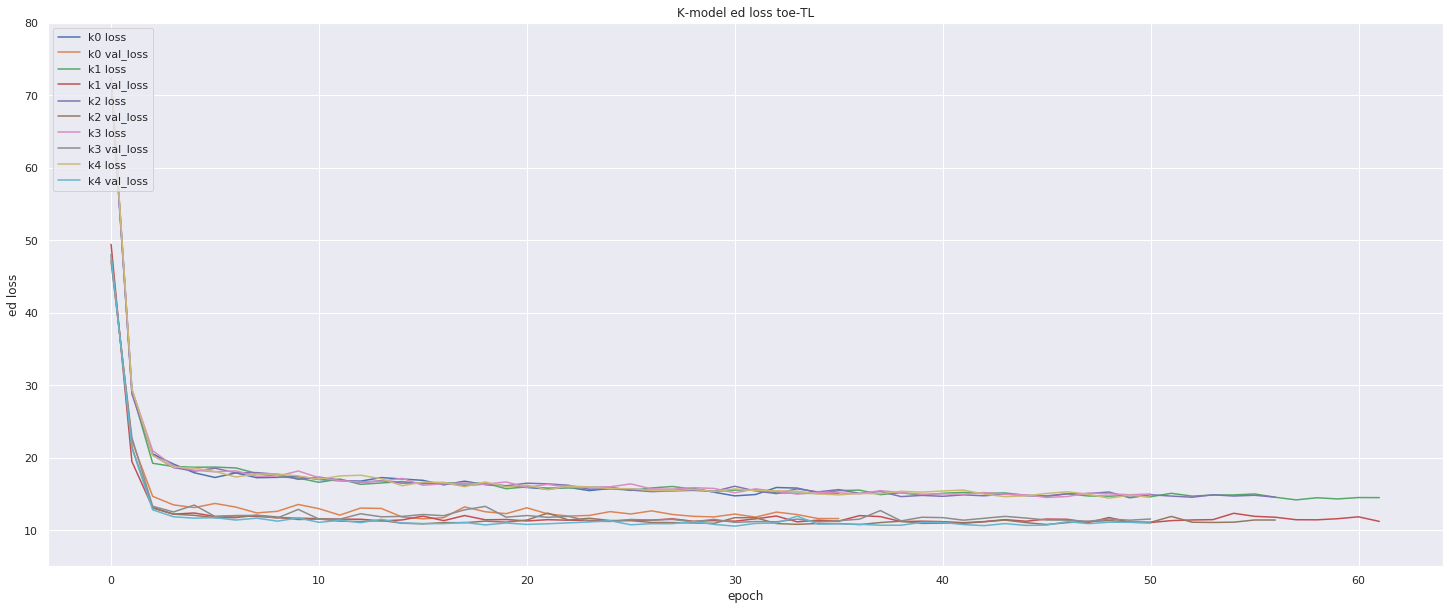

In [97]:
# Sum plot losses toe-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])

    
plt.title('K-model ed loss toe-TL')
plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

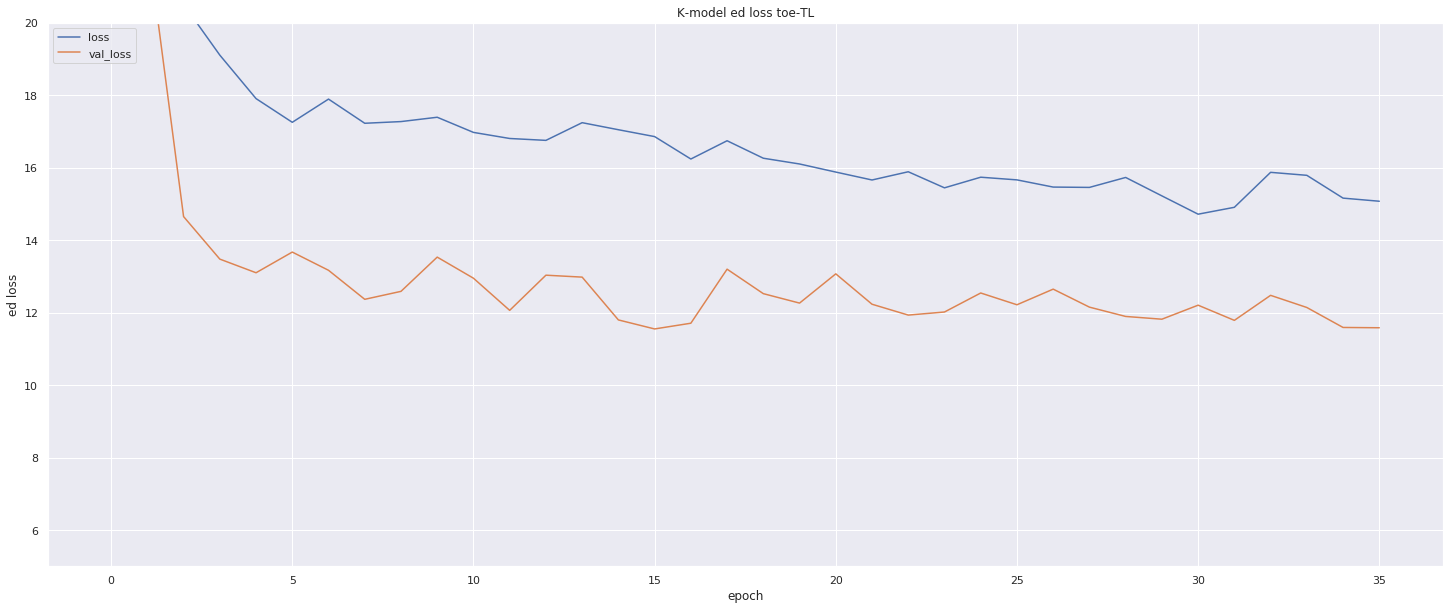

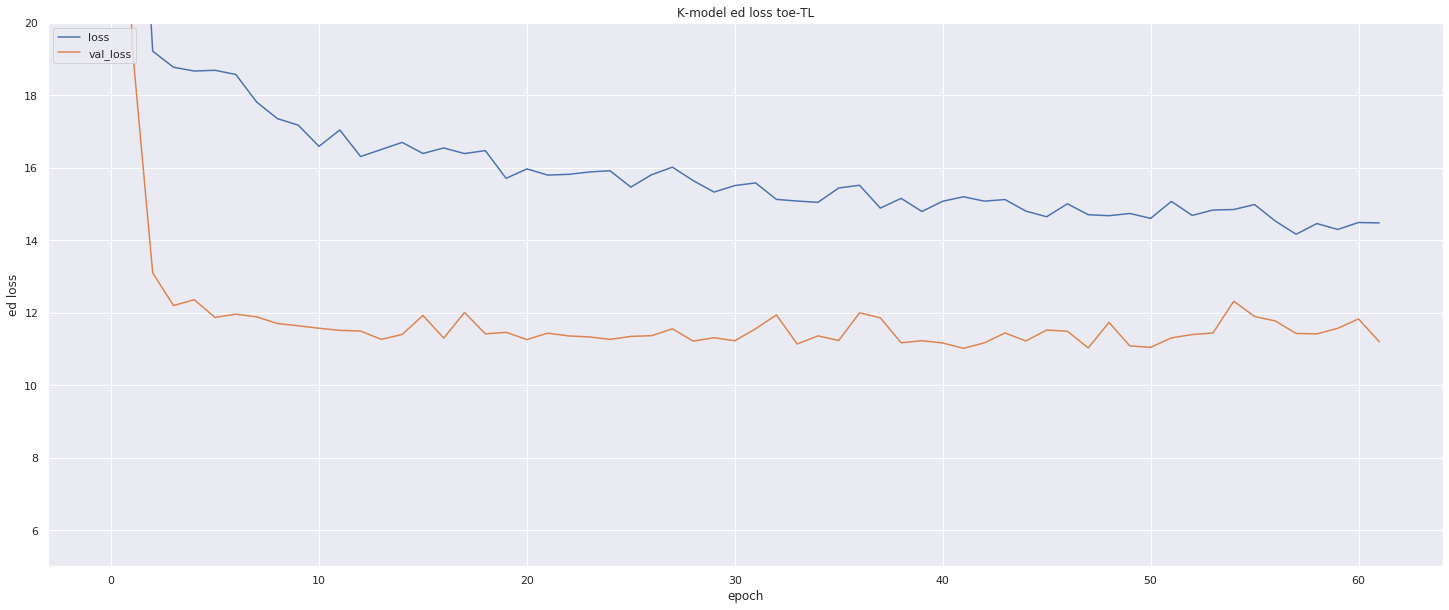

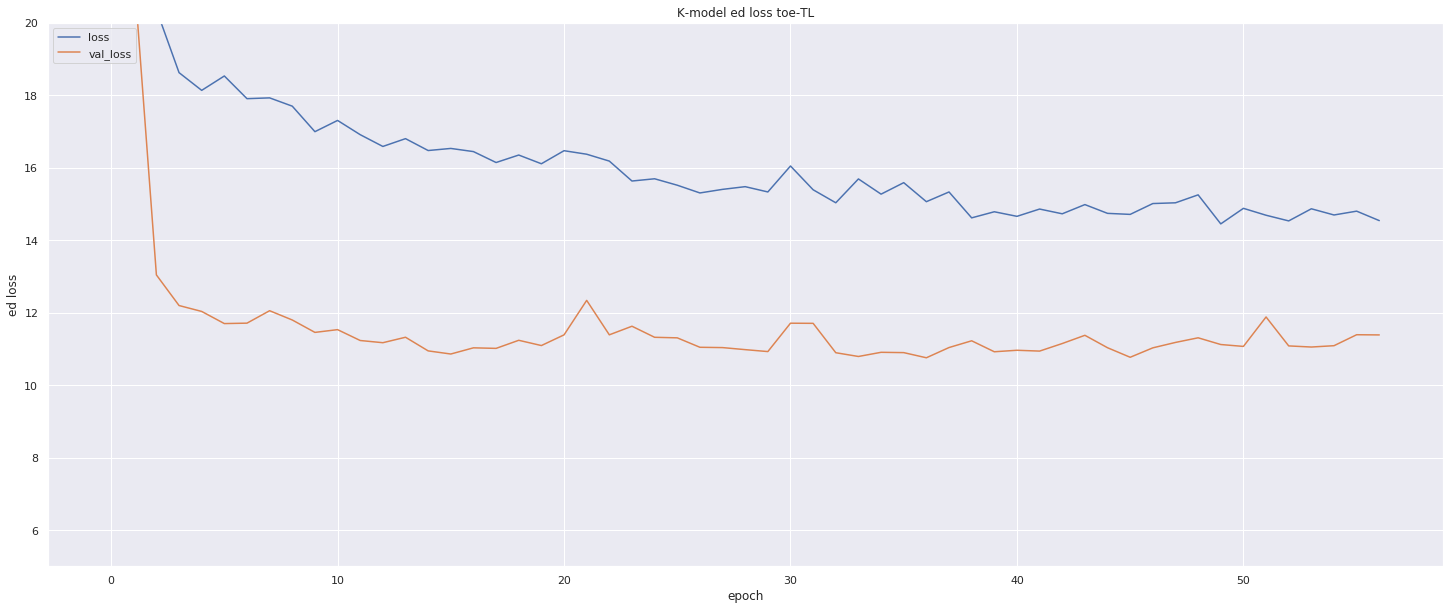

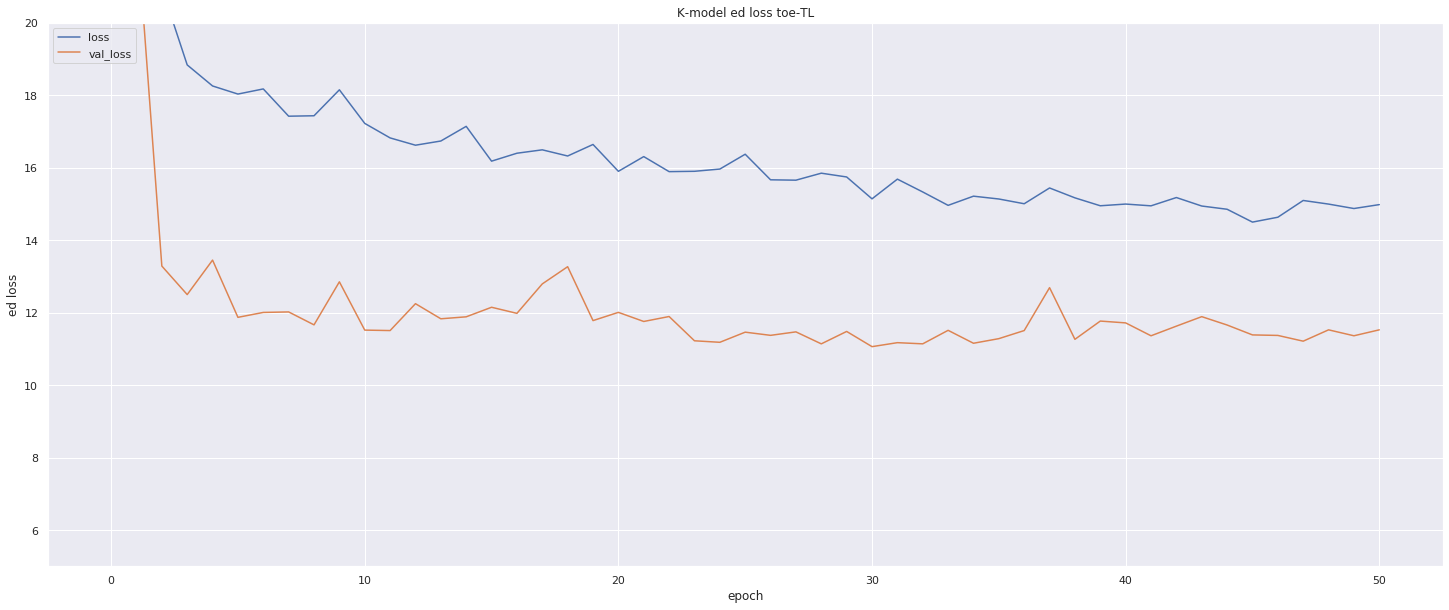

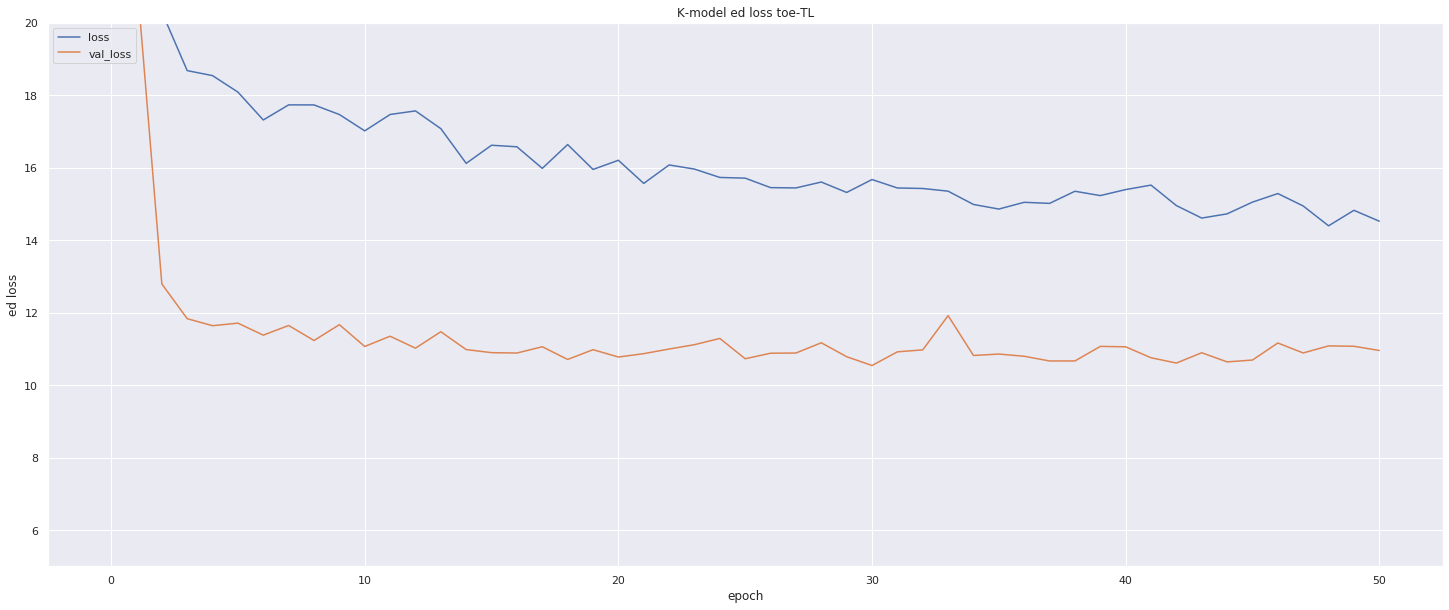

In [98]:
# Single plot loss toe-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])
    plt.title('K-model ed loss toe-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4


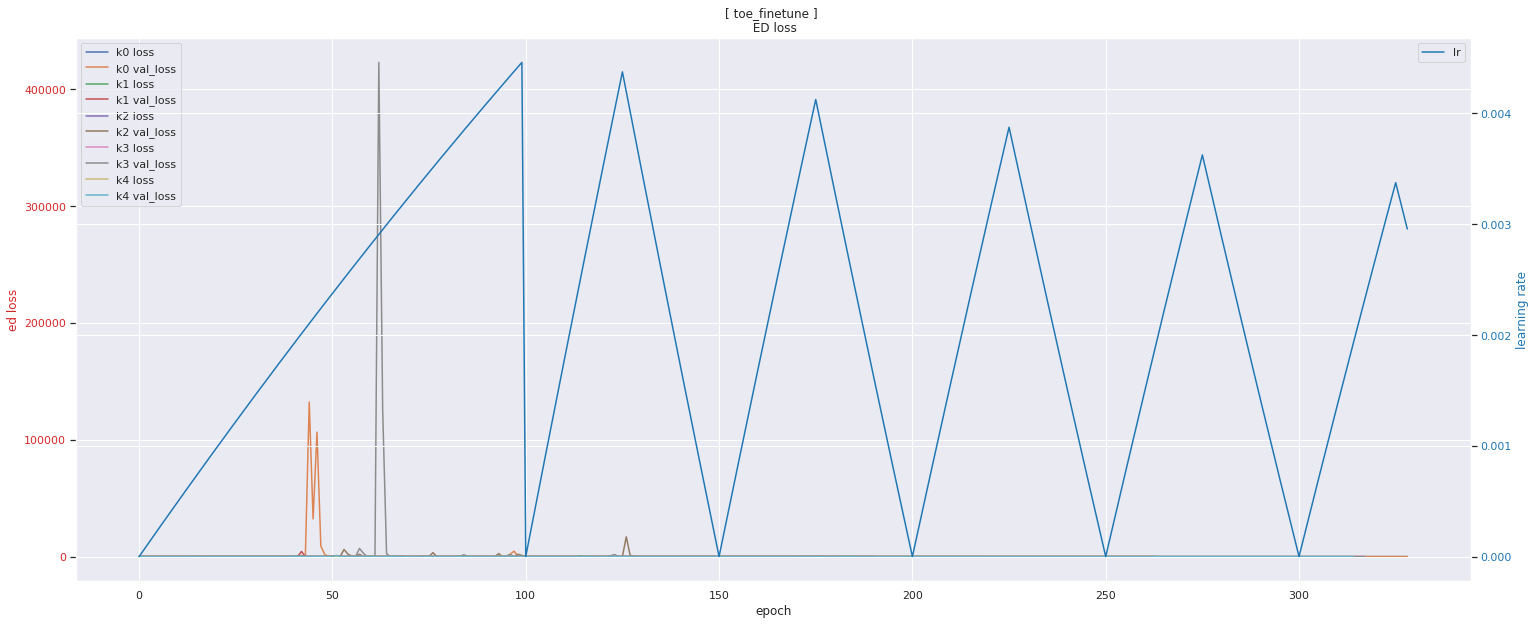

In [99]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


t_vl = np.mean(t_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

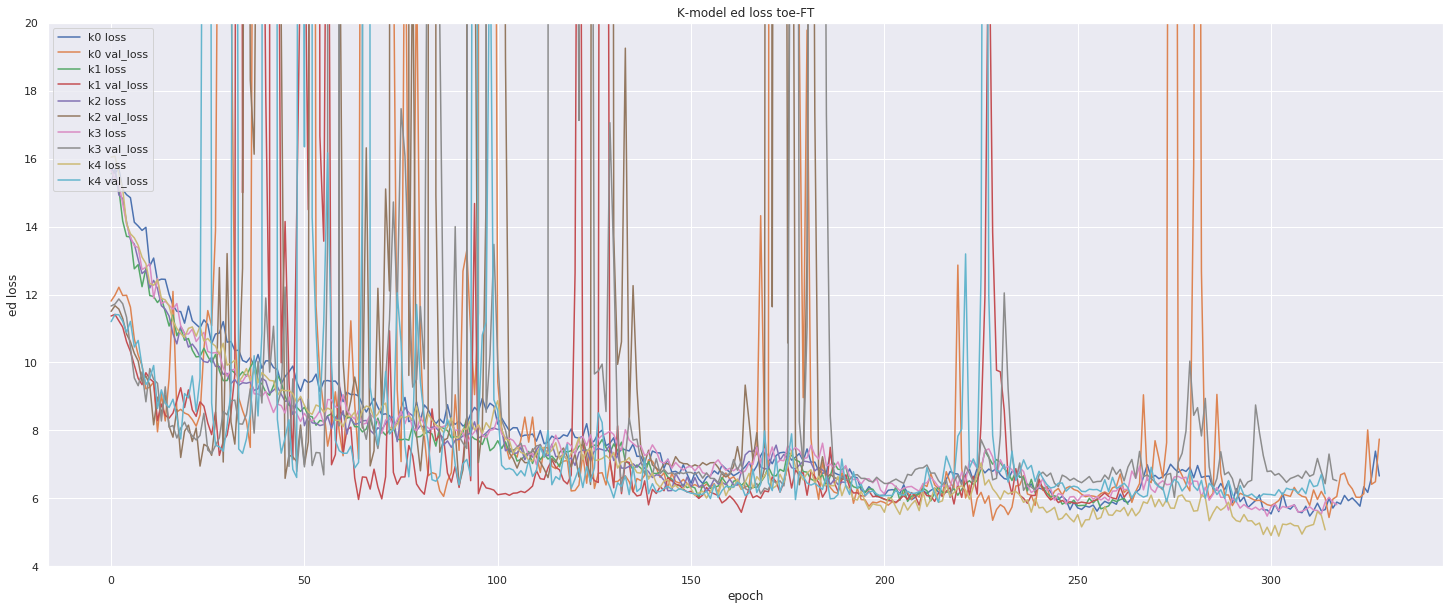

In [100]:
# Sum plot losses toe-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss toe-FT')
plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

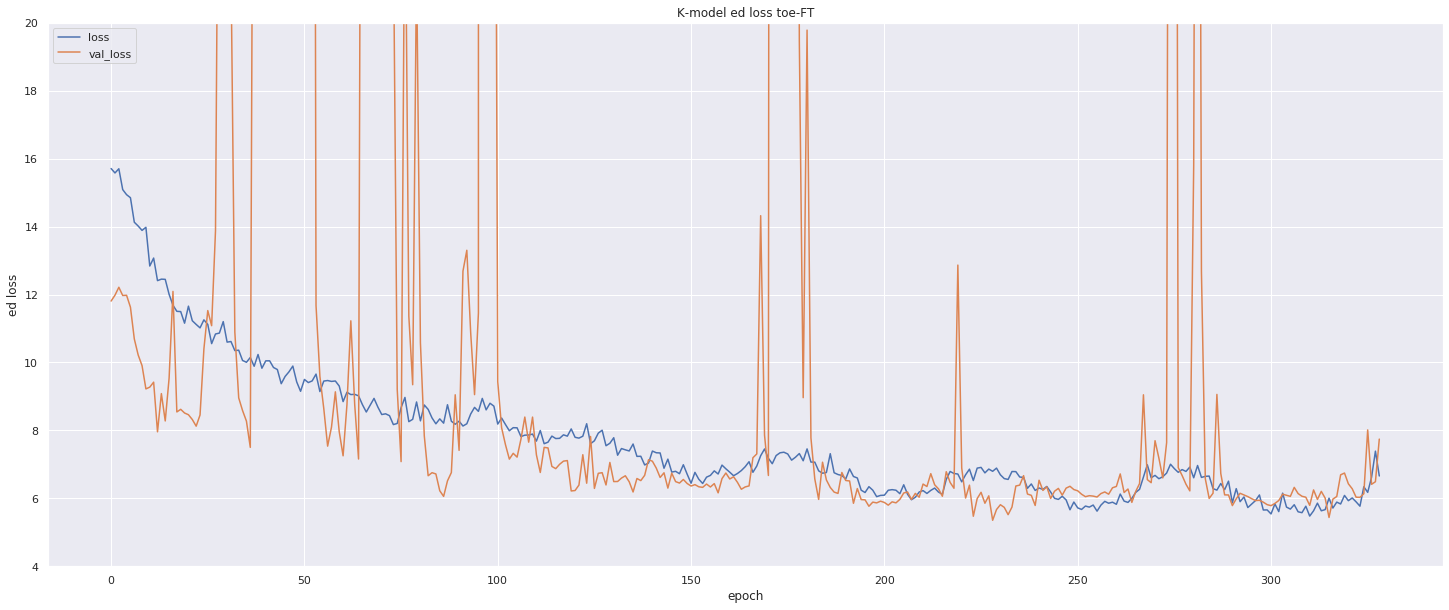

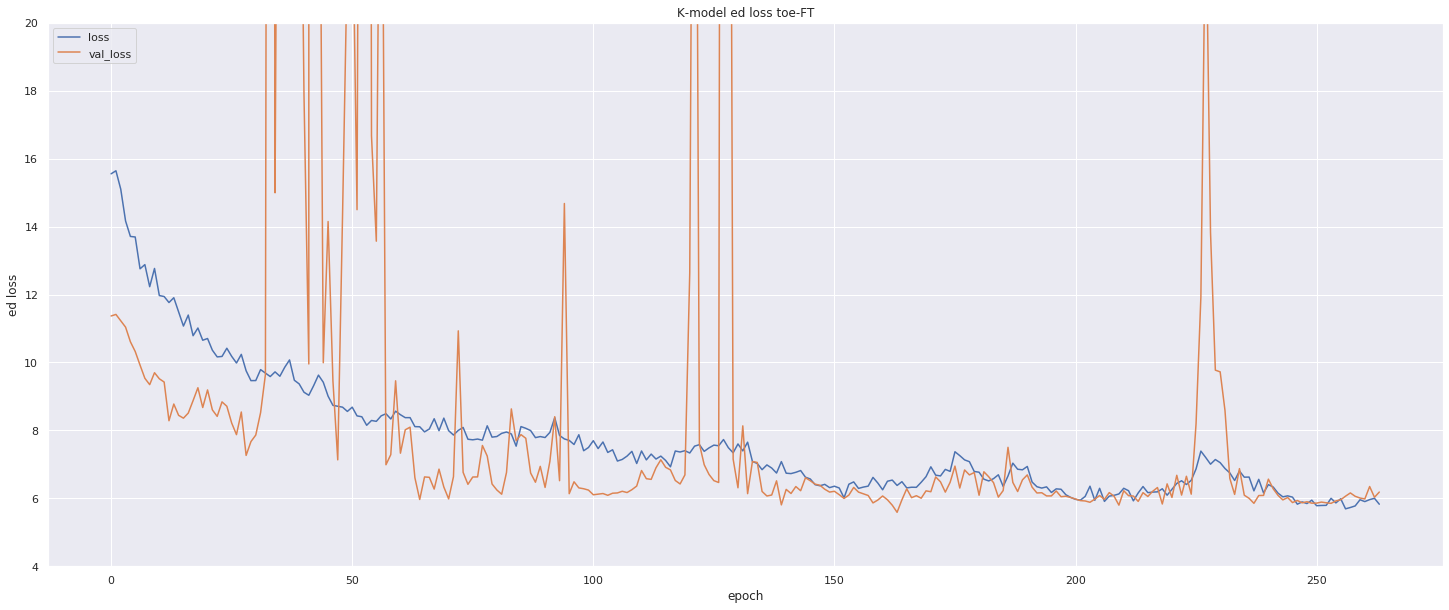

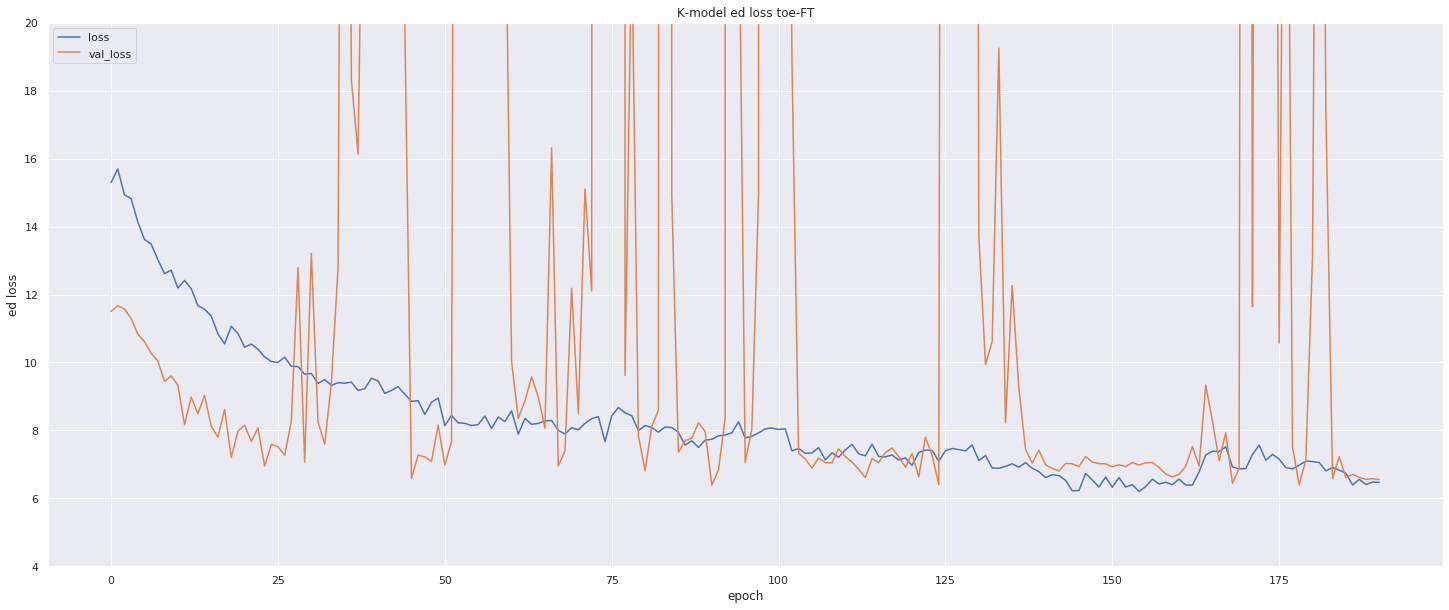

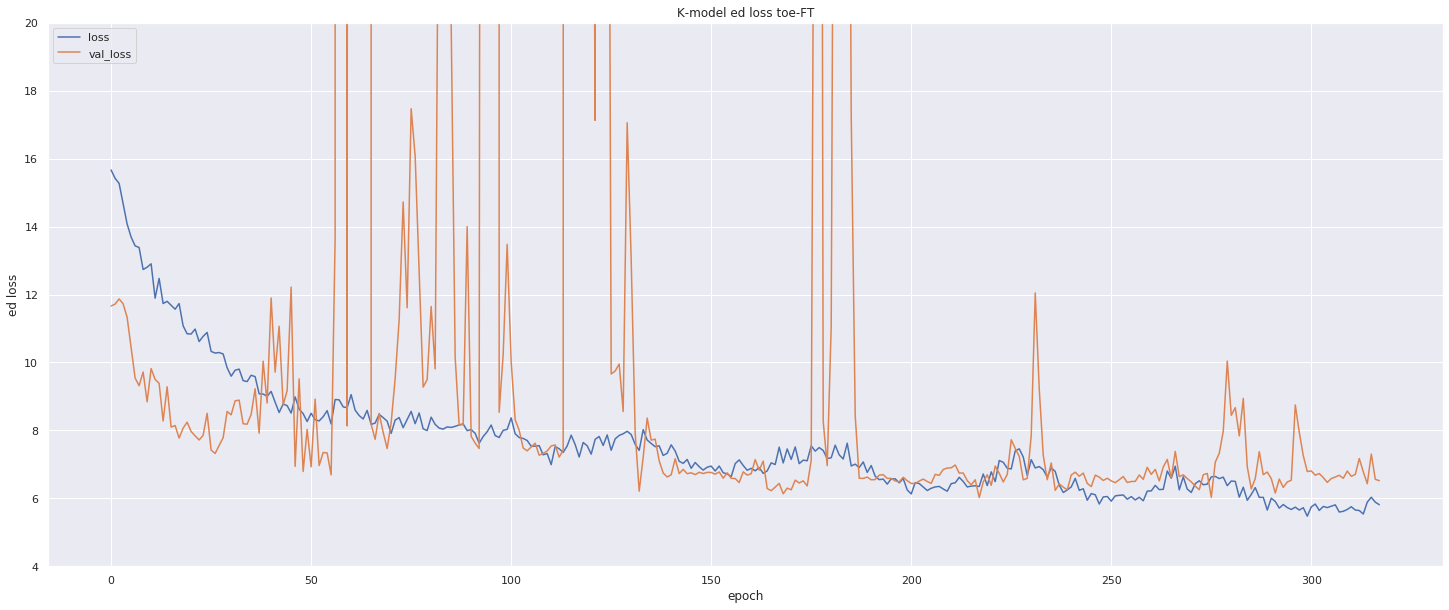

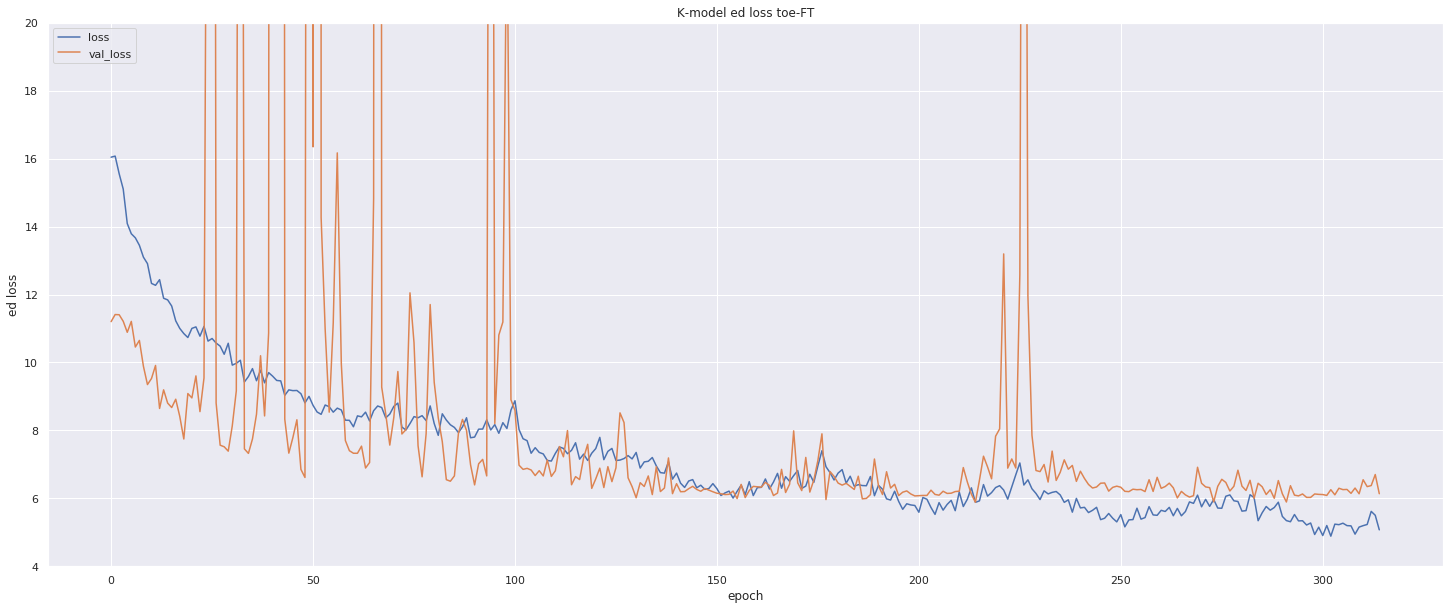

In [101]:
# Single plot loss toe-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])
    plt.title('K-model ed loss toe-FT')
    plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model

In [102]:
%%time

# big K = 5 (fold 0 ~ 4) 
# KFlodNum = 5 # follow Toe's K.



history_heel = []
history_heel_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("K=", k)
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
    # heel split
    train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
    # Heel ds_pre
    train_ds_pre_heel_s = configure_for_performance_cache_train_AToe(train_ds_map_heel_s, augment=True)
    valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    #th = 'toe'
    th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_heel_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_heel_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRheel()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_heel = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_tl)#, validation_split=0.1)
    history_heel.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_heel)
    count_model_trainOrNot_layers(model_heel)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_fn)#, validation_split=0.1)
    history_heel_finetune.append(hist)


K= 0
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
base_model.trainable :  False

[20210228-1710-05] Learning rate for epoch 1 is 0.0019209509482607245
Epoch 1/500
17/17 [==============================] - ETA: 0s - loss: 102.1536
Epoch 00001: val_loss improved from inf to 71.65594, saving model to ./20210228-132845/heel_K0_EfficientNetB7_bs64_w1

17/17 [==============================] - ETA: 0s - loss: 15.1289
Epoch 00021: val_loss did not improve from 14.29285
17/17 [==============================] - 2s 102ms/step - loss: 15.1289 - val_loss: 14.6956

[20210228-1713-44] Learning rate for epoch 22 is 0.0019209509482607245
Epoch 22/500
17/17 [==============================] - ETA: 0s - loss: 15.5844
Epoch 00022: val_loss improved from 14.29285 to 14.02782, saving model to ./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 171ms/step - loss: 15.5844 - val_loss: 14.0278

[20210228-1713-49] Learning rate for epoch 23 is 0.0019209509482607245
Epoch 23/500
17/17 [==============================] - ETA: 0s - loss: 15.6473
Epoch 00023: val_loss improved from 14.02782 to 13.93371, saving model to ./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 170ms/step - loss: 15.6473 - val_loss: 13.9337

[20210228-1713-56] Learni


[20210228-1715-55] Learning rate for epoch 47 is 0.0019209509482607245
Epoch 47/500
17/17 [==============================] - ETA: 0s - loss: 15.0325
Epoch 00047: val_loss improved from 9.02583 to 8.77068, saving model to ./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 173ms/step - loss: 15.0325 - val_loss: 8.7707

[20210228-1716-01] Learning rate for epoch 48 is 0.0019209509482607245
Epoch 48/500
17/17 [==============================] - ETA: 0s - loss: 15.1051
Epoch 00048: val_loss did not improve from 8.77068
17/17 [==============================] - 2s 102ms/step - loss: 15.1051 - val_loss: 9.2922

[20210228-1716-06] Learning rate for epoch 49 is 0.0019209509482607245
Epoch 49/500
17/17 [==============================] - ETA: 0s - loss: 15.1491
Epoch 00049: val_loss did not improve from 8.77068
17/17 [==============================] - 2s 104ms/step - loss: 15.1491 - val_loss: 8.8768

[20210228-1716-11] Learning rate for 

17/17 [==============================] - ETA: 0s - loss: 14.6797
Epoch 00074: val_loss did not improve from 8.11221
17/17 [==============================] - 2s 101ms/step - loss: 14.6797 - val_loss: 9.4501

[20210228-1718-14] Learning rate for epoch 75 is 0.0019209509482607245
Epoch 75/500
17/17 [==============================] - ETA: 0s - loss: 14.4425
Epoch 00075: val_loss did not improve from 8.11221
17/17 [==============================] - 2s 108ms/step - loss: 14.4425 - val_loss: 8.8181

[20210228-1718-19] Learning rate for epoch 76 is 0.0019209509482607245
Epoch 76/500
17/17 [==============================] - ETA: 0s - loss: 13.9333
Epoch 00076: val_loss did not improve from 8.11221
17/17 [==============================] - 2s 103ms/step - loss: 13.9333 - val_loss: 10.0056

[20210228-1718-24] Learning rate for epoch 77 is 0.0019209509482607245
Epoch 77/500
17/17 [==============================] - ETA: 0s - loss: 15.3353
Epoch 00077: val_loss did not improve from 8.11221
17/17 [===

Epoch 17/1000
17/17 [==============================] - ETA: 0s - loss: 9.4396
Epoch 00017: val_loss did not improve from 8.06933

[20210228-1724-22] Learning rate for epoch 17 is 0.0007876132731325924
17/17 [==============================] - 4s 261ms/step - loss: 9.4396 - val_loss: 9.3564
Epoch 18/1000
17/17 [==============================] - ETA: 0s - loss: 9.5227
Epoch 00018: val_loss did not improve from 8.06933

[20210228-1724-30] Learning rate for epoch 18 is 0.0008359579369425774
17/17 [==============================] - 4s 261ms/step - loss: 9.5227 - val_loss: 28.5788
Epoch 19/1000
17/17 [==============================] - ETA: 0s - loss: 8.9545
Epoch 00019: val_loss did not improve from 8.06933

[20210228-1724-37] Learning rate for epoch 19 is 0.000884202599991113
17/17 [==============================] - 4s 260ms/step - loss: 8.9545 - val_loss: 12.0378
Epoch 20/1000
17/17 [==============================] - ETA: 0s - loss: 7.7094
Epoch 00020: val_loss did not improve from 8.06933


17/17 [==============================] - ETA: 0s - loss: 7.0171
Epoch 00044: val_loss did not improve from 5.39693

[20210228-1727-56] Learning rate for epoch 44 is 0.0020578226540237665
17/17 [==============================] - 4s 262ms/step - loss: 7.0171 - val_loss: 57.5042
Epoch 45/1000
17/17 [==============================] - ETA: 0s - loss: 6.8129
Epoch 00045: val_loss did not improve from 5.39693

[20210228-1728-04] Learning rate for epoch 45 is 0.0021034677047282457
17/17 [==============================] - 4s 261ms/step - loss: 6.8129 - val_loss: 6.7322
Epoch 46/1000
17/17 [==============================] - ETA: 0s - loss: 7.0206
Epoch 00046: val_loss improved from 5.39693 to 4.76627, saving model to ./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5

[20210228-1728-14] Learning rate for epoch 46 is 0.002149012638255954
17/17 [==============================] - 7s 386ms/step - loss: 7.0206 - val_loss: 4.7663
Epoch 47/1000
17/17 [==============================] - 

Epoch 71/1000
17/17 [==============================] - ETA: 0s - loss: 6.8526
Epoch 00071: val_loss did not improve from 3.89217

[20210228-1731-35] Learning rate for epoch 71 is 0.003255139570683241
17/17 [==============================] - 4s 260ms/step - loss: 6.8526 - val_loss: 7.3503
Epoch 72/1000
17/17 [==============================] - ETA: 0s - loss: 6.6429
Epoch 00072: val_loss did not improve from 3.89217

[20210228-1731-42] Learning rate for epoch 72 is 0.00329808471724391
17/17 [==============================] - 4s 263ms/step - loss: 6.6429 - val_loss: 5.4981
Epoch 73/1000
17/17 [==============================] - ETA: 0s - loss: 6.9456
Epoch 00073: val_loss did not improve from 3.89217

[20210228-1731-50] Learning rate for epoch 73 is 0.0033409299794584513
17/17 [==============================] - 4s 260ms/step - loss: 6.9456 - val_loss: 5.6166
Epoch 74/1000
17/17 [==============================] - ETA: 0s - loss: 6.8647
Epoch 00074: val_loss did not improve from 3.89217

[20

Epoch 99/1000
17/17 [==============================] - ETA: 0s - loss: 6.9824
Epoch 00099: val_loss did not improve from 3.87818

[20210228-1735-16] Learning rate for epoch 99 is 0.004419809207320213
17/17 [==============================] - 4s 260ms/step - loss: 6.9824 - val_loss: 3587.3828
Epoch 100/1000
17/17 [==============================] - ETA: 0s - loss: 6.4233
Epoch 00100: val_loss did not improve from 3.87818

[20210228-1735-24] Learning rate for epoch 100 is 0.004459954332560301
17/17 [==============================] - 4s 261ms/step - loss: 6.4233 - val_loss: 4.7855
Epoch 101/1000
17/17 [==============================] - ETA: 0s - loss: 7.1518
Epoch 00101: val_loss did not improve from 3.87818

[20210228-1735-31] Learning rate for epoch 101 is 4.4999998749517545e-07
17/17 [==============================] - 4s 262ms/step - loss: 7.1518 - val_loss: 3.9997
Epoch 102/1000
17/17 [==============================] - ETA: 0s - loss: 6.2089
Epoch 00102: val_loss improved from 3.87818 t

Epoch 126/1000
17/17 [==============================] - ETA: 0s - loss: 6.4771
Epoch 00126: val_loss did not improve from 3.29644

[20210228-1738-52] Learning rate for epoch 126 is 0.0043750000186264515
17/17 [==============================] - 4s 260ms/step - loss: 6.4771 - val_loss: 14.1098
Epoch 127/1000
17/17 [==============================] - ETA: 0s - loss: 6.5744
Epoch 00127: val_loss did not improve from 3.29644

[20210228-1739-00] Learning rate for epoch 127 is 0.0041952175088226795
17/17 [==============================] - 4s 260ms/step - loss: 6.5744 - val_loss: 6.8273
Epoch 128/1000
17/17 [==============================] - ETA: 0s - loss: 6.6383
Epoch 00128: val_loss did not improve from 3.29644

[20210228-1739-08] Learning rate for epoch 128 is 0.004015835002064705
17/17 [==============================] - 4s 259ms/step - loss: 6.6383 - val_loss: 5.0051
Epoch 129/1000
17/17 [==============================] - ETA: 0s - loss: 6.4525
Epoch 00129: val_loss did not improve from 3.

17/17 [==============================] - ETA: 0s - loss: 6.0539
Epoch 00154: val_loss improved from 3.29644 to 3.27257, saving model to ./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5

[20210228-1742-30] Learning rate for epoch 154 is 0.0005085726734250784
17/17 [==============================] - 7s 389ms/step - loss: 6.0539 - val_loss: 3.2726
Epoch 155/1000
17/17 [==============================] - ETA: 0s - loss: 5.8061
Epoch 00155: val_loss did not improve from 3.27257

[20210228-1742-37] Learning rate for epoch 155 is 0.0006771553307771683
17/17 [==============================] - 4s 260ms/step - loss: 5.8061 - val_loss: 3.3032
Epoch 156/1000
17/17 [==============================] - ETA: 0s - loss: 5.6476
Epoch 00156: val_loss did not improve from 3.27257

[20210228-1742-45] Learning rate for epoch 156 is 0.0008453379850834608
17/17 [==============================] - 4s 263ms/step - loss: 5.6476 - val_loss: 3.4214
Epoch 157/1000
17/17 [============================

Epoch 182/1000
17/17 [==============================] - ETA: 0s - loss: 5.8851
Epoch 00182: val_loss did not improve from 3.27257

[20210228-1746-05] Learning rate for epoch 182 is 0.0031122982036322355
17/17 [==============================] - 4s 260ms/step - loss: 5.8851 - val_loss: 3.8190
Epoch 183/1000
17/17 [==============================] - ETA: 0s - loss: 6.0185
Epoch 00183: val_loss did not improve from 3.27257

[20210228-1746-13] Learning rate for epoch 183 is 0.002944914624094963
17/17 [==============================] - 4s 260ms/step - loss: 6.0185 - val_loss: 3.6896
Epoch 184/1000
17/17 [==============================] - ETA: 0s - loss: 5.5879
Epoch 00184: val_loss did not improve from 3.27257

[20210228-1746-21] Learning rate for epoch 184 is 0.0027779308147728443
17/17 [==============================] - 4s 260ms/step - loss: 5.5879 - val_loss: 5.6180
Epoch 185/1000
17/17 [==============================] - ETA: 0s - loss: 6.0350
Epoch 00185: val_loss improved from 3.27257 to

Epoch 210/1000
17/17 [==============================] - ETA: 0s - loss: 5.9366
Epoch 00210: val_loss did not improve from 3.16576

[20210228-1749-43] Learning rate for epoch 210 is 0.0014240531018003821
17/17 [==============================] - 4s 260ms/step - loss: 5.9366 - val_loss: 3.7528
Epoch 211/1000
17/17 [==============================] - ETA: 0s - loss: 5.9858
Epoch 00211: val_loss did not improve from 3.16576

[20210228-1749-51] Learning rate for epoch 211 is 0.0015802369453012943
17/17 [==============================] - 5s 266ms/step - loss: 5.9858 - val_loss: 3.6776
Epoch 212/1000
17/17 [==============================] - ETA: 0s - loss: 5.6774
Epoch 00212: val_loss did not improve from 3.16576

[20210228-1749-58] Learning rate for epoch 212 is 0.001736020902171731
17/17 [==============================] - 4s 260ms/step - loss: 5.6774 - val_loss: 3.5464
Epoch 213/1000
17/17 [==============================] - ETA: 0s - loss: 5.9785
Epoch 00213: val_loss did not improve from 3.1

17/17 [==============================] - ETA: 0s - loss: 5.3266
Epoch 00238: val_loss did not improve from 3.16576

[20210228-1753-18] Learning rate for epoch 238 is 0.0019839832093566656
17/17 [==============================] - 4s 262ms/step - loss: 5.3266 - val_loss: 3.3021
Epoch 239/1000
17/17 [==============================] - ETA: 0s - loss: 5.7114
Epoch 00239: val_loss did not improve from 3.16576

[20210228-1753-26] Learning rate for epoch 239 is 0.0018289980944246054
17/17 [==============================] - 4s 261ms/step - loss: 5.7114 - val_loss: 3.3425
Epoch 240/1000
17/17 [==============================] - ETA: 0s - loss: 5.5062
Epoch 00240: val_loss did not improve from 3.16576

[20210228-1753-34] Learning rate for epoch 240 is 0.0016744130989536643
17/17 [==============================] - 4s 259ms/step - loss: 5.5062 - val_loss: 4.3740
Epoch 241/1000
17/17 [==============================] - ETA: 0s - loss: 5.3882
Epoch 00241: val_loss did not improve from 3.16576

[2021022

17/17 [==============================] - ETA: 0s - loss: 6.0109
Epoch 00266: val_loss did not improve from 3.16576

[20210228-1756-53] Learning rate for epoch 266 is 0.0022051469422876835
17/17 [==============================] - 4s 260ms/step - loss: 6.0109 - val_loss: 5.4865
Epoch 267/1000
17/17 [==============================] - ETA: 0s - loss: 5.6425
Epoch 00267: val_loss did not improve from 3.16576

[20210228-1757-01] Learning rate for epoch 267 is 0.0023489322047680616
17/17 [==============================] - 4s 259ms/step - loss: 5.6425 - val_loss: 3.3248
Epoch 268/1000
17/17 [==============================] - ETA: 0s - loss: 5.2914
Epoch 00268: val_loss did not improve from 3.16576

[20210228-1757-09] Learning rate for epoch 268 is 0.002492317231371999
17/17 [==============================] - 4s 260ms/step - loss: 5.2914 - val_loss: 3.7913
Epoch 269/1000
17/17 [==============================] - ETA: 0s - loss: 5.5259
Epoch 00269: val_loss did not improve from 3.16576

[20210228

17/17 [==============================] - ETA: 0s - loss: 18.7833
Epoch 00005: val_loss improved from 22.19466 to 21.45656, saving model to ./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 171ms/step - loss: 18.7833 - val_loss: 21.4566

[20210228-1801-05] Learning rate for epoch 6 is 0.0019209509482607245
Epoch 6/500
17/17 [==============================] - ETA: 0s - loss: 17.7565
Epoch 00006: val_loss improved from 21.45656 to 20.73821, saving model to ./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 174ms/step - loss: 17.7565 - val_loss: 20.7382

[20210228-1801-11] Learning rate for epoch 7 is 0.0019209509482607245
Epoch 7/500
17/17 [==============================] - ETA: 0s - loss: 17.4843
Epoch 00007: val_loss improved from 20.73821 to 20.03050, saving model to ./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [========================


[20210228-1803-12] Learning rate for epoch 28 is 0.0019209509482607245
Epoch 28/500
17/17 [==============================] - ETA: 0s - loss: 14.8682
Epoch 00028: val_loss improved from 12.55755 to 12.50637, saving model to ./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 176ms/step - loss: 14.8682 - val_loss: 12.5064

[20210228-1803-18] Learning rate for epoch 29 is 0.0019209509482607245
Epoch 29/500
17/17 [==============================] - ETA: 0s - loss: 15.1823
Epoch 00029: val_loss improved from 12.50637 to 11.84725, saving model to ./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 179ms/step - loss: 15.1823 - val_loss: 11.8473

[20210228-1803-24] Learning rate for epoch 30 is 0.0019209509482607245
Epoch 30/500
17/17 [==============================] - ETA: 0s - loss: 15.5542
Epoch 00030: val_loss did not improve from 11.84725
17/17 [=========================


[20210228-1805-28] Learning rate for epoch 54 is 0.0019209509482607245
Epoch 54/500
17/17 [==============================] - ETA: 0s - loss: 14.6527
Epoch 00054: val_loss did not improve from 9.04296
17/17 [==============================] - 2s 104ms/step - loss: 14.6527 - val_loss: 10.0773

[20210228-1805-33] Learning rate for epoch 55 is 0.0019209509482607245
Epoch 55/500
17/17 [==============================] - ETA: 0s - loss: 14.9021
Epoch 00055: val_loss did not improve from 9.04296
17/17 [==============================] - 2s 102ms/step - loss: 14.9021 - val_loss: 9.1442

[20210228-1805-37] Learning rate for epoch 56 is 0.0019209509482607245
Epoch 56/500
17/17 [==============================] - ETA: 0s - loss: 14.8224
Epoch 00056: val_loss improved from 9.04296 to 8.73198, saving model to ./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 7s 415ms/step - loss: 14.8224 - val_loss: 8.7320

[20210228-1805-48] Learning rate for


[20210228-1807-50] Learning rate for epoch 82 is 0.0019209509482607245
Epoch 82/500
17/17 [==============================] - ETA: 0s - loss: 14.4773
Epoch 00082: val_loss did not improve from 8.34431
17/17 [==============================] - 2s 101ms/step - loss: 14.4773 - val_loss: 9.1786

[20210228-1807-55] Learning rate for epoch 83 is 0.0019209509482607245
Epoch 83/500
17/17 [==============================] - ETA: 0s - loss: 14.3412
Epoch 00083: val_loss did not improve from 8.34431
17/17 [==============================] - 2s 102ms/step - loss: 14.3412 - val_loss: 9.4276

[20210228-1808-00] Learning rate for epoch 84 is 0.0019209509482607245
Epoch 84/500
17/17 [==============================] - ETA: 0s - loss: 15.2635
Epoch 00084: val_loss did not improve from 8.34431
17/17 [==============================] - 2s 101ms/step - loss: 15.2635 - val_loss: 9.5864

[20210228-1808-04] Learning rate for epoch 85 is 0.0019209509482607245
Epoch 85/500
17/17 [==============================] - E

Epoch 20/1000
17/17 [==============================] - ETA: 0s - loss: 8.8601
Epoch 00020: val_loss did not improve from 7.25161

[20210228-1813-34] Learning rate for epoch 20 is 0.0009323473204858601
17/17 [==============================] - 4s 259ms/step - loss: 8.8601 - val_loss: 106.7044
Epoch 21/1000
17/17 [==============================] - ETA: 0s - loss: 8.3501
Epoch 00021: val_loss did not improve from 7.25161

[20210228-1813-42] Learning rate for epoch 21 is 0.000980391982011497
17/17 [==============================] - 4s 261ms/step - loss: 8.3501 - val_loss: 72.7540
Epoch 22/1000
17/17 [==============================] - ETA: 0s - loss: 7.9918
Epoch 00022: val_loss did not improve from 7.25161

[20210228-1813-50] Learning rate for epoch 22 is 0.0010283367009833455
17/17 [==============================] - 4s 260ms/step - loss: 7.9918 - val_loss: 18.9013
Epoch 23/1000
17/17 [==============================] - ETA: 0s - loss: 7.5238
Epoch 00023: val_loss did not improve from 7.2516

Epoch 48/1000
17/17 [==============================] - ETA: 0s - loss: 7.8093
Epoch 00048: val_loss did not improve from 4.49121

[20210228-1817-14] Learning rate for epoch 48 is 0.0022398026194423437
17/17 [==============================] - 4s 260ms/step - loss: 7.8093 - val_loss: 7.9149
Epoch 49/1000
17/17 [==============================] - ETA: 0s - loss: 7.5018
Epoch 00049: val_loss did not improve from 4.49121

[20210228-1817-21] Learning rate for epoch 49 is 0.002285047434270382
17/17 [==============================] - 4s 261ms/step - loss: 7.5018 - val_loss: 6.7907
Epoch 50/1000
17/17 [==============================] - ETA: 0s - loss: 7.8711
Epoch 00050: val_loss did not improve from 4.49121

[20210228-1817-29] Learning rate for epoch 50 is 0.0023301925975829363
17/17 [==============================] - 4s 261ms/step - loss: 7.8711 - val_loss: 29.3112
Epoch 51/1000
17/17 [==============================] - ETA: 0s - loss: 8.1234
Epoch 00051: val_loss did not improve from 4.49121



17/17 [==============================] - ETA: 0s - loss: 7.3549
Epoch 00076: val_loss did not improve from 4.49121

[20210228-1820-49] Learning rate for epoch 76 is 0.003468865528702736
17/17 [==============================] - 4s 260ms/step - loss: 7.3549 - val_loss: 19.7174
Epoch 77/1000
17/17 [==============================] - ETA: 0s - loss: 7.1624
Epoch 00077: val_loss did not improve from 4.49121

[20210228-1820-56] Learning rate for epoch 77 is 0.00351131078787148
17/17 [==============================] - 4s 260ms/step - loss: 7.1624 - val_loss: 7.8935
Epoch 78/1000
17/17 [==============================] - ETA: 0s - loss: 7.1284
Epoch 00078: val_loss did not improve from 4.49121

[20210228-1821-04] Learning rate for epoch 78 is 0.0035536561626940966
17/17 [==============================] - 4s 259ms/step - loss: 7.1284 - val_loss: 16.5250
Epoch 79/1000
17/17 [==============================] - ETA: 0s - loss: 7.1217
Epoch 00079: val_loss did not improve from 4.49121

[20210228-1821-

Epoch 103/1000
17/17 [==============================] - ETA: 0s - loss: 5.8282
Epoch 00103: val_loss did not improve from 3.58258

[20210228-1824-25] Learning rate for epoch 103 is 0.000359613070031628
17/17 [==============================] - 4s 261ms/step - loss: 5.8282 - val_loss: 3.6876
Epoch 104/1000
17/17 [==============================] - ETA: 0s - loss: 5.9590
Epoch 00104: val_loss did not improve from 3.58258

[20210228-1824-33] Learning rate for epoch 104 is 0.0005385946715250611
17/17 [==============================] - 4s 261ms/step - loss: 5.9590 - val_loss: 3.6484
Epoch 105/1000
17/17 [==============================] - ETA: 0s - loss: 6.0224
Epoch 00105: val_loss did not improve from 3.58258

[20210228-1824-40] Learning rate for epoch 105 is 0.0007171762990765274
17/17 [==============================] - 4s 259ms/step - loss: 6.0224 - val_loss: 4.0837
Epoch 106/1000
17/17 [==============================] - ETA: 0s - loss: 6.1773
Epoch 00106: val_loss did not improve from 3.5

17/17 [==============================] - ETA: 0s - loss: 6.3130
Epoch 00131: val_loss did not improve from 3.58258

[20210228-1828-01] Learning rate for epoch 131 is 0.003480087034404278
17/17 [==============================] - 4s 261ms/step - loss: 6.3130 - val_loss: 4.1435
Epoch 132/1000
17/17 [==============================] - ETA: 0s - loss: 6.2970
Epoch 00132: val_loss did not improve from 3.58258

[20210228-1828-09] Learning rate for epoch 132 is 0.003302304306998849
17/17 [==============================] - 4s 259ms/step - loss: 6.2970 - val_loss: 7.7259
Epoch 133/1000
17/17 [==============================] - ETA: 0s - loss: 6.8506
Epoch 00133: val_loss did not improve from 3.58258

[20210228-1828-16] Learning rate for epoch 133 is 0.0031249215826392174
17/17 [==============================] - 4s 260ms/step - loss: 6.8506 - val_loss: 252.8126
Epoch 134/1000
17/17 [==============================] - ETA: 0s - loss: 6.5483
Epoch 00134: val_loss did not improve from 3.58258

[2021022

Epoch 159/1000
17/17 [==============================] - ETA: 0s - loss: 5.4854
Epoch 00159: val_loss did not improve from 3.49765

[20210228-1831-39] Learning rate for epoch 159 is 0.0013474862789735198
17/17 [==============================] - 4s 261ms/step - loss: 5.4854 - val_loss: 3.7293
Epoch 160/1000
17/17 [==============================] - ETA: 0s - loss: 5.8744
Epoch 00160: val_loss did not improve from 3.49765

[20210228-1831-46] Learning rate for epoch 160 is 0.0015140691539272666
17/17 [==============================] - 4s 260ms/step - loss: 5.8744 - val_loss: 4.0018
Epoch 161/1000
17/17 [==============================] - ETA: 0s - loss: 6.0772
Epoch 00161: val_loss did not improve from 3.49765

[20210228-1831-54] Learning rate for epoch 161 is 0.001680252025835216
17/17 [==============================] - 4s 260ms/step - loss: 6.0772 - val_loss: 3.6270
Epoch 162/1000
17/17 [==============================] - ETA: 0s - loss: 6.1806
Epoch 00162: val_loss did not improve from 3.4

17/17 [==============================] - ETA: 0s - loss: 6.0493
Epoch 00187: val_loss did not improve from 3.49765

[20210228-1835-13] Learning rate for epoch 187 is 0.0022793791722506285
17/17 [==============================] - 4s 260ms/step - loss: 6.0493 - val_loss: 13.1002
Epoch 188/1000
17/17 [==============================] - ETA: 0s - loss: 6.1719
Epoch 00188: val_loss did not improve from 3.49765

[20210228-1835-21] Learning rate for epoch 188 is 0.0021139951422810555
17/17 [==============================] - 4s 260ms/step - loss: 6.1719 - val_loss: 4.3573
Epoch 189/1000
17/17 [==============================] - ETA: 0s - loss: 5.6481
Epoch 00189: val_loss did not improve from 3.49765

[20210228-1835-29] Learning rate for epoch 189 is 0.0019490111153572798
17/17 [==============================] - 4s 260ms/step - loss: 5.6481 - val_loss: 4.2942
Epoch 190/1000
17/17 [==============================] - ETA: 0s - loss: 5.6363
Epoch 00190: val_loss did not improve from 3.49765

[202102

17/17 [==============================] - ETA: 0s - loss: 5.4748
Epoch 00215: val_loss did not improve from 3.49765

[20210228-1838-49] Learning rate for epoch 215 is 0.0022009729873389006
17/17 [==============================] - 4s 260ms/step - loss: 5.4748 - val_loss: 4.1212
Epoch 216/1000
17/17 [==============================] - ETA: 0s - loss: 5.4567
Epoch 00216: val_loss did not improve from 3.49765

[20210228-1838-56] Learning rate for epoch 216 is 0.002355156932026148
17/17 [==============================] - 4s 260ms/step - loss: 5.4567 - val_loss: 4.7374
Epoch 217/1000
17/17 [==============================] - ETA: 0s - loss: 5.9931
Epoch 00217: val_loss did not improve from 3.49765

[20210228-1839-04] Learning rate for epoch 217 is 0.0025089411064982414
17/17 [==============================] - 4s 260ms/step - loss: 5.9931 - val_loss: 4.8176
Epoch 218/1000
17/17 [==============================] - ETA: 0s - loss: 5.8157
Epoch 00218: val_loss did not improve from 3.49765

[20210228

Epoch 243/1000
17/17 [==============================] - ETA: 0s - loss: 5.5983
Epoch 00243: val_loss did not improve from 3.48128

[20210228-1842-26] Learning rate for epoch 243 is 0.0012130576651543379
17/17 [==============================] - 4s 259ms/step - loss: 5.5983 - val_loss: 3.6897
Epoch 244/1000
17/17 [==============================] - ETA: 0s - loss: 6.3173
Epoch 00244: val_loss did not improve from 3.48128

[20210228-1842-34] Learning rate for epoch 244 is 0.0010600725654512644
17/17 [==============================] - 4s 261ms/step - loss: 6.3173 - val_loss: 4.0907
Epoch 245/1000
17/17 [==============================] - ETA: 0s - loss: 5.3470
Epoch 00245: val_loss did not improve from 3.48128

[20210228-1842-41] Learning rate for epoch 245 is 0.0009074872941710055
17/17 [==============================] - 4s 261ms/step - loss: 5.3470 - val_loss: 4.0710
Epoch 246/1000
17/17 [==============================] - ETA: 0s - loss: 4.9304
Epoch 00246: val_loss did not improve from 3.

17/17 [==============================] - ETA: 0s - loss: 5.9466
Epoch 00271: val_loss did not improve from 3.48128

[20210228-1846-01] Learning rate for epoch 271 is 0.002920072991400957
17/17 [==============================] - 4s 259ms/step - loss: 5.9466 - val_loss: 3.6517
Epoch 272/1000
17/17 [==============================] - ETA: 0s - loss: 5.5494
Epoch 00272: val_loss did not improve from 3.48128

[20210228-1846-09] Learning rate for epoch 272 is 0.0030618582386523485
17/17 [==============================] - 5s 265ms/step - loss: 5.5494 - val_loss: 4.5553
Epoch 273/1000
17/17 [==============================] - ETA: 0s - loss: 5.9534
Epoch 00273: val_loss did not improve from 3.48128

[20210228-1846-17] Learning rate for epoch 273 is 0.0032032437156885862
17/17 [==============================] - 4s 261ms/step - loss: 5.9534 - val_loss: 4.8470
Epoch 274/1000
17/17 [==============================] - ETA: 0s - loss: 5.4070
Epoch 00274: val_loss did not improve from 3.48128

[20210228

17/17 [==============================] - ETA: 0s - loss: 5.2093
Epoch 00299: val_loss did not improve from 3.48128

[20210228-1849-42] Learning rate for epoch 299 is 0.00028112292056903243
17/17 [==============================] - 4s 262ms/step - loss: 5.2093 - val_loss: 3.6472
Epoch 300/1000
17/17 [==============================] - ETA: 0s - loss: 5.6993
Epoch 00300: val_loss did not improve from 3.48128

[20210228-1849-49] Learning rate for epoch 300 is 0.0001405364746460691
17/17 [==============================] - 5s 267ms/step - loss: 5.6993 - val_loss: 3.6637
Epoch 301/1000
17/17 [==============================] - ETA: 0s - loss: 5.4924
Epoch 00301: val_loss did not improve from 3.48128

[20210228-1849-57] Learning rate for epoch 301 is 3.4999999343199306e-07
17/17 [==============================] - 4s 262ms/step - loss: 5.4924 - val_loss: 3.6212
Epoch 302/1000
17/17 [==============================] - ETA: 0s - loss: 5.2110
Epoch 00302: val_loss did not improve from 3.48128

[20210

17/17 [==============================] - ETA: 0s - loss: 38.5119
Epoch 00002: val_loss improved from 66.65598 to 25.71330, saving model to ./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 173ms/step - loss: 38.5119 - val_loss: 25.7133

[20210228-1853-40] Learning rate for epoch 3 is 0.0019209509482607245
Epoch 3/500
17/17 [==============================] - ETA: 0s - loss: 23.5904
Epoch 00003: val_loss improved from 25.71330 to 23.78889, saving model to ./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 20s 1s/step - loss: 23.5904 - val_loss: 23.7889

[20210228-1854-03] Learning rate for epoch 4 is 0.0019209509482607245
Epoch 4/500
17/17 [==============================] - ETA: 0s - loss: 20.1501
Epoch 00004: val_loss improved from 23.78889 to 22.45599, saving model to ./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==========================

17/17 [==============================] - ETA: 0s - loss: 14.8894
Epoch 00024: val_loss improved from 13.92705 to 13.10169, saving model to ./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 177ms/step - loss: 14.8894 - val_loss: 13.1017

[20210228-1856-07] Learning rate for epoch 25 is 0.0019209509482607245
Epoch 25/500
17/17 [==============================] - ETA: 0s - loss: 15.5521
Epoch 00025: val_loss did not improve from 13.10169
17/17 [==============================] - 2s 102ms/step - loss: 15.5521 - val_loss: 14.7543

[20210228-1856-12] Learning rate for epoch 26 is 0.0019209509482607245
Epoch 26/500
17/17 [==============================] - ETA: 0s - loss: 15.8243
Epoch 00026: val_loss improved from 13.10169 to 12.91769, saving model to ./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 172ms/step - loss: 15.8243 - val_loss: 12.9177

[20210228-1856-18] Learni


[20210228-1858-16] Learning rate for epoch 49 is 0.0019209509482607245
Epoch 49/500
17/17 [==============================] - ETA: 0s - loss: 14.7129
Epoch 00049: val_loss did not improve from 8.72783
17/17 [==============================] - 2s 101ms/step - loss: 14.7129 - val_loss: 10.4868

[20210228-1858-21] Learning rate for epoch 50 is 0.0019209509482607245
Epoch 50/500
17/17 [==============================] - ETA: 0s - loss: 15.2434
Epoch 00050: val_loss did not improve from 8.72783
17/17 [==============================] - 2s 105ms/step - loss: 15.2434 - val_loss: 9.6933

[20210228-1858-26] Learning rate for epoch 51 is 0.0019209509482607245
Epoch 51/500
17/17 [==============================] - ETA: 0s - loss: 15.0231
Epoch 00051: val_loss did not improve from 8.72783
17/17 [==============================] - 2s 105ms/step - loss: 15.0231 - val_loss: 9.5942

[20210228-1858-31] Learning rate for epoch 52 is 0.0019209509482607245
Epoch 52/500
17/17 [==============================] - 


[20210228-1900-31] Learning rate for epoch 76 is 0.0019209509482607245
Epoch 76/500
17/17 [==============================] - ETA: 0s - loss: 14.3023
Epoch 00076: val_loss did not improve from 8.32571
17/17 [==============================] - 2s 106ms/step - loss: 14.3023 - val_loss: 9.6977

[20210228-1900-36] Learning rate for epoch 77 is 0.0019209509482607245
Epoch 77/500
17/17 [==============================] - ETA: 0s - loss: 14.6638
Epoch 00077: val_loss did not improve from 8.32571
17/17 [==============================] - 2s 106ms/step - loss: 14.6638 - val_loss: 9.4786

[20210228-1900-41] Learning rate for epoch 78 is 0.0019209509482607245
Epoch 78/500
17/17 [==============================] - ETA: 0s - loss: 13.8306
Epoch 00078: val_loss did not improve from 8.32571
17/17 [==============================] - 2s 109ms/step - loss: 13.8306 - val_loss: 9.4857

[20210228-1900-46] Learning rate for epoch 79 is 0.0019209509482607245
Epoch 79/500
17/17 [==============================] - E

Epoch 9/1000
17/17 [==============================] - ETA: 0s - loss: 13.1362
Epoch 00009: val_loss did not improve from 8.32571

[20210228-1905-37] Learning rate for epoch 9 is 0.00039725631359033287
17/17 [==============================] - 4s 263ms/step - loss: 13.1362 - val_loss: 8.8104
Epoch 10/1000
17/17 [==============================] - ETA: 0s - loss: 12.4412
Epoch 00010: val_loss improved from 8.32571 to 6.70857, saving model to ./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5

[20210228-1905-52] Learning rate for epoch 10 is 0.0004464008961804211
17/17 [==============================] - 12s 679ms/step - loss: 12.4412 - val_loss: 6.7086
Epoch 11/1000
17/17 [==============================] - ETA: 0s - loss: 11.3199
Epoch 00011: val_loss did not improve from 6.70857

[20210228-1906-00] Learning rate for epoch 11 is 0.0004954455071128905
17/17 [==============================] - 4s 262ms/step - loss: 11.3199 - val_loss: 11.6323
Epoch 12/1000
17/17 [=============

Epoch 37/1000
17/17 [==============================] - ETA: 0s - loss: 7.3631
Epoch 00037: val_loss did not improve from 6.70857

[20210228-1909-22] Learning rate for epoch 37 is 0.0017355084419250488
17/17 [==============================] - 5s 270ms/step - loss: 7.3631 - val_loss: 92.8485
Epoch 38/1000
17/17 [==============================] - ETA: 0s - loss: 7.7266
Epoch 00038: val_loss did not improve from 6.70857

[20210228-1909-30] Learning rate for epoch 38 is 0.0017818533815443516
17/17 [==============================] - 4s 264ms/step - loss: 7.7266 - val_loss: 37.1959
Epoch 39/1000
17/17 [==============================] - ETA: 0s - loss: 8.0542
Epoch 00039: val_loss did not improve from 6.70857

[20210228-1909-38] Learning rate for epoch 39 is 0.0018280982039868832
17/17 [==============================] - 5s 267ms/step - loss: 8.0542 - val_loss: 85.3081
Epoch 40/1000
17/17 [==============================] - ETA: 0s - loss: 7.6850
Epoch 00040: val_loss did not improve from 6.7085

17/17 [==============================] - ETA: 0s - loss: 7.3730
Epoch 00064: val_loss did not improve from 4.24585

[20210228-1912-59] Learning rate for epoch 64 is 0.002951723290607333
17/17 [==============================] - 5s 267ms/step - loss: 7.3730 - val_loss: 2665.7036
Epoch 65/1000
17/17 [==============================] - ETA: 0s - loss: 7.2936
Epoch 00065: val_loss did not improve from 4.24585

[20210228-1913-06] Learning rate for epoch 65 is 0.0029953685589134693
17/17 [==============================] - 5s 266ms/step - loss: 7.2936 - val_loss: 519820.7812
Epoch 66/1000
17/17 [==============================] - ETA: 0s - loss: 7.3785
Epoch 00066: val_loss did not improve from 4.24585

[20210228-1913-14] Learning rate for epoch 66 is 0.0030389137100428343
17/17 [==============================] - 4s 262ms/step - loss: 7.3785 - val_loss: 656732.0625
Epoch 67/1000
17/17 [==============================] - ETA: 0s - loss: 7.2509
Epoch 00067: val_loss did not improve from 4.24585

[2

Epoch 92/1000
17/17 [==============================] - ETA: 0s - loss: 7.0188
Epoch 00092: val_loss did not improve from 3.43068

[20210228-1916-37] Learning rate for epoch 92 is 0.004135990981012583
17/17 [==============================] - 4s 262ms/step - loss: 7.0188 - val_loss: 4.0786
Epoch 93/1000
17/17 [==============================] - ETA: 0s - loss: 6.6530
Epoch 00093: val_loss did not improve from 3.43068

[20210228-1916-45] Learning rate for epoch 93 is 0.004176836460828781
17/17 [==============================] - 4s 263ms/step - loss: 6.6530 - val_loss: 4.6279
Epoch 94/1000
17/17 [==============================] - ETA: 0s - loss: 6.6470
Epoch 00094: val_loss did not improve from 3.43068

[20210228-1916-53] Learning rate for epoch 94 is 0.004217581823468208
17/17 [==============================] - 4s 262ms/step - loss: 6.6470 - val_loss: 5.5354
Epoch 95/1000
17/17 [==============================] - ETA: 0s - loss: 6.7407
Epoch 00095: val_loss did not improve from 3.43068

[20

Epoch 120/1000
17/17 [==============================] - ETA: 0s - loss: 5.7581
Epoch 00120: val_loss did not improve from 3.39814

[20210228-1920-17] Learning rate for epoch 120 is 0.003347905818372965
17/17 [==============================] - 4s 262ms/step - loss: 5.7581 - val_loss: 4.7105
Epoch 121/1000
17/17 [==============================] - ETA: 0s - loss: 6.4388
Epoch 00121: val_loss did not improve from 3.39814

[20210228-1920-24] Learning rate for epoch 121 is 0.0035200880374759436
17/17 [==============================] - 4s 261ms/step - loss: 6.4388 - val_loss: 3.6459
Epoch 122/1000
17/17 [==============================] - ETA: 0s - loss: 6.8595
Epoch 00122: val_loss did not improve from 3.39814

[20210228-1920-32] Learning rate for epoch 122 is 0.003691870253533125
17/17 [==============================] - 4s 263ms/step - loss: 6.8595 - val_loss: 3.9667
Epoch 123/1000
17/17 [==============================] - ETA: 0s - loss: 6.5238
Epoch 00123: val_loss did not improve from 3.39

17/17 [==============================] - ETA: 0s - loss: 5.7826
Epoch 00148: val_loss did not improve from 3.39814

[20210228-1923-53] Learning rate for epoch 148 is 0.0005121753201819956
17/17 [==============================] - 4s 263ms/step - loss: 5.7826 - val_loss: 35.5206
Epoch 149/1000
17/17 [==============================] - ETA: 0s - loss: 5.7512
Epoch 00149: val_loss did not improve from 3.39814

[20210228-1924-01] Learning rate for epoch 149 is 0.00034119191695936024
17/17 [==============================] - 4s 262ms/step - loss: 5.7512 - val_loss: 23.6819
Epoch 150/1000
17/17 [==============================] - ETA: 0s - loss: 5.7147
Epoch 00150: val_loss did not improve from 3.39814

[20210228-1924-08] Learning rate for epoch 150 is 0.00017060847312677652
17/17 [==============================] - 4s 262ms/step - loss: 5.7147 - val_loss: 8.7600
Epoch 151/1000
17/17 [==============================] - ETA: 0s - loss: 5.6533
Epoch 00151: val_loss did not improve from 3.39814

[202

Epoch 176/1000
17/17 [==============================] - ETA: 0s - loss: 6.2106
Epoch 00176: val_loss did not improve from 3.22997

[20210228-1927-33] Learning rate for epoch 176 is 0.004124999977648258
17/17 [==============================] - 4s 262ms/step - loss: 6.2106 - val_loss: 74.2064
Epoch 177/1000
17/17 [==============================] - ETA: 0s - loss: 6.5164
Epoch 00177: val_loss did not improve from 3.22997

[20210228-1927-41] Learning rate for epoch 177 is 0.003955216612666845
17/17 [==============================] - 4s 262ms/step - loss: 6.5164 - val_loss: 872.3273
Epoch 178/1000
17/17 [==============================] - ETA: 0s - loss: 6.0572
Epoch 00178: val_loss did not improve from 3.22997

[20210228-1927-49] Learning rate for epoch 178 is 0.003785833017900586
17/17 [==============================] - 4s 263ms/step - loss: 6.0572 - val_loss: 24.8156
Epoch 179/1000
17/17 [==============================] - ETA: 0s - loss: 6.3492
Epoch 00179: val_loss did not improve from 3

17/17 [==============================] - ETA: 0s - loss: 5.3589
Epoch 00204: val_loss did not improve from 3.22997

[20210228-1931-10] Learning rate for epoch 204 is 0.00047855067532509565
17/17 [==============================] - 4s 263ms/step - loss: 5.3589 - val_loss: 3.4254
Epoch 205/1000
17/17 [==============================] - ETA: 0s - loss: 5.8670
Epoch 00205: val_loss did not improve from 3.22997

[20210228-1931-18] Learning rate for epoch 205 is 0.0006371343042701483
17/17 [==============================] - 4s 261ms/step - loss: 5.8670 - val_loss: 3.5013
Epoch 206/1000
17/17 [==============================] - ETA: 0s - loss: 5.8529
Epoch 00206: val_loss did not improve from 3.22997

[20210228-1931-25] Learning rate for epoch 206 is 0.0007953179883770645
17/17 [==============================] - 4s 262ms/step - loss: 5.8529 - val_loss: 3.4304
Epoch 207/1000
17/17 [==============================] - ETA: 0s - loss: 5.7257
Epoch 00207: val_loss did not improve from 3.22997

[202102

17/17 [==============================] - ETA: 0s - loss: 6.0079
Epoch 00232: val_loss did not improve from 3.22997

[20210228-1934-46] Learning rate for epoch 232 is 0.002922292333096266
17/17 [==============================] - 4s 264ms/step - loss: 6.0079 - val_loss: 4.8016
Epoch 233/1000
17/17 [==============================] - ETA: 0s - loss: 6.3476
Epoch 00233: val_loss did not improve from 3.22997

[20210228-1934-54] Learning rate for epoch 233 is 0.002764907432720065
17/17 [==============================] - 5s 267ms/step - loss: 6.3476 - val_loss: 4.4130
Epoch 234/1000
17/17 [==============================] - ETA: 0s - loss: 6.1317
Epoch 00234: val_loss did not improve from 3.22997

[20210228-1935-01] Learning rate for epoch 234 is 0.0026079227682203054
17/17 [==============================] - 4s 262ms/step - loss: 6.1317 - val_loss: 3.7798
Epoch 235/1000
17/17 [==============================] - ETA: 0s - loss: 5.8439
Epoch 00235: val_loss did not improve from 3.22997

[20210228-

17/17 [==============================] - ETA: 0s - loss: 5.5236
Epoch 00260: val_loss did not improve from 3.22997

[20210228-1938-22] Learning rate for epoch 260 is 0.0013340371660888195
17/17 [==============================] - 4s 262ms/step - loss: 5.5236 - val_loss: 3.2925
Epoch 261/1000
17/17 [==============================] - ETA: 0s - loss: 5.5960
Epoch 00261: val_loss did not improve from 3.22997

[20210228-1938-30] Learning rate for epoch 261 is 0.0014802219811826944
17/17 [==============================] - 4s 262ms/step - loss: 5.5960 - val_loss: 3.4007
Epoch 262/1000
17/17 [==============================] - ETA: 0s - loss: 5.6057
Epoch 00262: val_loss did not improve from 3.22997

[20210228-1938-37] Learning rate for epoch 262 is 0.0016260069096460938
17/17 [==============================] - 4s 262ms/step - loss: 5.6057 - val_loss: 3.4140
Epoch 263/1000
17/17 [==============================] - ETA: 0s - loss: 5.3954
Epoch 00263: val_loss did not improve from 3.22997

[2021022


[20210228-1941-35] Learning rate for epoch 17 is 0.0019209509482607245
Epoch 17/500
17/17 [==============================] - ETA: 0s - loss: 15.7907
Epoch 00017: val_loss did not improve from 16.93405
17/17 [==============================] - 2s 101ms/step - loss: 15.7907 - val_loss: 17.0496

[20210228-1941-40] Learning rate for epoch 18 is 0.0019209509482607245
Epoch 18/500
17/17 [==============================] - ETA: 0s - loss: 16.3119
Epoch 00018: val_loss improved from 16.93405 to 16.08626, saving model to ./20210228-132845/heel_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 174ms/step - loss: 16.3119 - val_loss: 16.0863

[20210228-1941-46] Learning rate for epoch 19 is 0.0019209509482607245
Epoch 19/500
17/17 [==============================] - ETA: 0s - loss: 15.5772
Epoch 00019: val_loss improved from 16.08626 to 15.08530, saving model to ./20210228-132845/heel_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [=========================


[20210228-1943-48] Learning rate for epoch 42 is 0.0019209509482607245
Epoch 42/500
17/17 [==============================] - ETA: 0s - loss: 14.8690
Epoch 00042: val_loss improved from 9.91027 to 9.11982, saving model to ./20210228-132845/heel_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 173ms/step - loss: 14.8690 - val_loss: 9.1198

[20210228-1943-54] Learning rate for epoch 43 is 0.0019209509482607245
Epoch 43/500
17/17 [==============================] - ETA: 0s - loss: 14.9925
Epoch 00043: val_loss improved from 9.11982 to 8.84767, saving model to ./20210228-132845/heel_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 171ms/step - loss: 14.9925 - val_loss: 8.8477

[20210228-1944-01] Learning rate for epoch 44 is 0.0019209509482607245
Epoch 44/500
17/17 [==============================] - ETA: 0s - loss: 14.8564
Epoch 00044: val_loss did not improve from 8.84767
17/17 [==============================] 

17/17 [==============================] - ETA: 0s - loss: 14.6301
Epoch 00068: val_loss did not improve from 8.51610
17/17 [==============================] - 2s 101ms/step - loss: 14.6301 - val_loss: 9.3430

[20210228-1946-06] Learning rate for epoch 69 is 0.0019209509482607245
Epoch 69/500
17/17 [==============================] - ETA: 0s - loss: 14.8420
Epoch 00069: val_loss did not improve from 8.51610
17/17 [==============================] - 2s 101ms/step - loss: 14.8420 - val_loss: 9.3952

[20210228-1946-11] Learning rate for epoch 70 is 0.0019209509482607245
Epoch 70/500
17/17 [==============================] - ETA: 0s - loss: 14.0827
Epoch 00070: val_loss did not improve from 8.51610
17/17 [==============================] - 2s 101ms/step - loss: 14.0827 - val_loss: 9.0298

[20210228-1946-15] Learning rate for epoch 71 is 0.0019209509482607245
Epoch 71/500
17/17 [==============================] - ETA: 0s - loss: 14.7138
Epoch 00071: val_loss did not improve from 8.51610
17/17 [====

Epoch 9/1000
17/17 [==============================] - ETA: 0s - loss: 13.0722
Epoch 00009: val_loss did not improve from 8.51610

[20210228-1951-13] Learning rate for epoch 9 is 0.00039725631359033287
17/17 [==============================] - 4s 260ms/step - loss: 13.0722 - val_loss: 10.5612
Epoch 10/1000
17/17 [==============================] - ETA: 0s - loss: 12.5451
Epoch 00010: val_loss did not improve from 8.51610

[20210228-1951-20] Learning rate for epoch 10 is 0.0004464008961804211
17/17 [==============================] - 4s 261ms/step - loss: 12.5451 - val_loss: 10.9583
Epoch 11/1000
17/17 [==============================] - ETA: 0s - loss: 11.7338
Epoch 00011: val_loss did not improve from 8.51610

[20210228-1951-28] Learning rate for epoch 11 is 0.0004954455071128905
17/17 [==============================] - 4s 260ms/step - loss: 11.7338 - val_loss: 10.0880
Epoch 12/1000
17/17 [==============================] - ETA: 0s - loss: 11.6297
Epoch 00012: val_loss did not improve from 

Epoch 37/1000
17/17 [==============================] - ETA: 0s - loss: 7.8815
Epoch 00037: val_loss did not improve from 5.92816

[20210228-1954-51] Learning rate for epoch 37 is 0.0017355084419250488
17/17 [==============================] - 4s 259ms/step - loss: 7.8815 - val_loss: 16402.7227
Epoch 38/1000
17/17 [==============================] - ETA: 0s - loss: 7.6245
Epoch 00038: val_loss did not improve from 5.92816

[20210228-1954-59] Learning rate for epoch 38 is 0.0017818533815443516
17/17 [==============================] - 4s 259ms/step - loss: 7.6245 - val_loss: 1340.4214
Epoch 39/1000
17/17 [==============================] - ETA: 0s - loss: 8.0462
Epoch 00039: val_loss did not improve from 5.92816

[20210228-1955-07] Learning rate for epoch 39 is 0.0018280982039868832
17/17 [==============================] - 4s 260ms/step - loss: 8.0462 - val_loss: 1449.8726
Epoch 40/1000
17/17 [==============================] - ETA: 0s - loss: 7.0792
Epoch 00040: val_loss did not improve from

Epoch 65/1000
17/17 [==============================] - ETA: 0s - loss: 7.5257
Epoch 00065: val_loss did not improve from 3.69475

[20210228-1958-31] Learning rate for epoch 65 is 0.0029953685589134693
17/17 [==============================] - 4s 260ms/step - loss: 7.5257 - val_loss: 11945.4648
Epoch 66/1000
17/17 [==============================] - ETA: 0s - loss: 7.1316
Epoch 00066: val_loss did not improve from 3.69475

[20210228-1958-39] Learning rate for epoch 66 is 0.0030389137100428343
17/17 [==============================] - 4s 260ms/step - loss: 7.1316 - val_loss: 13404.9326
Epoch 67/1000
17/17 [==============================] - ETA: 0s - loss: 7.0612
Epoch 00067: val_loss did not improve from 3.69475

[20210228-1958-47] Learning rate for epoch 67 is 0.003082358743995428
17/17 [==============================] - 4s 263ms/step - loss: 7.0612 - val_loss: 5401.6060
Epoch 68/1000
17/17 [==============================] - ETA: 0s - loss: 7.8075
Epoch 00068: val_loss did not improve from

17/17 [==============================] - ETA: 0s - loss: 6.8643
Epoch 00093: val_loss did not improve from 3.69475

[20210228-2002-07] Learning rate for epoch 93 is 0.004176836460828781
17/17 [==============================] - 4s 260ms/step - loss: 6.8643 - val_loss: 80.4804
Epoch 94/1000
17/17 [==============================] - ETA: 0s - loss: 6.9529
Epoch 00094: val_loss did not improve from 3.69475

[20210228-2002-14] Learning rate for epoch 94 is 0.004217581823468208
17/17 [==============================] - 4s 260ms/step - loss: 6.9529 - val_loss: 1652.8014
Epoch 95/1000
17/17 [==============================] - ETA: 0s - loss: 6.6222
Epoch 00095: val_loss did not improve from 3.69475

[20210228-2002-22] Learning rate for epoch 95 is 0.004258227068930864
17/17 [==============================] - 4s 260ms/step - loss: 6.6222 - val_loss: 14113.3018
Epoch 96/1000
17/17 [==============================] - ETA: 0s - loss: 6.3546
Epoch 00096: val_loss did not improve from 3.69475

[20210228

17/17 [==============================] - ETA: 0s - loss: 6.5006
Epoch 00120: val_loss did not improve from 3.31641

[20210228-2005-41] Learning rate for epoch 120 is 0.003347905818372965
17/17 [==============================] - 4s 261ms/step - loss: 6.5006 - val_loss: 4.7761
Epoch 121/1000
17/17 [==============================] - ETA: 0s - loss: 6.2844
Epoch 00121: val_loss did not improve from 3.31641

[20210228-2005-49] Learning rate for epoch 121 is 0.0035200880374759436
17/17 [==============================] - 5s 266ms/step - loss: 6.2844 - val_loss: 10.9643
Epoch 122/1000
17/17 [==============================] - ETA: 0s - loss: 6.4880
Epoch 00122: val_loss did not improve from 3.31641

[20210228-2005-57] Learning rate for epoch 122 is 0.003691870253533125
17/17 [==============================] - 4s 259ms/step - loss: 6.4880 - val_loss: 8.2606
Epoch 123/1000
17/17 [==============================] - ETA: 0s - loss: 7.1835
Epoch 00123: val_loss did not improve from 3.31641

[20210228

17/17 [==============================] - ETA: 0s - loss: 6.0007
Epoch 00148: val_loss did not improve from 3.31641

[20210228-2009-17] Learning rate for epoch 148 is 0.0005121753201819956
17/17 [==============================] - 4s 259ms/step - loss: 6.0007 - val_loss: 3.5649
Epoch 149/1000
17/17 [==============================] - ETA: 0s - loss: 5.3795
Epoch 00149: val_loss did not improve from 3.31641

[20210228-2009-24] Learning rate for epoch 149 is 0.00034119191695936024
17/17 [==============================] - 4s 264ms/step - loss: 5.3795 - val_loss: 3.4934
Epoch 150/1000
17/17 [==============================] - ETA: 0s - loss: 5.4368
Epoch 00150: val_loss did not improve from 3.31641

[20210228-2009-32] Learning rate for epoch 150 is 0.00017060847312677652
17/17 [==============================] - 4s 259ms/step - loss: 5.4368 - val_loss: 3.3974
Epoch 151/1000
17/17 [==============================] - ETA: 0s - loss: 5.6957
Epoch 00151: val_loss did not improve from 3.31641

[20210

Epoch 176/1000
17/17 [==============================] - ETA: 0s - loss: 6.1740
Epoch 00176: val_loss did not improve from 3.26364

[20210228-2012-54] Learning rate for epoch 176 is 0.004124999977648258
17/17 [==============================] - 4s 259ms/step - loss: 6.1740 - val_loss: 8.2432
Epoch 177/1000
17/17 [==============================] - ETA: 0s - loss: 6.3410
Epoch 00177: val_loss did not improve from 3.26364

[20210228-2013-01] Learning rate for epoch 177 is 0.003955216612666845
17/17 [==============================] - 4s 259ms/step - loss: 6.3410 - val_loss: 4.7292
Epoch 178/1000
17/17 [==============================] - ETA: 0s - loss: 6.0214
Epoch 00178: val_loss did not improve from 3.26364

[20210228-2013-09] Learning rate for epoch 178 is 0.003785833017900586
17/17 [==============================] - 4s 259ms/step - loss: 6.0214 - val_loss: 3.8404
Epoch 179/1000
17/17 [==============================] - ETA: 0s - loss: 6.5774
Epoch 00179: val_loss did not improve from 3.263

17/17 [==============================] - ETA: 0s - loss: 5.8180
Epoch 00204: val_loss did not improve from 3.26364

[20210228-2016-29] Learning rate for epoch 204 is 0.00047855067532509565
17/17 [==============================] - 4s 259ms/step - loss: 5.8180 - val_loss: 3.4082
Epoch 205/1000
17/17 [==============================] - ETA: 0s - loss: 5.1091
Epoch 00205: val_loss did not improve from 3.26364

[20210228-2016-37] Learning rate for epoch 205 is 0.0006371343042701483
17/17 [==============================] - 4s 259ms/step - loss: 5.1091 - val_loss: 3.4003
Epoch 206/1000
17/17 [==============================] - ETA: 0s - loss: 5.9754
Epoch 00206: val_loss did not improve from 3.26364

[20210228-2016-44] Learning rate for epoch 206 is 0.0007953179883770645
17/17 [==============================] - 4s 259ms/step - loss: 5.9754 - val_loss: 3.4375
Epoch 207/1000
17/17 [==============================] - ETA: 0s - loss: 5.5187
Epoch 00207: val_loss did not improve from 3.26364

[202102

17/17 [==============================] - ETA: 0s - loss: 5.8875
Epoch 00232: val_loss did not improve from 3.26364

[20210228-2020-04] Learning rate for epoch 232 is 0.002922292333096266
17/17 [==============================] - 4s 259ms/step - loss: 5.8875 - val_loss: 5.0471
Epoch 233/1000
17/17 [==============================] - ETA: 0s - loss: 6.0068
Epoch 00233: val_loss did not improve from 3.26364

[20210228-2020-12] Learning rate for epoch 233 is 0.002764907432720065
17/17 [==============================] - 4s 263ms/step - loss: 6.0068 - val_loss: 3.9451
Epoch 234/1000
17/17 [==============================] - ETA: 0s - loss: 6.0381
Epoch 00234: val_loss did not improve from 3.26364

[20210228-2020-20] Learning rate for epoch 234 is 0.0026079227682203054
17/17 [==============================] - 4s 259ms/step - loss: 6.0381 - val_loss: 5.2050
Epoch 235/1000
17/17 [==============================] - ETA: 0s - loss: 6.1234
Epoch 00235: val_loss did not improve from 3.26364

[20210228-

Epoch 260/1000
17/17 [==============================] - ETA: 0s - loss: 5.4197
Epoch 00260: val_loss did not improve from 3.26292

[20210228-2023-43] Learning rate for epoch 260 is 0.0013340371660888195
17/17 [==============================] - 4s 260ms/step - loss: 5.4197 - val_loss: 3.3258
Epoch 261/1000
17/17 [==============================] - ETA: 0s - loss: 5.0242
Epoch 00261: val_loss did not improve from 3.26292

[20210228-2023-50] Learning rate for epoch 261 is 0.0014802219811826944
17/17 [==============================] - 4s 260ms/step - loss: 5.0242 - val_loss: 4.8645
Epoch 262/1000
17/17 [==============================] - ETA: 0s - loss: 5.4722
Epoch 00262: val_loss did not improve from 3.26292

[20210228-2023-58] Learning rate for epoch 262 is 0.0016260069096460938
17/17 [==============================] - 4s 259ms/step - loss: 5.4722 - val_loss: 3.6910
Epoch 263/1000
17/17 [==============================] - ETA: 0s - loss: 5.6371
Epoch 00263: val_loss did not improve from 3.

17/17 [==============================] - ETA: 0s - loss: 4.9866
Epoch 00288: val_loss did not improve from 3.26292

[20210228-2027-18] Learning rate for epoch 288 is 0.001853971160016954
17/17 [==============================] - 4s 263ms/step - loss: 4.9866 - val_loss: 68.6562
Epoch 289/1000
17/17 [==============================] - ETA: 0s - loss: 5.0549
Epoch 00289: val_loss did not improve from 3.26292

[20210228-2027-25] Learning rate for epoch 289 is 0.001708985073491931
17/17 [==============================] - 4s 258ms/step - loss: 5.0549 - val_loss: 29.4499
Epoch 290/1000
17/17 [==============================] - ETA: 0s - loss: 5.6292
Epoch 00290: val_loss did not improve from 3.26292

[20210228-2027-33] Learning rate for epoch 290 is 0.0015643991064280272
17/17 [==============================] - 4s 259ms/step - loss: 5.6292 - val_loss: 17.9420
Epoch 291/1000
17/17 [==============================] - ETA: 0s - loss: 5.4689
Epoch 00291: val_loss did not improve from 3.26292

[202102

Epoch 316/1000
17/17 [==============================] - ETA: 0s - loss: 5.6734
Epoch 00316: val_loss did not improve from 3.25793

[20210228-2030-56] Learning rate for epoch 316 is 0.002055136952549219
17/17 [==============================] - 4s 259ms/step - loss: 5.6734 - val_loss: 3.6253
Epoch 317/1000
17/17 [==============================] - ETA: 0s - loss: 6.3912
Epoch 00317: val_loss did not improve from 3.25793

[20210228-2031-04] Learning rate for epoch 317 is 0.002188923070207238
17/17 [==============================] - 4s 263ms/step - loss: 6.3912 - val_loss: 4.0936
Epoch 318/1000
17/17 [==============================] - ETA: 0s - loss: 6.1696
Epoch 00318: val_loss did not improve from 3.25793

[20210228-2031-11] Learning rate for epoch 318 is 0.00232230918481946
17/17 [==============================] - 4s 265ms/step - loss: 6.1696 - val_loss: 4.6602
Epoch 319/1000
17/17 [==============================] - ETA: 0s - loss: 5.7918
Epoch 00319: val_loss did not improve from 3.2579

17/17 [==============================] - ETA: 0s - loss: 5.3788
Epoch 00344: val_loss did not improve from 3.25793

[20210228-2034-31] Learning rate for epoch 344 is 0.0009200365166179836
17/17 [==============================] - 4s 259ms/step - loss: 5.3788 - val_loss: 8.4994
Epoch 345/1000
17/17 [==============================] - ETA: 0s - loss: 5.6633
Epoch 00345: val_loss did not improve from 3.25793

[20210228-2034-38] Learning rate for epoch 345 is 0.0007874493021517992
17/17 [==============================] - 4s 259ms/step - loss: 5.6633 - val_loss: 3.7008
Epoch 346/1000
17/17 [==============================] - ETA: 0s - loss: 5.5586
Epoch 00346: val_loss did not improve from 3.25793

[20210228-2034-46] Learning rate for epoch 346 is 0.0006552619743160903
17/17 [==============================] - 4s 261ms/step - loss: 5.5586 - val_loss: 4.6848
Epoch 347/1000
17/17 [==============================] - ETA: 0s - loss: 4.8361
Epoch 00347: val_loss did not improve from 3.25793

[2021022

Epoch 372/1000
17/17 [==============================] - ETA: 0s - loss: 5.5437
Epoch 00372: val_loss did not improve from 3.19678

[20210228-2038-09] Learning rate for epoch 372 is 0.00264185038395226
17/17 [==============================] - 4s 259ms/step - loss: 5.5437 - val_loss: 3.4611
Epoch 373/1000
17/17 [==============================] - ETA: 0s - loss: 5.4131
Epoch 00373: val_loss did not improve from 3.19678

[20210228-2038-17] Learning rate for epoch 373 is 0.0027632375713437796
17/17 [==============================] - 4s 262ms/step - loss: 5.4131 - val_loss: 3.7641
Epoch 374/1000
17/17 [==============================] - ETA: 0s - loss: 5.2801
Epoch 00374: val_loss did not improve from 3.19678

[20210228-2038-24] Learning rate for epoch 374 is 0.0028842249885201454
17/17 [==============================] - 4s 260ms/step - loss: 5.2801 - val_loss: 3.8933
Epoch 375/1000
17/17 [==============================] - ETA: 0s - loss: 5.0783
Epoch 00375: val_loss did not improve from 3.19

17/17 [==============================] - ETA: 0s - loss: 5.6735
Epoch 00400: val_loss did not improve from 3.19678

[20210228-2041-44] Learning rate for epoch 400 is 0.00012048848293488845
17/17 [==============================] - 4s 260ms/step - loss: 5.6735 - val_loss: 3.2831
Epoch 401/1000
17/17 [==============================] - ETA: 0s - loss: 4.9606
Epoch 00401: val_loss did not improve from 3.19678

[20210228-2041-52] Learning rate for epoch 401 is 3.000000106112566e-07
17/17 [==============================] - 4s 260ms/step - loss: 4.9606 - val_loss: 3.2775
Epoch 402/1000
17/17 [==============================] - ETA: 0s - loss: 5.3486
Epoch 00402: val_loss did not improve from 3.19678

[20210228-2042-00] Learning rate for epoch 402 is 0.00012008751946268603
17/17 [==============================] - 4s 260ms/step - loss: 5.3486 - val_loss: 3.2913
Epoch 403/1000
17/17 [==============================] - ETA: 0s - loss: 4.7763
Epoch 00403: val_loss did not improve from 3.19678

[20210

17/17 [==============================] - ETA: 0s - loss: 5.5845
Epoch 00428: val_loss did not improve from 3.19678

[20210228-2045-20] Learning rate for epoch 428 is 0.0026358228642493486
17/17 [==============================] - 4s 259ms/step - loss: 5.5845 - val_loss: 115.1342
Epoch 429/1000
17/17 [==============================] - ETA: 0s - loss: 5.5466
Epoch 00429: val_loss did not improve from 3.19678

[20210228-2045-28] Learning rate for epoch 429 is 0.0025168342981487513
17/17 [==============================] - 4s 259ms/step - loss: 5.5466 - val_loss: 113.1910
Epoch 430/1000
17/17 [==============================] - ETA: 0s - loss: 5.4478
Epoch 00430: val_loss did not improve from 3.19678

[20210228-2045-36] Learning rate for epoch 430 is 0.0023982457350939512
17/17 [==============================] - 4s 259ms/step - loss: 5.4478 - val_loss: 233.7165
Epoch 431/1000
17/17 [==============================] - ETA: 0s - loss: 5.1122
Epoch 00431: val_loss did not improve from 3.19678

[2

17/17 [==============================] - ETA: 0s - loss: 4.6557
Epoch 00456: val_loss did not improve from 3.19678

[20210228-2048-56] Learning rate for epoch 456 is 0.0005452180048450828
17/17 [==============================] - 4s 260ms/step - loss: 4.6557 - val_loss: 3.5593
Epoch 457/1000
17/17 [==============================] - ETA: 0s - loss: 5.4479
Epoch 00457: val_loss did not improve from 3.19678

[20210228-2049-04] Learning rate for epoch 457 is 0.000653006718493998
17/17 [==============================] - 4s 260ms/step - loss: 5.4479 - val_loss: 3.3884
Epoch 458/1000
17/17 [==============================] - ETA: 0s - loss: 4.8289
Epoch 00458: val_loss did not improve from 3.19678

[20210228-2049-11] Learning rate for epoch 458 is 0.0007603954873047769
17/17 [==============================] - 4s 259ms/step - loss: 4.8289 - val_loss: 3.4970
Epoch 459/1000
17/17 [==============================] - ETA: 0s - loss: 4.9541
Epoch 00459: val_loss did not improve from 3.19678

[20210228

17/17 [==============================] - ETA: 0s - loss: 16.2766
Epoch 00013: val_loss improved from 18.94754 to 18.32771, saving model to ./20210228-132845/heel_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 170ms/step - loss: 16.2766 - val_loss: 18.3277

[20210228-2052-29] Learning rate for epoch 14 is 0.0019209509482607245
Epoch 14/500
17/17 [==============================] - ETA: 0s - loss: 15.7320
Epoch 00014: val_loss improved from 18.32771 to 17.84954, saving model to ./20210228-132845/heel_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 169ms/step - loss: 15.7320 - val_loss: 17.8495

[20210228-2052-35] Learning rate for epoch 15 is 0.0019209509482607245
Epoch 15/500
17/17 [==============================] - ETA: 0s - loss: 15.6183
Epoch 00015: val_loss improved from 17.84954 to 17.39234, saving model to ./20210228-132845/heel_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [====================

17/17 [==============================] - ETA: 0s - loss: 16.0056
Epoch 00036: val_loss did not improve from 11.24531
17/17 [==============================] - 2s 101ms/step - loss: 16.0056 - val_loss: 11.8014

[20210228-2054-38] Learning rate for epoch 37 is 0.0019209509482607245
Epoch 37/500
17/17 [==============================] - ETA: 0s - loss: 14.8132
Epoch 00037: val_loss improved from 11.24531 to 9.93420, saving model to ./20210228-132845/heel_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 180ms/step - loss: 14.8132 - val_loss: 9.9342

[20210228-2054-44] Learning rate for epoch 38 is 0.0019209509482607245
Epoch 38/500
17/17 [==============================] - ETA: 0s - loss: 14.8331
Epoch 00038: val_loss did not improve from 9.93420
17/17 [==============================] - 2s 101ms/step - loss: 14.8331 - val_loss: 10.1117

[20210228-2054-49] Learning rate for epoch 39 is 0.0019209509482607245
Epoch 39/500
17/17 [===========================

17/17 [==============================] - ETA: 0s - loss: 14.9637
Epoch 00063: val_loss did not improve from 9.14374
17/17 [==============================] - 2s 105ms/step - loss: 14.9637 - val_loss: 9.8257

[20210228-2056-53] Learning rate for epoch 64 is 0.0019209509482607245
Epoch 64/500
17/17 [==============================] - ETA: 0s - loss: 14.3900
Epoch 00064: val_loss did not improve from 9.14374
17/17 [==============================] - 2s 102ms/step - loss: 14.3900 - val_loss: 9.1920

[20210228-2056-58] Learning rate for epoch 65 is 0.0019209509482607245
Epoch 65/500
17/17 [==============================] - ETA: 0s - loss: 13.8628
Epoch 00065: val_loss did not improve from 9.14374
17/17 [==============================] - 2s 104ms/step - loss: 13.8628 - val_loss: 9.7183

[20210228-2057-03] Learning rate for epoch 66 is 0.0019209509482607245
Epoch 66/500
17/17 [==============================] - ETA: 0s - loss: 14.3770
Epoch 00066: val_loss did not improve from 9.14374
17/17 [====

17/17 [==============================] - 3s 178ms/step - loss: 14.0533 - val_loss: 8.7409

[20210228-2059-06] Learning rate for epoch 90 is 0.0019209509482607245
Epoch 90/500
17/17 [==============================] - ETA: 0s - loss: 14.0558
Epoch 00090: val_loss did not improve from 8.74090
17/17 [==============================] - 2s 102ms/step - loss: 14.0558 - val_loss: 9.3956

[20210228-2059-11] Learning rate for epoch 91 is 0.0019209509482607245
Epoch 91/500
17/17 [==============================] - ETA: 0s - loss: 14.1659
Epoch 00091: val_loss improved from 8.74090 to 8.72544, saving model to ./20210228-132845/heel_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
17/17 [==============================] - 3s 177ms/step - loss: 14.1659 - val_loss: 8.7254

[20210228-2059-17] Learning rate for epoch 92 is 0.0019209509482607245
Epoch 92/500
17/17 [==============================] - ETA: 0s - loss: 14.2179
Epoch 00092: val_loss did not improve from 8.72544
17/17 [==============================]

Epoch 6/1000
17/17 [==============================] - ETA: 0s - loss: 14.0724
Epoch 00006: val_loss did not improve from 8.72544

[20210228-2103-59] Learning rate for epoch 6 is 0.000249222619459033
17/17 [==============================] - 4s 259ms/step - loss: 14.0724 - val_loss: 9.5770
Epoch 7/1000
17/17 [==============================] - ETA: 0s - loss: 13.7913
Epoch 00007: val_loss did not improve from 8.72544

[20210228-2104-06] Learning rate for epoch 7 is 0.0002986671752296388
17/17 [==============================] - 4s 260ms/step - loss: 13.7913 - val_loss: 9.8389
Epoch 8/1000
17/17 [==============================] - ETA: 0s - loss: 13.0819
Epoch 00008: val_loss did not improve from 8.72544

[20210228-2104-14] Learning rate for epoch 8 is 0.00034801175934262574
17/17 [==============================] - 4s 263ms/step - loss: 13.0819 - val_loss: 9.1041
Epoch 9/1000
17/17 [==============================] - ETA: 0s - loss: 12.4778
Epoch 00009: val_loss did not improve from 8.72544



Epoch 34/1000
17/17 [==============================] - ETA: 0s - loss: 7.2300
Epoch 00034: val_loss did not improve from 4.52220

[20210228-2107-37] Learning rate for epoch 34 is 0.00159587396774441
17/17 [==============================] - 4s 260ms/step - loss: 7.2300 - val_loss: 65.4023
Epoch 35/1000
17/17 [==============================] - ETA: 0s - loss: 7.0342
Epoch 00035: val_loss did not improve from 4.52220

[20210228-2107-44] Learning rate for epoch 35 is 0.001642518793232739
17/17 [==============================] - 4s 260ms/step - loss: 7.0342 - val_loss: 114.6933
Epoch 36/1000
17/17 [==============================] - ETA: 0s - loss: 7.3333
Epoch 00036: val_loss did not improve from 4.52220

[20210228-2107-52] Learning rate for epoch 36 is 0.0016890636179596186
17/17 [==============================] - 5s 265ms/step - loss: 7.3333 - val_loss: 8.0058
Epoch 37/1000
17/17 [==============================] - ETA: 0s - loss: 7.3838
Epoch 00037: val_loss did not improve from 4.52220



17/17 [==============================] - ETA: 0s - loss: 6.4313
Epoch 00062: val_loss did not improve from 4.52220

[20210228-2111-11] Learning rate for epoch 62 is 0.0028641331009566784
17/17 [==============================] - 4s 259ms/step - loss: 6.4313 - val_loss: 154.3441
Epoch 63/1000
17/17 [==============================] - ETA: 0s - loss: 6.5978
Epoch 00063: val_loss did not improve from 4.52220

[20210228-2111-19] Learning rate for epoch 63 is 0.0029079781379550695
17/17 [==============================] - 4s 259ms/step - loss: 6.5978 - val_loss: 40.8684
Epoch 64/1000
17/17 [==============================] - ETA: 0s - loss: 7.2579
Epoch 00064: val_loss did not improve from 4.52220

[20210228-2111-27] Learning rate for epoch 64 is 0.002951723290607333
17/17 [==============================] - 4s 259ms/step - loss: 7.2579 - val_loss: 116.0895
Epoch 65/1000
17/17 [==============================] - ETA: 0s - loss: 6.8069
Epoch 00065: val_loss did not improve from 4.52220

[20210228-

Epoch 90/1000
17/17 [==============================] - ETA: 0s - loss: 7.1388
Epoch 00090: val_loss did not improve from 3.77732

[20210228-2114-51] Learning rate for epoch 90 is 0.00405400013551116
17/17 [==============================] - 4s 259ms/step - loss: 7.1388 - val_loss: 4038.3215
Epoch 91/1000
17/17 [==============================] - ETA: 0s - loss: 6.7641
Epoch 00091: val_loss did not improve from 3.77732

[20210228-2114-59] Learning rate for epoch 91 is 0.004095045384019613
17/17 [==============================] - 4s 259ms/step - loss: 6.7641 - val_loss: 482.8445
Epoch 92/1000
17/17 [==============================] - ETA: 0s - loss: 7.2653
Epoch 00092: val_loss did not improve from 3.77732

[20210228-2115-07] Learning rate for epoch 92 is 0.004135990981012583
17/17 [==============================] - 4s 264ms/step - loss: 7.2653 - val_loss: 8383.3174
Epoch 93/1000
17/17 [==============================] - ETA: 0s - loss: 7.0276
Epoch 00093: val_loss did not improve from 3.777

Epoch 118/1000
17/17 [==============================] - ETA: 0s - loss: 7.3435
Epoch 00118: val_loss did not improve from 3.72957

[20210228-2118-29] Learning rate for epoch 118 is 0.0030023413710296154
17/17 [==============================] - 4s 261ms/step - loss: 7.3435 - val_loss: 5.5172
Epoch 119/1000
17/17 [==============================] - ETA: 0s - loss: 7.1576
Epoch 00119: val_loss did not improve from 3.72957

[20210228-2118-36] Learning rate for epoch 119 is 0.003175323596224189
17/17 [==============================] - 4s 261ms/step - loss: 7.1576 - val_loss: 6.3742
Epoch 120/1000
17/17 [==============================] - ETA: 0s - loss: 6.3646
Epoch 00120: val_loss did not improve from 3.72957

[20210228-2118-44] Learning rate for epoch 120 is 0.003347905818372965
17/17 [==============================] - 4s 259ms/step - loss: 6.3646 - val_loss: 4.3483
Epoch 121/1000
17/17 [==============================] - ETA: 0s - loss: 6.7230
Epoch 00121: val_loss did not improve from 3.72

Epoch 146/1000
17/17 [==============================] - ETA: 0s - loss: 6.1719
Epoch 00146: val_loss did not improve from 3.56083

[20210228-2122-06] Learning rate for epoch 146 is 0.0008553420193493366
17/17 [==============================] - 4s 259ms/step - loss: 6.1719 - val_loss: 3.6021
Epoch 147/1000
17/17 [==============================] - ETA: 0s - loss: 6.0301
Epoch 00147: val_loss did not improve from 3.56083

[20210228-2122-14] Learning rate for epoch 147 is 0.0006835586973465979
17/17 [==============================] - 4s 259ms/step - loss: 6.0301 - val_loss: 3.7931
Epoch 148/1000
17/17 [==============================] - ETA: 0s - loss: 6.0597
Epoch 00148: val_loss did not improve from 3.56083

[20210228-2122-21] Learning rate for epoch 148 is 0.0005121753201819956
17/17 [==============================] - 4s 259ms/step - loss: 6.0597 - val_loss: 3.9777
Epoch 149/1000
17/17 [==============================] - ETA: 0s - loss: 5.3347
Epoch 00149: val_loss did not improve from 3.

Epoch 173/1000
17/17 [==============================] - ETA: 0s - loss: 6.4631
Epoch 00173: val_loss did not improve from 3.48830

[20210228-2125-43] Learning rate for epoch 173 is 0.0036432496272027493
17/17 [==============================] - 4s 262ms/step - loss: 6.4631 - val_loss: 5.7881
Epoch 174/1000
17/17 [==============================] - ETA: 0s - loss: 5.8951
Epoch 00174: val_loss did not improve from 3.48830

[20210228-2125-51] Learning rate for epoch 174 is 0.003804233158007264
17/17 [==============================] - 4s 259ms/step - loss: 5.8951 - val_loss: 5.3238
Epoch 175/1000
17/17 [==============================] - ETA: 0s - loss: 7.0575
Epoch 00175: val_loss did not improve from 3.48830

[20210228-2125-58] Learning rate for epoch 175 is 0.003964816685765982
17/17 [==============================] - 4s 261ms/step - loss: 7.0575 - val_loss: 3.9282
Epoch 176/1000
17/17 [==============================] - ETA: 0s - loss: 6.6302
Epoch 00176: val_loss did not improve from 3.48

17/17 [==============================] - ETA: 0s - loss: 5.5797
Epoch 00201: val_loss did not improve from 3.48830

[20210228-2129-18] Learning rate for epoch 201 is 4.0000000467443897e-07
17/17 [==============================] - 4s 259ms/step - loss: 5.5797 - val_loss: 3.5402
Epoch 202/1000
17/17 [==============================] - ETA: 0s - loss: 5.4828
Epoch 00202: val_loss did not improve from 3.48830

[20210228-2129-26] Learning rate for epoch 202 is 0.0001601835247129202
17/17 [==============================] - 4s 259ms/step - loss: 5.4828 - val_loss: 3.5742
Epoch 203/1000
17/17 [==============================] - ETA: 0s - loss: 5.1497
Epoch 00203: val_loss did not improve from 3.48830

[20210228-2129-34] Learning rate for epoch 203 is 0.00031956707243807614
17/17 [==============================] - 4s 264ms/step - loss: 5.1497 - val_loss: 3.5620
Epoch 204/1000
17/17 [==============================] - ETA: 0s - loss: 5.4384
Epoch 00204: val_loss did not improve from 3.48830

[20210

Epoch 229/1000
17/17 [==============================] - ETA: 0s - loss: 6.5629
Epoch 00229: val_loss did not improve from 3.43550

[20210228-2132-55] Learning rate for epoch 229 is 0.003396846354007721
17/17 [==============================] - 4s 259ms/step - loss: 6.5629 - val_loss: 6.1157
Epoch 230/1000
17/17 [==============================] - ETA: 0s - loss: 6.8095
Epoch 00230: val_loss did not improve from 3.43550

[20210228-2133-03] Learning rate for epoch 230 is 0.003238261677324772
17/17 [==============================] - 4s 258ms/step - loss: 6.8095 - val_loss: 4.2231
Epoch 231/1000
17/17 [==============================] - ETA: 0s - loss: 5.9851
Epoch 00231: val_loss did not improve from 3.43550

[20210228-2133-11] Learning rate for epoch 231 is 0.00308007700368762
17/17 [==============================] - 4s 259ms/step - loss: 5.9851 - val_loss: 3.9373
Epoch 232/1000
17/17 [==============================] - ETA: 0s - loss: 5.6213
Epoch 00232: val_loss did not improve from 3.4355

Epoch 257/1000
17/17 [==============================] - ETA: 0s - loss: 5.5259
Epoch 00257: val_loss did not improve from 3.38332

[20210228-2136-38] Learning rate for epoch 257 is 0.0008930827025324106
17/17 [==============================] - 4s 261ms/step - loss: 5.5259 - val_loss: 3.5812
Epoch 258/1000
17/17 [==============================] - ETA: 0s - loss: 5.3410
Epoch 00258: val_loss did not improve from 3.38332

[20210228-2136-46] Learning rate for epoch 258 is 0.0010404675267636776
17/17 [==============================] - 4s 259ms/step - loss: 5.3410 - val_loss: 4.0791
Epoch 259/1000
17/17 [==============================] - ETA: 0s - loss: 5.2579
Epoch 00259: val_loss did not improve from 3.38332

[20210228-2136-53] Learning rate for epoch 259 is 0.0011874522315338254
17/17 [==============================] - 4s 260ms/step - loss: 5.2579 - val_loss: 3.8106
Epoch 260/1000
17/17 [==============================] - ETA: 0s - loss: 5.2597
Epoch 00260: val_loss did not improve from 3.

17/17 [==============================] - ETA: 0s - loss: 5.9599
Epoch 00285: val_loss did not improve from 3.38332

[20210228-2140-13] Learning rate for epoch 285 is 0.0022913289722055197
17/17 [==============================] - 4s 259ms/step - loss: 5.9599 - val_loss: 16.3169
Epoch 286/1000
17/17 [==============================] - ETA: 0s - loss: 6.2732
Epoch 00286: val_loss did not improve from 3.38332

[20210228-2140-21] Learning rate for epoch 286 is 0.0021451429929584265
17/17 [==============================] - 4s 259ms/step - loss: 6.2732 - val_loss: 12.5336
Epoch 287/1000
17/17 [==============================] - ETA: 0s - loss: 5.9664
Epoch 00287: val_loss did not improve from 3.38332

[20210228-2140-29] Learning rate for epoch 287 is 0.0019993570167571306
17/17 [==============================] - 4s 258ms/step - loss: 5.9664 - val_loss: 6.2046
Epoch 288/1000
17/17 [==============================] - ETA: 0s - loss: 5.2021
Epoch 00288: val_loss did not improve from 3.38332

[20210

17/17 [==============================] - ETA: 0s - loss: 5.2156
Epoch 00313: val_loss did not improve from 3.38332

[20210228-2143-49] Learning rate for epoch 313 is 0.0016513789305463433
17/17 [==============================] - 4s 259ms/step - loss: 5.2156 - val_loss: 4.5862
Epoch 314/1000
17/17 [==============================] - ETA: 0s - loss: 5.3757
Epoch 00314: val_loss did not improve from 3.38332

[20210228-2143-57] Learning rate for epoch 314 is 0.0017863648245111108
17/17 [==============================] - 4s 260ms/step - loss: 5.3757 - val_loss: 4.1810
Epoch 315/1000
17/17 [==============================] - ETA: 0s - loss: 5.3767
Epoch 00315: val_loss did not improve from 3.38332

[20210228-2144-04] Learning rate for epoch 315 is 0.0019209509482607245
17/17 [==============================] - 4s 258ms/step - loss: 5.3767 - val_loss: 4.7825
Epoch 316/1000
17/17 [==============================] - ETA: 0s - loss: 5.2481
Epoch 00316: val_loss did not improve from 3.38332

[2021022

In [103]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl
h_vl 

K:0
K:1
K:2
K:3
K:4


[3.165756940841675,
 3.4812772274017334,
 3.229966402053833,
 3.19677996635437,
 3.3833234310150146]

In [104]:
np.savetxt(f'{log_dir_name}/heel_FNED.txt', h_vl)

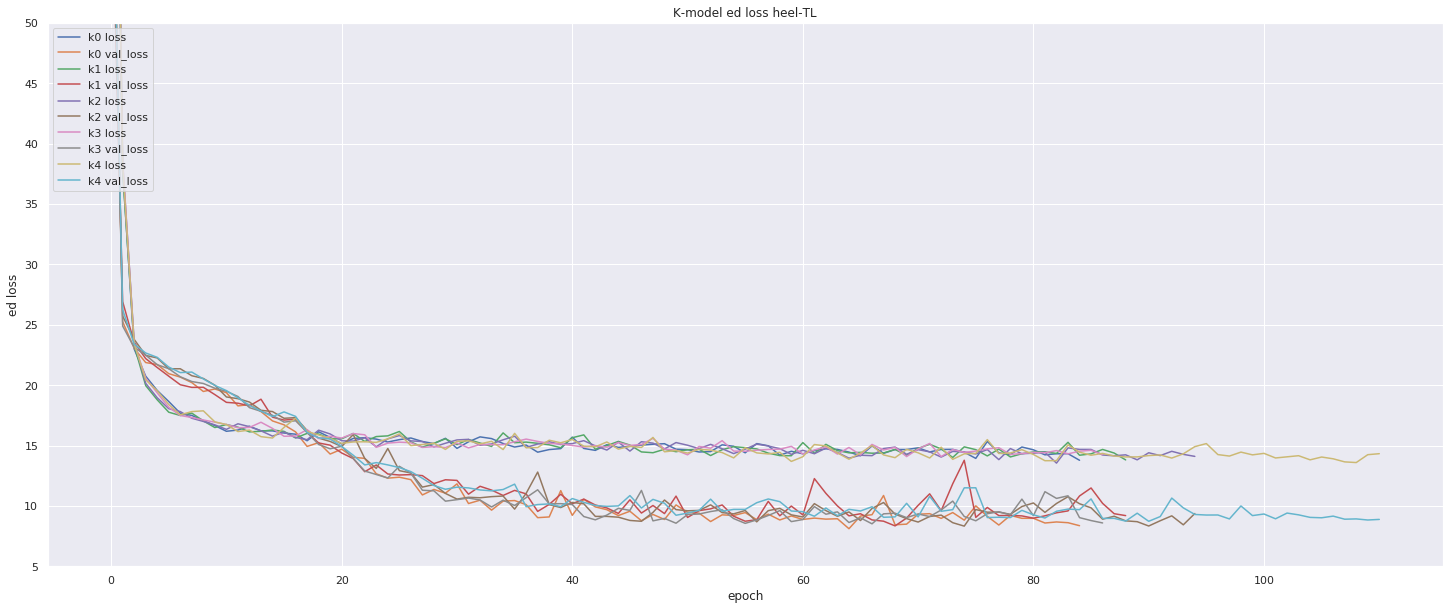

In [105]:
# Sum plot losses heel-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])

    
plt.title('K-model ed loss heel-TL')
plt.ylabel('ed loss'), plt.ylim(5, 50)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_TL.png', bbox_inches = 'tight')

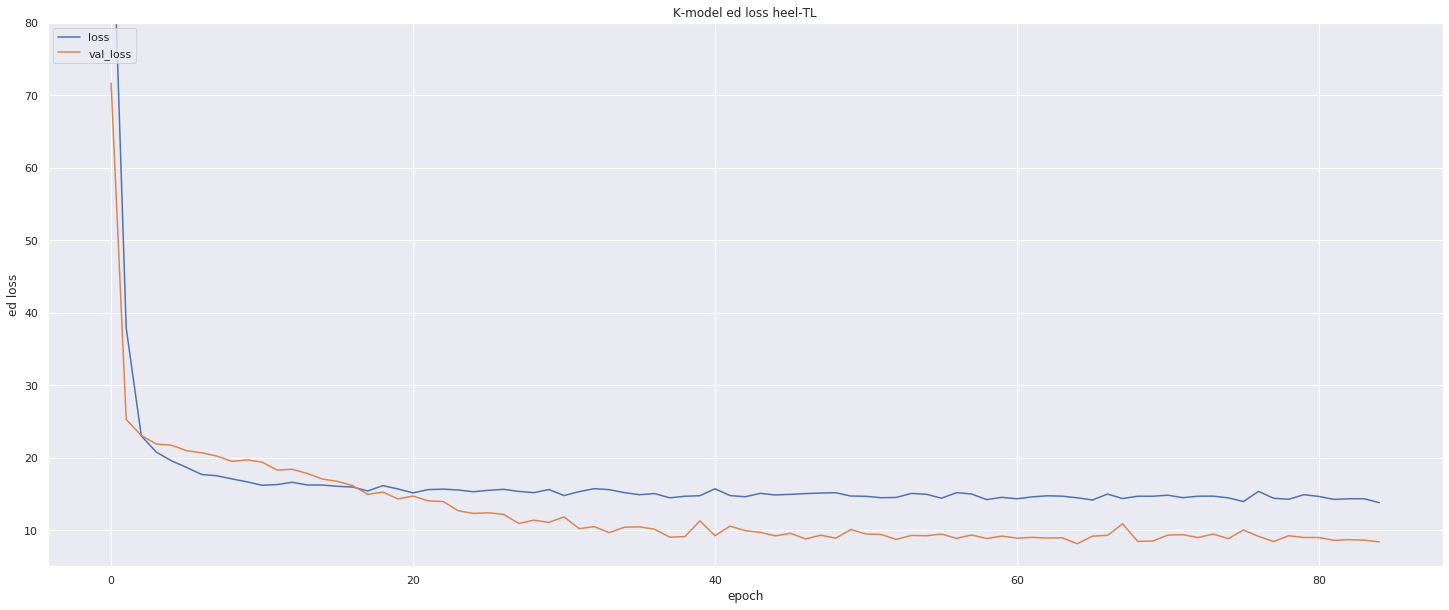

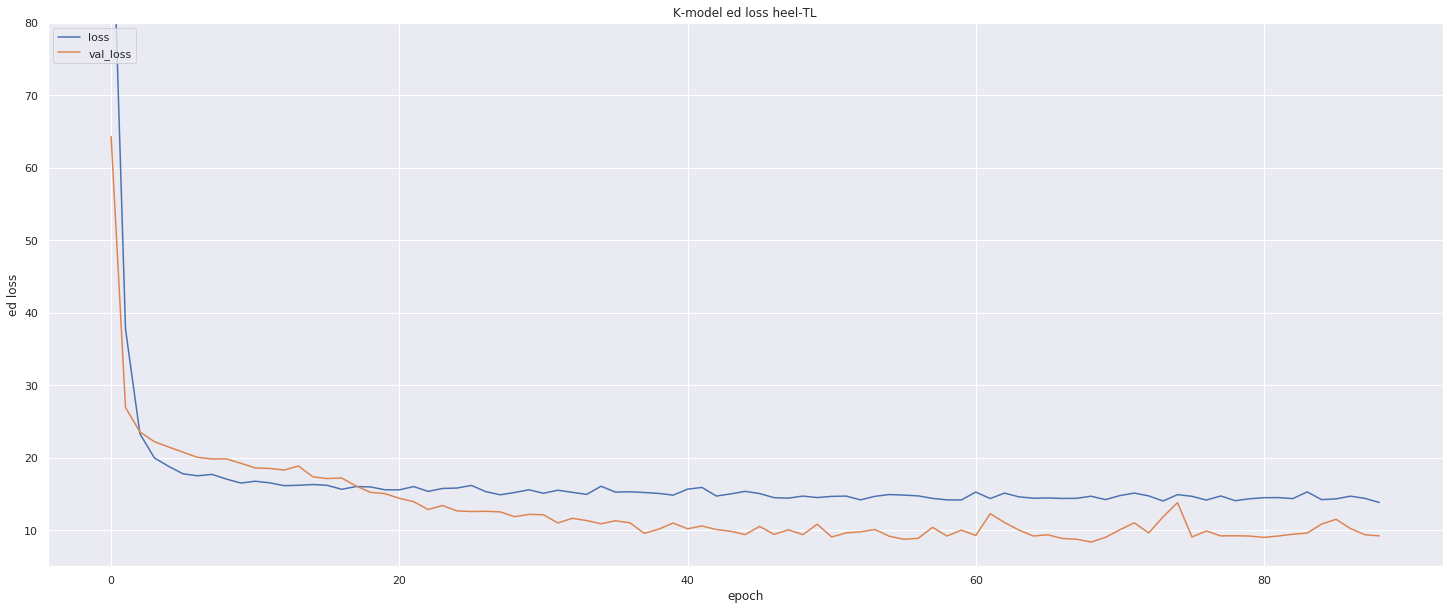

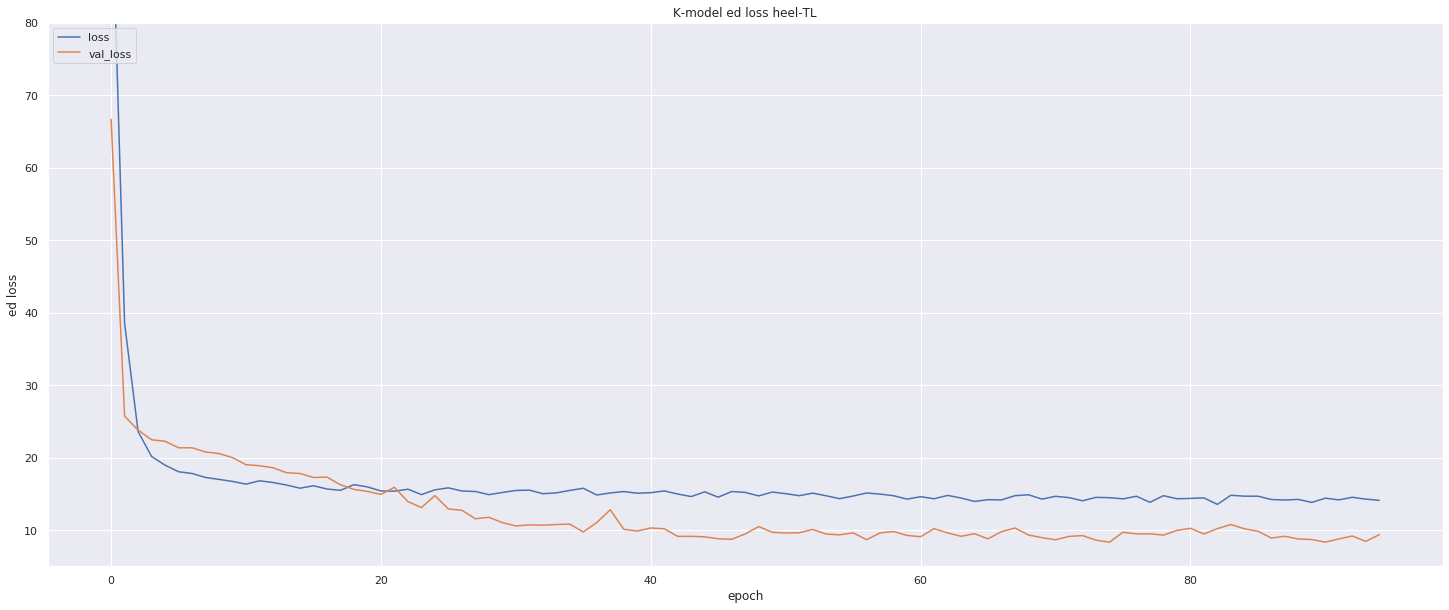

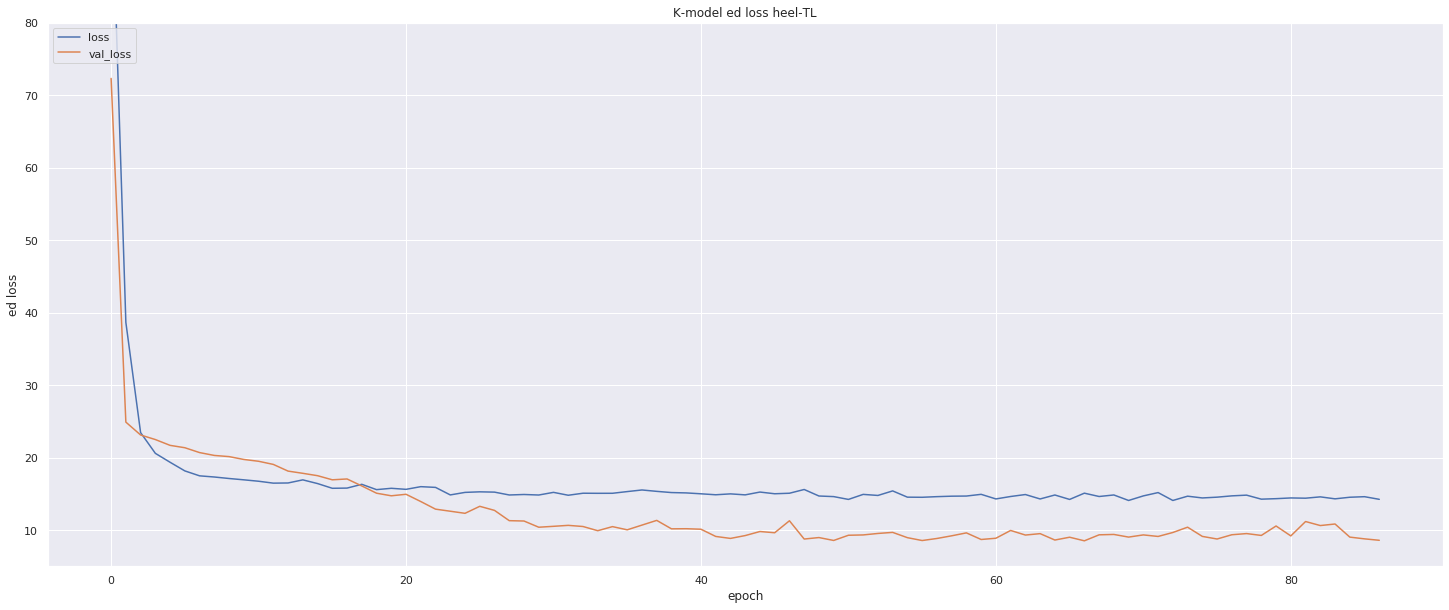

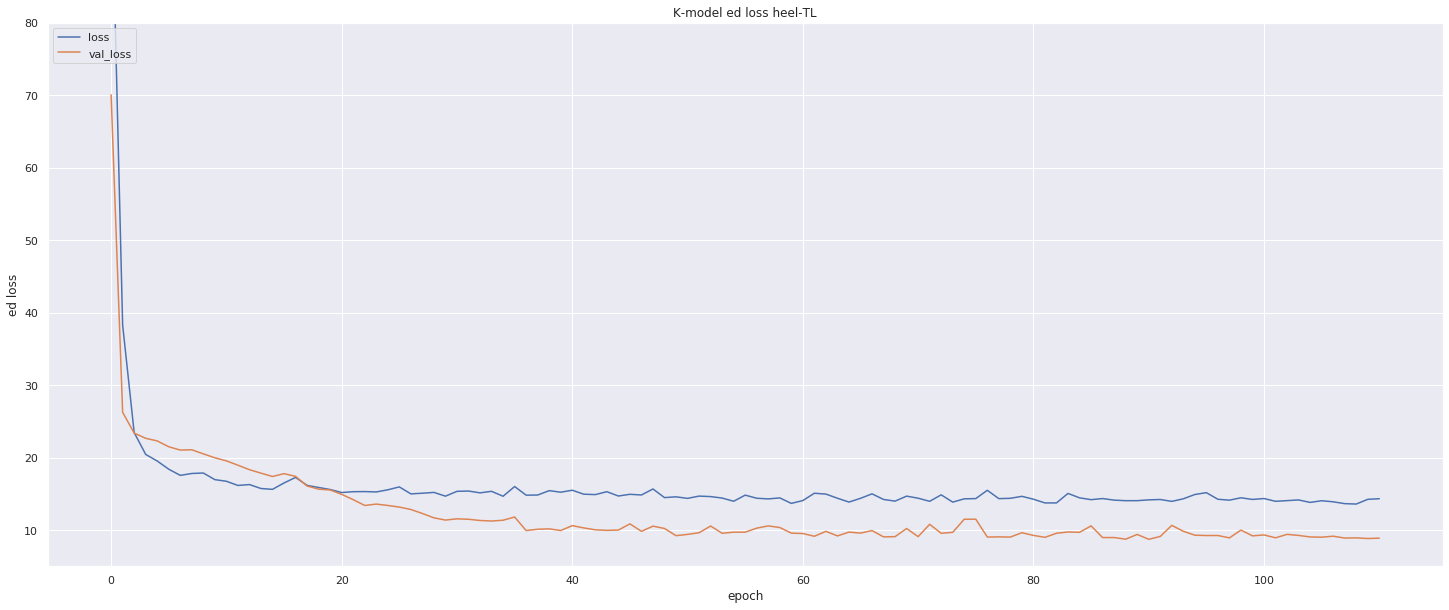

In [106]:
# Single plot loss heel-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])
    plt.title('K-model ed loss heel-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4


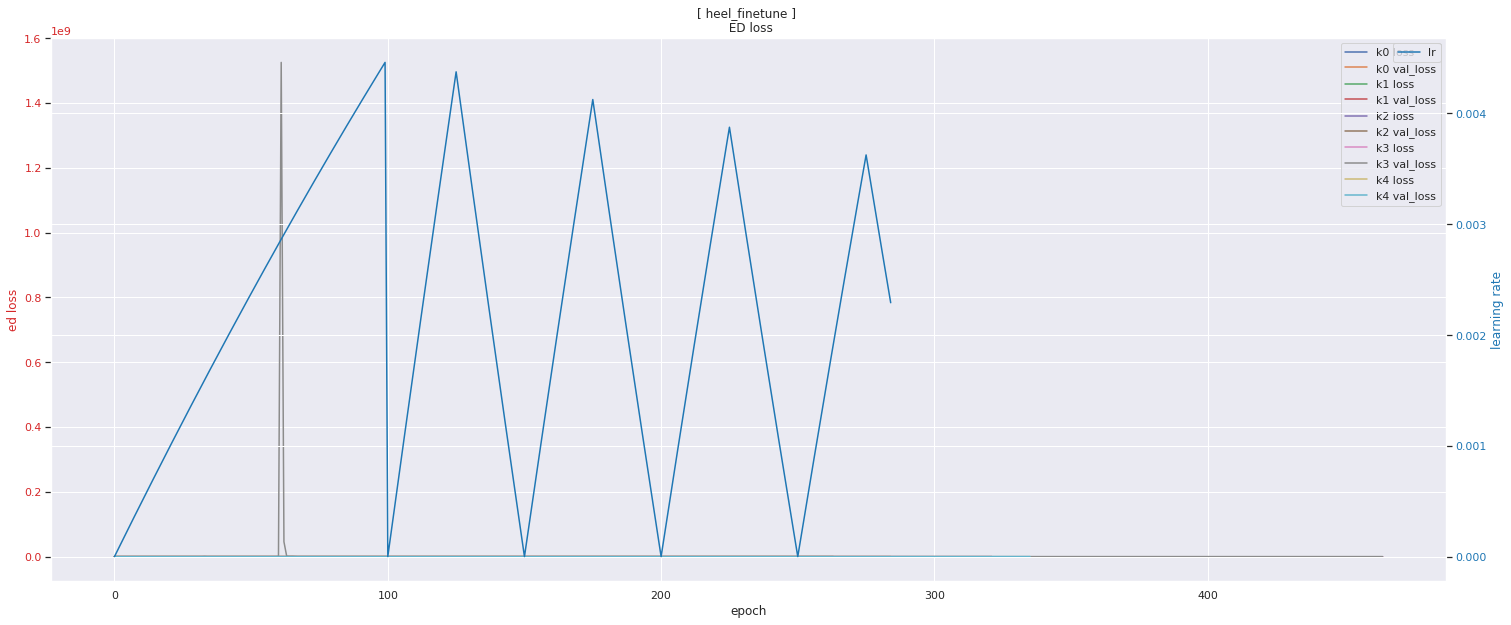

In [107]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    h_vl.append(h_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ heel_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper right') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_ft_Ksum-clr_ed{round(h_vl,4)}.png', bbox_inches = 'tight')

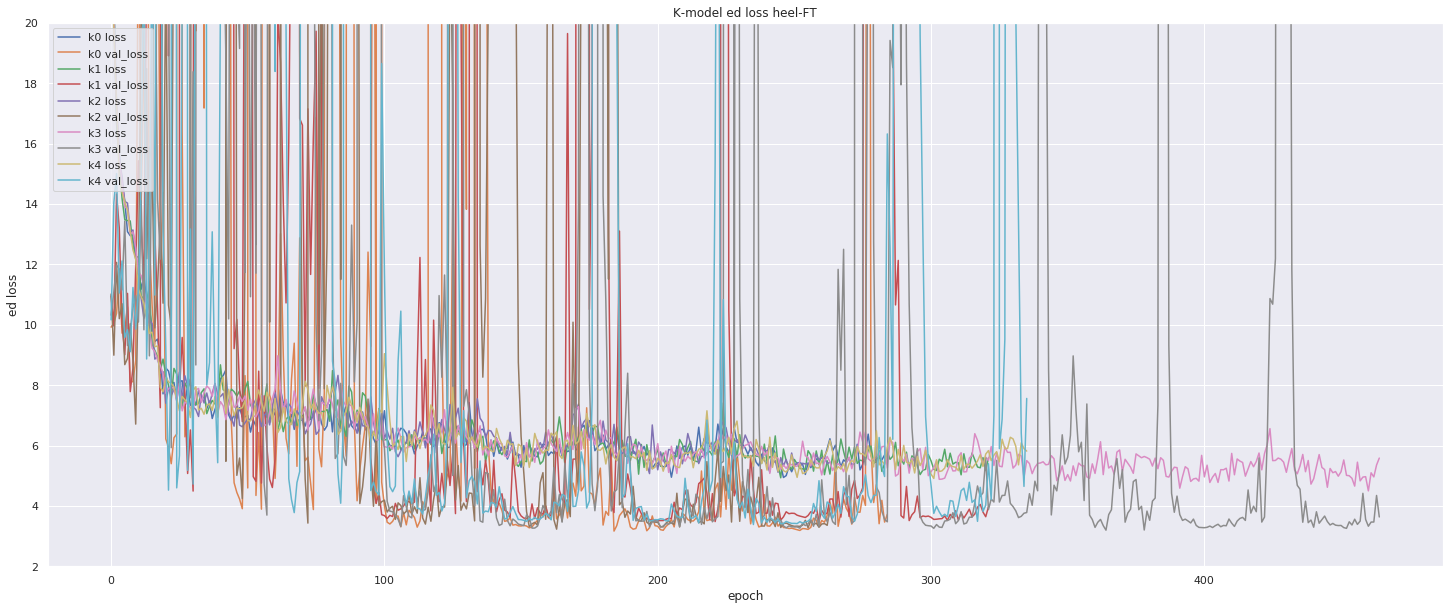

In [108]:
# Sum plot losses heel-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss heel-FT')
plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_FT.png', bbox_inches = 'tight')

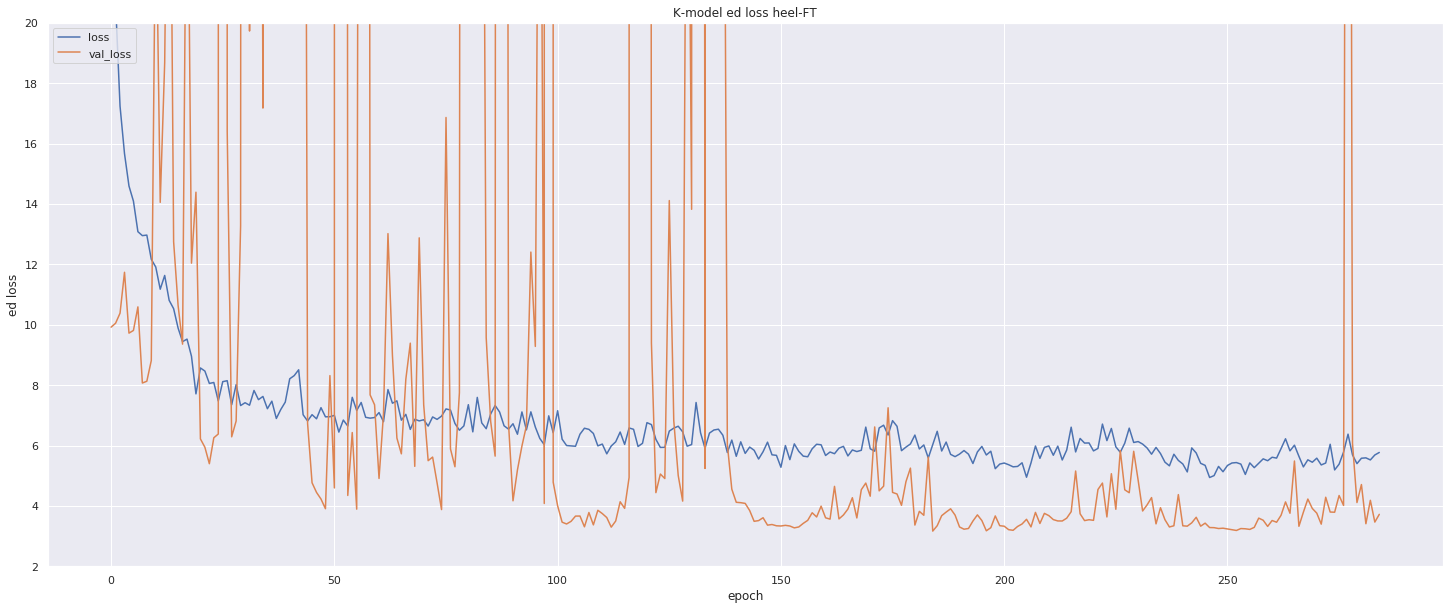

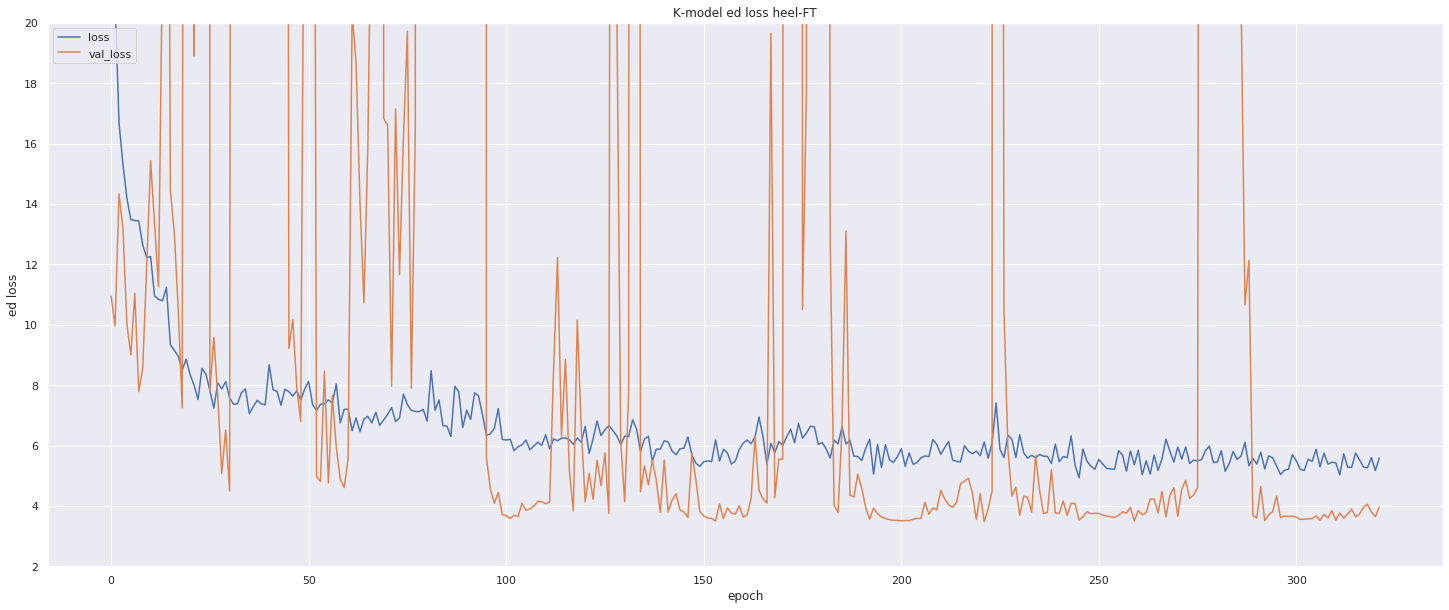

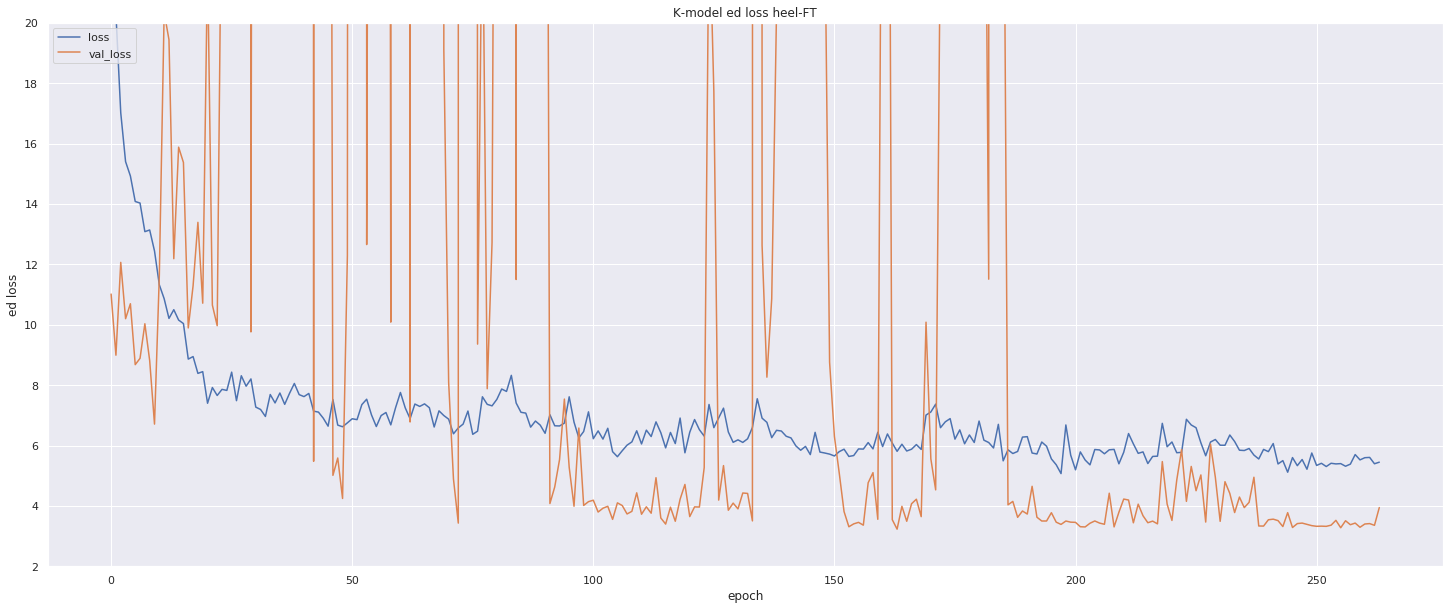

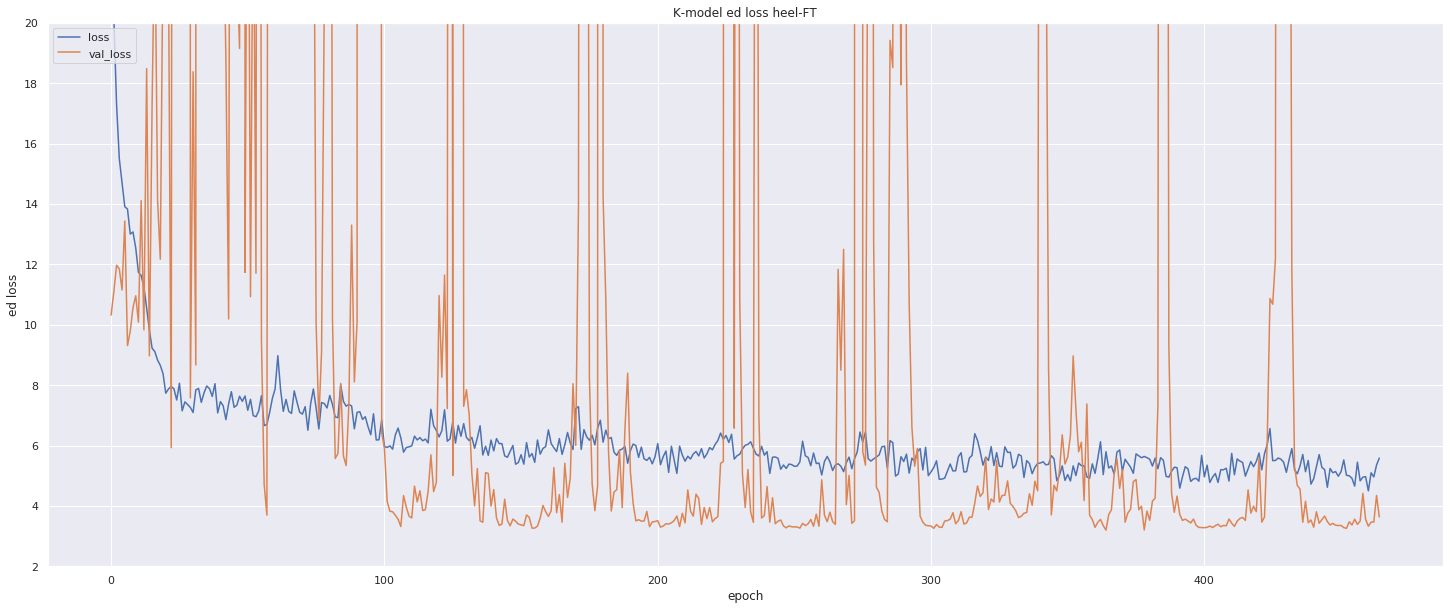

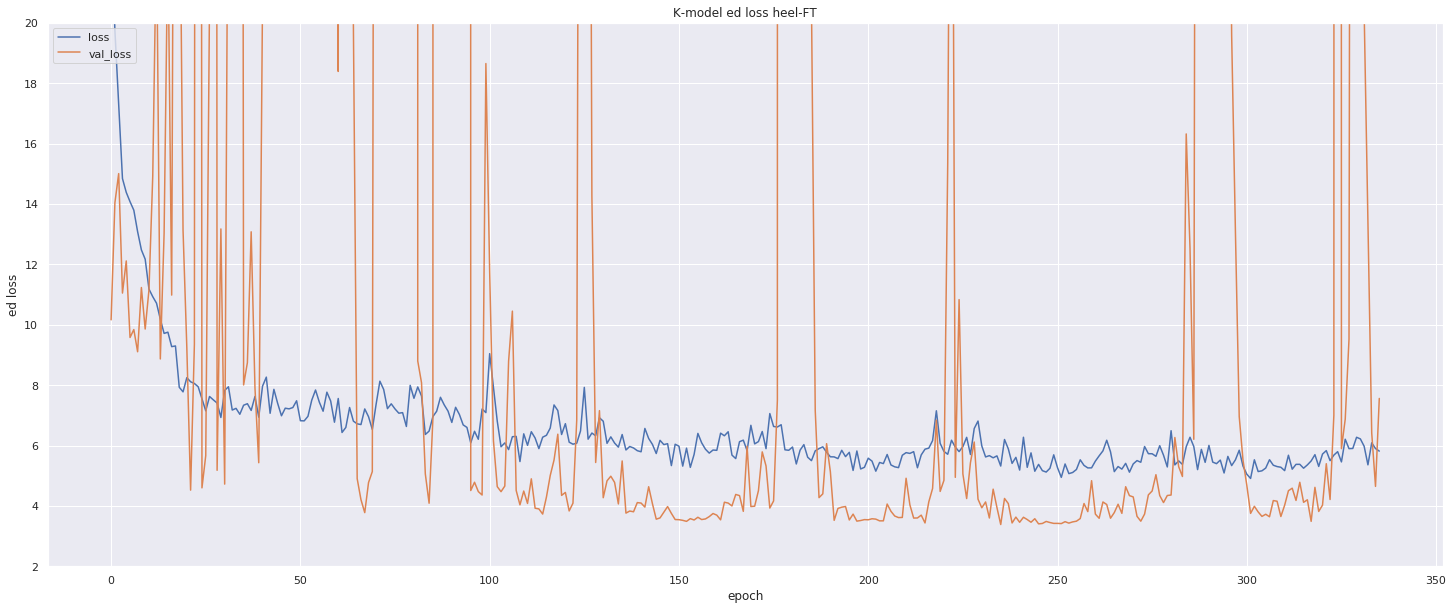

In [109]:
# Single plot loss heel-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])
    plt.title('K-model ed loss heel-FT')
    plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Ploting your model

In [110]:
# model_toe.summary()

In [111]:
# # show after modl.fit
# model_toe.metrics_names

In [112]:
# # check metrics the model have.
# history_toe.history.keys()

In [113]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [114]:
from tensorflow.keras.utils import plot_model
plot_model(model_toe, to_file='model_toe_conv_layer_blocks_B7_817.png', show_shapes=True)
from IPython.display import Image
Image(filename='model_toe_conv_layer_blocks_B7_817.png') 

## show pp pred

* we can switch toe/hell by comment it

### EFN Toe

In [115]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [116]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_toe.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [117]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [118]:
# np.abs(neg)[:5]

In [119]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [120]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [121]:
# # it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [122]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# # image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_heel.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [123]:
# pred[:5]

In [124]:
# label_batch[:5]

In [125]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [126]:
# np.abs(neg)[:10]

In [127]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [128]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [129]:
ts = 'test_submission.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)

images  x1  y1  x2  y2
0  image_0001.png NaN NaN NaN NaN
1  image_0002.png NaN NaN NaN NaN
2  image_0003.png NaN NaN NaN NaN
3  image_0004.png NaN NaN NaN NaN
4  image_0005.png NaN NaN NaN NaN

In [130]:
df_ts['images']

0      image_0001.png
1      image_0002.png
2      image_0003.png
3      image_0004.png
4      image_0005.png
            ...      
995    image_0996.png
996    image_0997.png
997    image_0998.png
998    image_0999.png
999    image_1000.png
Name: images, Length: 1000, dtype: object

In [131]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [132]:
len(list_ds_test)#.shape() #take(1)

1000

In [133]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [134]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

take test sample: b'image_0001.png'
take test sample: b'image_0002.png'
take test sample: b'image_0003.png'
take test sample: b'image_0004.png'
take test sample: b'image_0005.png'


### TEST DS: Process TEST path to image tensor

In [135]:
## TEST-DS: re-used from train/val-ds

im_test = 'test_images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [136]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [137]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

take sample: (120, 120, 3) b'image_0001.png'
take sample: (120, 120, 3) b'image_0002.png'
take sample: (120, 120, 3) b'image_0003.png'
take sample: (120, 120, 3) b'image_0004.png'
take sample: (120, 120, 3) b'image_0005.png'


### prepare TEST_ds_pre

In [138]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [139]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

Check cache in memory:Y True
Check cache in memory:Y True


# Load Best-K-models

In [140]:
# if K-models are in last time frame
# best_model_name = get_best_model_name(th, K=str(k))

predictions_toe = []
predictions_heel = []

for k in range(KFlodNum):
    print(f'K:{k}')
    best_model_toe_name = get_best_model_name('toe', K=str(k))
    best_model_heel_name = get_best_model_name('heel', K=str(k))

# # if models are in last time frame
# best_model_toe_name = get_best_model_name('toe')
# best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




    print(best_model_toe_name)
    print(best_model_heel_name)
    # log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

    best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
    best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)
    
    best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
    best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
        
        
    pred_toe = best_model_toe.predict(test_ds_pre_toe)
    pred_toe[:,1] = pred_toe[:,1] + y_offset_toe
    predictions_toe.append(pred_toe)
    
    pred_heel = best_model_heel.predict(test_ds_pre_heel)
    pred_heel[:,1] = pred_heel[:,1] + y_offset_heel
    predictions_heel.append(pred_heel)
    
    

K:0
./20210228-132845/toe_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
./20210228-132845/heel_K0_EfficientNetB7_bs64_w120_best_val_loss.h5
K:1
./20210228-132845/toe_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
./20210228-132845/heel_K1_EfficientNetB7_bs64_w120_best_val_loss.h5
K:2
./20210228-132845/toe_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
./20210228-132845/heel_K2_EfficientNetB7_bs64_w120_best_val_loss.h5
K:3
./20210228-132845/toe_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
./20210228-132845/heel_K3_EfficientNetB7_bs64_w120_best_val_loss.h5
K:4
./20210228-132845/toe_K4_EfficientNetB7_bs64_w120_best_val_loss.h5
./20210228-132845/heel_K4_EfficientNetB7_bs64_w120_best_val_loss.h5


In [141]:
len(predictions_toe[0])

1000

In [142]:
# make sure we got the k-pred as k models.
for i, _ in enumerate(predictions_toe):
    print(i)

0
1
2
3
4


In [143]:
np.shape(predictions_toe)

(5, 1000, 2)

In [144]:
predictions_toe[0]

array([[ 59.920242, 137.47166 ],
       [ 55.28405 , 137.60664 ],
       [ 57.85215 , 146.60419 ],
       ...,
       [ 62.23766 , 134.37943 ],
       [ 63.97385 , 119.87587 ],
       [ 59.08372 , 120.70157 ]], dtype=float32)

In [145]:
predictions_toe[1]

array([[ 61.161846, 137.09956 ],
       [ 58.136955, 145.01547 ],
       [ 54.883507, 147.5029  ],
       ...,
       [ 66.036674, 135.1572  ],
       [ 62.022705, 119.8203  ],
       [ 60.439125, 121.809204]], dtype=float32)

In [146]:
predictions_heel[0]

array([[ 80.282936, 379.8849  ],
       [ 22.287247, 376.45074 ],
       [ 77.667244, 383.3637  ],
       ...,
       [ 29.74116 , 381.96985 ],
       [ 74.52209 , 381.85522 ],
       [ 34.47555 , 381.61224 ]], dtype=float32)

In [147]:
predictions_heel[1]

array([[ 80.240845, 379.30426 ],
       [ 23.65562 , 375.59125 ],
       [ 77.49242 , 382.44467 ],
       ...,
       [ 30.299175, 381.04208 ],
       [ 76.16405 , 381.3446  ],
       [ 34.91065 , 380.79852 ]], dtype=float32)

In [148]:
# mean the k-predictions
k_predictions_toe = np.mean(predictions_toe, axis=0)
k_predictions_toe

array([[ 59.53899 , 136.3721  ],
       [ 56.574333, 140.50343 ],
       [ 56.602825, 145.96306 ],
       ...,
       [ 64.26142 , 134.53812 ],
       [ 62.792908, 120.59955 ],
       [ 60.156303, 122.4167  ]], dtype=float32)

In [149]:
np.shape(k_predictions_toe)

(1000, 2)

In [150]:
# mean the k-predictions
k_predictions_heel = np.mean(predictions_heel, axis=0)
k_predictions_heel

array([[ 80.17827 , 379.3808  ],
       [ 23.240177, 375.63837 ],
       [ 78.41553 , 382.86856 ],
       ...,
       [ 29.98318 , 381.38617 ],
       [ 75.43733 , 381.5352  ],
       [ 34.813934, 381.08267 ]], dtype=float32)

### Merge toe/hell pred

In [151]:
predictions_th = np.append(k_predictions_toe, k_predictions_heel, axis=1)#左右接
predictions_th.shape

(1000, 4)

In [152]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

(1000, 1)

In [153]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

(1000, 5)

In [154]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [155]:
submi_name = CSVNAME + '.' + log_dir_name +'.csv'

df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))

Save K1345.b7.195.20210228-132845.csv as submission CSV.


In [156]:
df_submission.head()

images       x1       y1       x2       y2
0  image_0001.png   59.539  136.372  80.1783  379.381
1  image_0002.png  56.5743  140.503  23.2402  375.638
2  image_0003.png  56.6028  145.963  78.4155  382.869
3  image_0004.png  57.8213  139.221  29.0541  373.071
4  image_0005.png  59.5138  147.234  66.5165  370.974

In [157]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    h_vl.append(h_v)

t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

K:0
K:1
K:2
K:3
K:4
5.84771 + 3.29142 = 9.13913


In [158]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [159]:
t_vl

5.847708415985108

In [160]:
h_vl

3.2914207935333253

In [161]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 30010.980144 seconds.


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [162]:
# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [163]:
# %%time
# # inference all test_ds once
# predictions_toe = best_model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

### Offset Toe

In [164]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# # for [0,1]
# # predictions_toe[:,0] = predictions_toe[:,0]*120
# # predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # # for [-1,1]
# # # for re-scale back xy 
# # # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# # predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# # predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

# predictions_toe

In [165]:
# %%time
# # inference all test_ds once
# predictions_heel = best_model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

### Offset Heel

In [166]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# # for [0,1]
# # predictions_heel[:,0] = predictions_heel[:,0]*120
# # predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # # for [-1,1]
# # predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# # predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

# predictions_heel

### Merge toe/hell pred

In [167]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [168]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [169]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [170]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [171]:
# submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [172]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [173]:
# df_submission.head()

In [174]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
# h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

In [175]:
#

## save model

In [176]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/

